In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(722000, 828)
(722000, 8)
validation
(113488, 828)
(113488, 8)
test
(56512, 828)
(56512, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/73 [..............................] - ETA: 1:34 - loss: 1.8902 - STD: 0.0502 - MAE: 0.2106

 4/73 [>.............................] - ETA: 1s - loss: 1.5963 - STD: 0.1349 - MAE: 0.1743  

 5/73 [=>............................] - ETA: 2s - loss: 1.5663 - STD: 0.1523 - MAE: 0.1673

 6/73 [=>............................] - ETA: 2s - loss: 1.5444 - STD: 0.1635 - MAE: 0.1629

 7/73 [=>............................] - ETA: 2s - loss: 1.5259 - STD: 0.1699 - MAE: 0.1601

 8/73 [==>...........................] - ETA: 2s - loss: 1.5109 - STD: 0.1727 - MAE: 0.1588

 9/73 [==>...........................] - ETA: 2s - loss: 1.5005 - STD: 0.1733 - MAE: 0.1585

10/73 [===>..........................] - ETA: 3s - loss: 1.4931 - STD: 0.1728 - MAE: 0.1586

11/73 [===>..........................] - ETA: 3s - loss: 1.4879 - STD: 0.1719 - MAE: 0.1589

12/73 [===>..........................] - ETA: 3s - loss: 1.4846 - STD: 0.1713 - MAE: 0.1591

13/73 [====>.........................] - ETA: 3s - loss: 1.4795 - STD: 0.1710 - MAE: 0.1592

14/73 [====>.........................] - ETA: 3s - loss: 1.4746 - STD: 0.1712 - MAE: 0.1590

15/73 [=====>........................] - ETA: 3s - loss: 1.4708 - STD: 0.1718 - MAE: 0.1587

16/73 [=====>........................] - ETA: 2s - loss: 1.4670 - STD: 0.1728 - MAE: 0.1583

17/73 [=====>........................] - ETA: 2s - loss: 1.4641 - STD: 0.1739 - MAE: 0.1578

18/73 [======>.......................] - ETA: 2s - loss: 1.4621 - STD: 0.1751 - MAE: 0.1573

19/73 [======>.......................] - ETA: 2s - loss: 1.4599 - STD: 0.1762 - MAE: 0.1569

20/73 [=======>......................] - ETA: 2s - loss: 1.4580 - STD: 0.1771 - MAE: 0.1565

21/73 [=======>......................] - ETA: 2s - loss: 1.4560 - STD: 0.1778 - MAE: 0.1563

22/73 [========>.....................] - ETA: 2s - loss: 1.4540 - STD: 0.1781 - MAE: 0.1561

23/73 [========>.....................] - ETA: 2s - loss: 1.4522 - STD: 0.1782 - MAE: 0.1561

24/73 [========>.....................] - ETA: 2s - loss: 1.4504 - STD: 0.1781 - MAE: 0.1561

25/73 [=========>....................] - ETA: 2s - loss: 1.4483 - STD: 0.1779 - MAE: 0.1561

26/73 [=========>....................] - ETA: 2s - loss: 1.4467 - STD: 0.1776 - MAE: 0.1562

27/73 [==========>...................] - ETA: 2s - loss: 1.4449 - STD: 0.1773 - MAE: 0.1562

28/73 [==========>...................] - ETA: 2s - loss: 1.4438 - STD: 0.1771 - MAE: 0.1563

29/73 [==========>...................] - ETA: 2s - loss: 1.4421 - STD: 0.1770 - MAE: 0.1563

30/73 [===========>..................] - ETA: 2s - loss: 1.4407 - STD: 0.1770 - MAE: 0.1563

31/73 [===========>..................] - ETA: 2s - loss: 1.4394 - STD: 0.1771 - MAE: 0.1562

32/73 [============>.................] - ETA: 2s - loss: 1.4386 - STD: 0.1773 - MAE: 0.1562

33/73 [============>.................] - ETA: 2s - loss: 1.4376 - STD: 0.1774 - MAE: 0.1561

34/73 [============>.................] - ETA: 2s - loss: 1.4363 - STD: 0.1776 - MAE: 0.1560

35/73 [=============>................] - ETA: 2s - loss: 1.4348 - STD: 0.1778 - MAE: 0.1559

36/73 [=============>................] - ETA: 2s - loss: 1.4336 - STD: 0.1779 - MAE: 0.1558

37/73 [==============>...............] - ETA: 2s - loss: 1.4324 - STD: 0.1780 - MAE: 0.1558

38/73 [==============>...............] - ETA: 1s - loss: 1.4313 - STD: 0.1780 - MAE: 0.1557

39/73 [===============>..............] - ETA: 1s - loss: 1.4305 - STD: 0.1779 - MAE: 0.1557

40/73 [===============>..............] - ETA: 1s - loss: 1.4296 - STD: 0.1778 - MAE: 0.1557

41/73 [===============>..............] - ETA: 1s - loss: 1.4286 - STD: 0.1778 - MAE: 0.1557

42/73 [================>.............] - ETA: 1s - loss: 1.4276 - STD: 0.1777 - MAE: 0.1557

43/73 [================>.............] - ETA: 1s - loss: 1.4266 - STD: 0.1776 - MAE: 0.1557

44/73 [=================>............] - ETA: 1s - loss: 1.4258 - STD: 0.1776 - MAE: 0.1557

45/73 [=================>............] - ETA: 1s - loss: 1.4249 - STD: 0.1776 - MAE: 0.1557

46/73 [=================>............] - ETA: 1s - loss: 1.4241 - STD: 0.1777 - MAE: 0.1556

47/73 [==================>...........] - ETA: 1s - loss: 1.4235 - STD: 0.1778 - MAE: 0.1556

48/73 [==================>...........] - ETA: 1s - loss: 1.4229 - STD: 0.1778 - MAE: 0.1555

49/73 [===================>..........] - ETA: 1s - loss: 1.4225 - STD: 0.1779 - MAE: 0.1555

50/73 [===================>..........] - ETA: 1s - loss: 1.4220 - STD: 0.1779 - MAE: 0.1555

51/73 [===================>..........] - ETA: 1s - loss: 1.4210 - STD: 0.1779 - MAE: 0.1555

52/73 [====================>.........] - ETA: 1s - loss: 1.4206 - STD: 0.1779 - MAE: 0.1555

53/73 [====================>.........] - ETA: 1s - loss: 1.4199 - STD: 0.1778 - MAE: 0.1555

54/73 [=====================>........] - ETA: 1s - loss: 1.4192 - STD: 0.1778 - MAE: 0.1554

55/73 [=====================>........] - ETA: 1s - loss: 1.4185 - STD: 0.1778 - MAE: 0.1554

56/73 [======================>.......] - ETA: 0s - loss: 1.4175 - STD: 0.1778 - MAE: 0.1554

57/73 [======================>.......] - ETA: 0s - loss: 1.4171 - STD: 0.1778 - MAE: 0.1554

58/73 [======================>.......] - ETA: 0s - loss: 1.4163 - STD: 0.1779 - MAE: 0.1553

59/73 [=======================>......] - ETA: 0s - loss: 1.4155 - STD: 0.1779 - MAE: 0.1553

60/73 [=======================>......] - ETA: 0s - loss: 1.4146 - STD: 0.1780 - MAE: 0.1552

61/73 [========================>.....] - ETA: 0s - loss: 1.4135 - STD: 0.1780 - MAE: 0.1552

62/73 [========================>.....] - ETA: 0s - loss: 1.4125 - STD: 0.1780 - MAE: 0.1551

63/73 [========================>.....] - ETA: 0s - loss: 1.4120 - STD: 0.1781 - MAE: 0.1551

64/73 [=========================>....] - ETA: 0s - loss: 1.4113 - STD: 0.1781 - MAE: 0.1550

65/73 [=========================>....] - ETA: 0s - loss: 1.4103 - STD: 0.1781 - MAE: 0.1550

66/73 [==========================>...] - ETA: 0s - loss: 1.4095 - STD: 0.1781 - MAE: 0.1549

67/73 [==========================>...] - ETA: 0s - loss: 1.4085 - STD: 0.1782 - MAE: 0.1549

68/73 [==========================>...] - ETA: 0s - loss: 1.4084 - STD: 0.1782 - MAE: 0.1548

72/73 [============================>.] - ETA: 0s - loss: 1.4044 - STD: 0.1785 - MAE: 0.1545

73/73 [==============================] - ETA: 0s - loss: 1.4036 - STD: 0.1786 - MAE: 0.1544

73/73 [==============================] - 7s 73ms/step - loss: 1.4036 - STD: 0.1786 - MAE: 0.1544 - val_loss: 1.3435 - val_STD: 0.1842 - val_MAE: 0.1493


Epoch 2/10000


 1/73 [..............................] - ETA: 6s - loss: 1.3189 - STD: 0.1899 - MAE: 0.1462

 2/73 [..............................] - ETA: 4s - loss: 1.3286 - STD: 0.1891 - MAE: 0.1470

 3/73 [>.............................] - ETA: 4s - loss: 1.3305 - STD: 0.1881 - MAE: 0.1476

 4/73 [>.............................] - ETA: 4s - loss: 1.3268 - STD: 0.1877 - MAE: 0.1475

 5/73 [=>............................] - ETA: 4s - loss: 1.3224 - STD: 0.1875 - MAE: 0.1474

 6/73 [=>............................] - ETA: 3s - loss: 1.3201 - STD: 0.1883 - MAE: 0.1470

 7/73 [=>............................] - ETA: 3s - loss: 1.3206 - STD: 0.1892 - MAE: 0.1467

 8/73 [==>...........................] - ETA: 3s - loss: 1.3238 - STD: 0.1894 - MAE: 0.1467

10/73 [===>..........................] - ETA: 3s - loss: 1.3219 - STD: 0.1889 - MAE: 0.1468

11/73 [===>..........................] - ETA: 3s - loss: 1.3209 - STD: 0.1891 - MAE: 0.1466

12/73 [===>..........................] - ETA: 3s - loss: 1.3222 - STD: 0.1894 - MAE: 0.1466

13/73 [====>.........................] - ETA: 3s - loss: 1.3228 - STD: 0.1896 - MAE: 0.1466

14/73 [====>.........................] - ETA: 3s - loss: 1.3225 - STD: 0.1892 - MAE: 0.1467

15/73 [=====>........................] - ETA: 3s - loss: 1.3220 - STD: 0.1888 - MAE: 0.1468

16/73 [=====>........................] - ETA: 3s - loss: 1.3206 - STD: 0.1888 - MAE: 0.1468

17/73 [=====>........................] - ETA: 3s - loss: 1.3210 - STD: 0.1891 - MAE: 0.1467

18/73 [======>.......................] - ETA: 3s - loss: 1.3209 - STD: 0.1894 - MAE: 0.1466

19/73 [======>.......................] - ETA: 3s - loss: 1.3203 - STD: 0.1894 - MAE: 0.1466

20/73 [=======>......................] - ETA: 2s - loss: 1.3199 - STD: 0.1893 - MAE: 0.1466

21/73 [=======>......................] - ETA: 2s - loss: 1.3183 - STD: 0.1892 - MAE: 0.1466

22/73 [========>.....................] - ETA: 2s - loss: 1.3170 - STD: 0.1894 - MAE: 0.1464

23/73 [========>.....................] - ETA: 2s - loss: 1.3178 - STD: 0.1897 - MAE: 0.1464

24/73 [========>.....................] - ETA: 2s - loss: 1.3171 - STD: 0.1896 - MAE: 0.1464

25/73 [=========>....................] - ETA: 2s - loss: 1.3162 - STD: 0.1894 - MAE: 0.1465

26/73 [=========>....................] - ETA: 2s - loss: 1.3159 - STD: 0.1892 - MAE: 0.1465

27/73 [==========>...................] - ETA: 2s - loss: 1.3154 - STD: 0.1891 - MAE: 0.1466

28/73 [==========>...................] - ETA: 2s - loss: 1.3152 - STD: 0.1892 - MAE: 0.1465

29/73 [==========>...................] - ETA: 2s - loss: 1.3148 - STD: 0.1892 - MAE: 0.1465

30/73 [===========>..................] - ETA: 2s - loss: 1.3139 - STD: 0.1892 - MAE: 0.1465

31/73 [===========>..................] - ETA: 2s - loss: 1.3134 - STD: 0.1891 - MAE: 0.1465

32/73 [============>.................] - ETA: 2s - loss: 1.3131 - STD: 0.1890 - MAE: 0.1466

33/73 [============>.................] - ETA: 2s - loss: 1.3124 - STD: 0.1891 - MAE: 0.1465

34/73 [============>.................] - ETA: 2s - loss: 1.3121 - STD: 0.1892 - MAE: 0.1465

35/73 [=============>................] - ETA: 2s - loss: 1.3109 - STD: 0.1893 - MAE: 0.1464

36/73 [=============>................] - ETA: 2s - loss: 1.3102 - STD: 0.1894 - MAE: 0.1463

37/73 [==============>...............] - ETA: 2s - loss: 1.3095 - STD: 0.1893 - MAE: 0.1463

38/73 [==============>...............] - ETA: 1s - loss: 1.3084 - STD: 0.1893 - MAE: 0.1463

39/73 [===============>..............] - ETA: 1s - loss: 1.3081 - STD: 0.1894 - MAE: 0.1463

40/73 [===============>..............] - ETA: 1s - loss: 1.3072 - STD: 0.1894 - MAE: 0.1463

41/73 [===============>..............] - ETA: 1s - loss: 1.3063 - STD: 0.1893 - MAE: 0.1462

42/73 [================>.............] - ETA: 1s - loss: 1.3053 - STD: 0.1894 - MAE: 0.1462

43/73 [================>.............] - ETA: 1s - loss: 1.3046 - STD: 0.1895 - MAE: 0.1461

44/73 [=================>............] - ETA: 1s - loss: 1.3041 - STD: 0.1895 - MAE: 0.1461

45/73 [=================>............] - ETA: 1s - loss: 1.3030 - STD: 0.1894 - MAE: 0.1461

46/73 [=================>............] - ETA: 1s - loss: 1.3023 - STD: 0.1894 - MAE: 0.1461

47/73 [==================>...........] - ETA: 1s - loss: 1.3020 - STD: 0.1894 - MAE: 0.1461

48/73 [==================>...........] - ETA: 1s - loss: 1.3011 - STD: 0.1894 - MAE: 0.1461

49/73 [===================>..........] - ETA: 1s - loss: 1.3002 - STD: 0.1894 - MAE: 0.1461

50/73 [===================>..........] - ETA: 1s - loss: 1.2993 - STD: 0.1895 - MAE: 0.1460

51/73 [===================>..........] - ETA: 1s - loss: 1.2982 - STD: 0.1895 - MAE: 0.1460

52/73 [====================>.........] - ETA: 1s - loss: 1.2974 - STD: 0.1896 - MAE: 0.1459

53/73 [====================>.........] - ETA: 1s - loss: 1.2966 - STD: 0.1896 - MAE: 0.1459

54/73 [=====================>........] - ETA: 1s - loss: 1.2951 - STD: 0.1897 - MAE: 0.1458

55/73 [=====================>........] - ETA: 1s - loss: 1.2938 - STD: 0.1898 - MAE: 0.1457

56/73 [======================>.......] - ETA: 0s - loss: 1.2928 - STD: 0.1899 - MAE: 0.1456

57/73 [======================>.......] - ETA: 0s - loss: 1.2917 - STD: 0.1899 - MAE: 0.1456

58/73 [======================>.......] - ETA: 0s - loss: 1.2902 - STD: 0.1899 - MAE: 0.1455

59/73 [=======================>......] - ETA: 0s - loss: 1.2893 - STD: 0.1900 - MAE: 0.1454

60/73 [=======================>......] - ETA: 0s - loss: 1.2876 - STD: 0.1901 - MAE: 0.1454

61/73 [========================>.....] - ETA: 0s - loss: 1.2862 - STD: 0.1902 - MAE: 0.1453

62/73 [========================>.....] - ETA: 0s - loss: 1.2848 - STD: 0.1903 - MAE: 0.1452

63/73 [========================>.....] - ETA: 0s - loss: 1.2836 - STD: 0.1903 - MAE: 0.1451

64/73 [=========================>....] - ETA: 0s - loss: 1.2825 - STD: 0.1903 - MAE: 0.1451

65/73 [=========================>....] - ETA: 0s - loss: 1.2813 - STD: 0.1904 - MAE: 0.1450

66/73 [==========================>...] - ETA: 0s - loss: 1.2799 - STD: 0.1905 - MAE: 0.1449

67/73 [==========================>...] - ETA: 0s - loss: 1.2784 - STD: 0.1906 - MAE: 0.1448

68/73 [==========================>...] - ETA: 0s - loss: 1.2771 - STD: 0.1906 - MAE: 0.1447

69/73 [===========================>..] - ETA: 0s - loss: 1.2757 - STD: 0.1908 - MAE: 0.1446

70/73 [===========================>..] - ETA: 0s - loss: 1.2745 - STD: 0.1909 - MAE: 0.1445

71/73 [============================>.] - ETA: 0s - loss: 1.2733 - STD: 0.1909 - MAE: 0.1445

72/73 [============================>.] - ETA: 0s - loss: 1.2720 - STD: 0.1911 - MAE: 0.1444

73/73 [==============================] - ETA: 0s - loss: 1.2705 - STD: 0.1913 - MAE: 0.1442

73/73 [==============================] - 4s 61ms/step - loss: 1.2705 - STD: 0.1913 - MAE: 0.1442 - val_loss: 1.3045 - val_STD: 0.1754 - val_MAE: 0.1526


Epoch 3/10000


 1/73 [..............................] - ETA: 6s - loss: 1.1735 - STD: 0.1886 - MAE: 0.1417

 2/73 [..............................] - ETA: 4s - loss: 1.1743 - STD: 0.1964 - MAE: 0.1388

 3/73 [>.............................] - ETA: 4s - loss: 1.1725 - STD: 0.1997 - MAE: 0.1373

 4/73 [>.............................] - ETA: 4s - loss: 1.1725 - STD: 0.1988 - MAE: 0.1377

 5/73 [=>............................] - ETA: 4s - loss: 1.1758 - STD: 0.1980 - MAE: 0.1383

 6/73 [=>............................] - ETA: 3s - loss: 1.1738 - STD: 0.1988 - MAE: 0.1379

 7/73 [=>............................] - ETA: 3s - loss: 1.1701 - STD: 0.1998 - MAE: 0.1373

 8/73 [==>...........................] - ETA: 3s - loss: 1.1682 - STD: 0.1995 - MAE: 0.1373

 9/73 [==>...........................] - ETA: 3s - loss: 1.1666 - STD: 0.2001 - MAE: 0.1371

10/73 [===>..........................] - ETA: 3s - loss: 1.1647 - STD: 0.2005 - MAE: 0.1369

11/73 [===>..........................] - ETA: 3s - loss: 1.1662 - STD: 0.2003 - MAE: 0.1370

12/73 [===>..........................] - ETA: 3s - loss: 1.1656 - STD: 0.2002 - MAE: 0.1370

13/73 [====>.........................] - ETA: 3s - loss: 1.1644 - STD: 0.2007 - MAE: 0.1368

14/73 [====>.........................] - ETA: 3s - loss: 1.1626 - STD: 0.2007 - MAE: 0.1367

15/73 [=====>........................] - ETA: 3s - loss: 1.1619 - STD: 0.2009 - MAE: 0.1366

16/73 [=====>........................] - ETA: 3s - loss: 1.1618 - STD: 0.2012 - MAE: 0.1365

17/73 [=====>........................] - ETA: 3s - loss: 1.1614 - STD: 0.2009 - MAE: 0.1366

18/73 [======>.......................] - ETA: 3s - loss: 1.1602 - STD: 0.2011 - MAE: 0.1365

19/73 [======>.......................] - ETA: 3s - loss: 1.1600 - STD: 0.2016 - MAE: 0.1363

20/73 [=======>......................] - ETA: 3s - loss: 1.1587 - STD: 0.2011 - MAE: 0.1365

21/73 [=======>......................] - ETA: 3s - loss: 1.1574 - STD: 0.2014 - MAE: 0.1363

22/73 [========>.....................] - ETA: 3s - loss: 1.1567 - STD: 0.2021 - MAE: 0.1360

23/73 [========>.....................] - ETA: 2s - loss: 1.1558 - STD: 0.2018 - MAE: 0.1361

24/73 [========>.....................] - ETA: 2s - loss: 1.1555 - STD: 0.2015 - MAE: 0.1362

25/73 [=========>....................] - ETA: 2s - loss: 1.1549 - STD: 0.2019 - MAE: 0.1360

26/73 [=========>....................] - ETA: 2s - loss: 1.1545 - STD: 0.2022 - MAE: 0.1359

27/73 [==========>...................] - ETA: 2s - loss: 1.1545 - STD: 0.2019 - MAE: 0.1360

28/73 [==========>...................] - ETA: 2s - loss: 1.1536 - STD: 0.2018 - MAE: 0.1360

29/73 [==========>...................] - ETA: 2s - loss: 1.1531 - STD: 0.2022 - MAE: 0.1358

30/73 [===========>..................] - ETA: 2s - loss: 1.1527 - STD: 0.2024 - MAE: 0.1357

31/73 [===========>..................] - ETA: 2s - loss: 1.1521 - STD: 0.2022 - MAE: 0.1358

32/73 [============>.................] - ETA: 2s - loss: 1.1512 - STD: 0.2023 - MAE: 0.1357

33/73 [============>.................] - ETA: 2s - loss: 1.1511 - STD: 0.2025 - MAE: 0.1356

34/73 [============>.................] - ETA: 2s - loss: 1.1511 - STD: 0.2024 - MAE: 0.1357

35/73 [=============>................] - ETA: 2s - loss: 1.1503 - STD: 0.2023 - MAE: 0.1357

36/73 [=============>................] - ETA: 2s - loss: 1.1501 - STD: 0.2026 - MAE: 0.1356

37/73 [==============>...............] - ETA: 2s - loss: 1.1494 - STD: 0.2027 - MAE: 0.1355

38/73 [==============>...............] - ETA: 2s - loss: 1.1489 - STD: 0.2025 - MAE: 0.1355

39/73 [===============>..............] - ETA: 2s - loss: 1.1481 - STD: 0.2026 - MAE: 0.1355

40/73 [===============>..............] - ETA: 1s - loss: 1.1479 - STD: 0.2028 - MAE: 0.1354

41/73 [===============>..............] - ETA: 1s - loss: 1.1472 - STD: 0.2028 - MAE: 0.1354

42/73 [================>.............] - ETA: 1s - loss: 1.1471 - STD: 0.2027 - MAE: 0.1354

43/73 [================>.............] - ETA: 1s - loss: 1.1464 - STD: 0.2028 - MAE: 0.1353

44/73 [=================>............] - ETA: 1s - loss: 1.1453 - STD: 0.2029 - MAE: 0.1352

45/73 [=================>............] - ETA: 1s - loss: 1.1449 - STD: 0.2030 - MAE: 0.1352

46/73 [=================>............] - ETA: 1s - loss: 1.1442 - STD: 0.2029 - MAE: 0.1352

47/73 [==================>...........] - ETA: 1s - loss: 1.1433 - STD: 0.2030 - MAE: 0.1351

49/73 [===================>..........] - ETA: 1s - loss: 1.1426 - STD: 0.2031 - MAE: 0.1351

50/73 [===================>..........] - ETA: 1s - loss: 1.1420 - STD: 0.2032 - MAE: 0.1350

51/73 [===================>..........] - ETA: 1s - loss: 1.1414 - STD: 0.2034 - MAE: 0.1349

52/73 [====================>.........] - ETA: 1s - loss: 1.1414 - STD: 0.2033 - MAE: 0.1349

53/73 [====================>.........] - ETA: 1s - loss: 1.1410 - STD: 0.2032 - MAE: 0.1350

54/73 [=====================>........] - ETA: 1s - loss: 1.1408 - STD: 0.2034 - MAE: 0.1349

55/73 [=====================>........] - ETA: 1s - loss: 1.1402 - STD: 0.2034 - MAE: 0.1348

56/73 [======================>.......] - ETA: 0s - loss: 1.1402 - STD: 0.2033 - MAE: 0.1349

57/73 [======================>.......] - ETA: 0s - loss: 1.1395 - STD: 0.2033 - MAE: 0.1349

58/73 [======================>.......] - ETA: 0s - loss: 1.1390 - STD: 0.2035 - MAE: 0.1348

59/73 [=======================>......] - ETA: 0s - loss: 1.1383 - STD: 0.2035 - MAE: 0.1348

60/73 [=======================>......] - ETA: 0s - loss: 1.1377 - STD: 0.2035 - MAE: 0.1347

61/73 [========================>.....] - ETA: 0s - loss: 1.1371 - STD: 0.2036 - MAE: 0.1347

62/73 [========================>.....] - ETA: 0s - loss: 1.1366 - STD: 0.2036 - MAE: 0.1346

63/73 [========================>.....] - ETA: 0s - loss: 1.1360 - STD: 0.2036 - MAE: 0.1346

64/73 [=========================>....] - ETA: 0s - loss: 1.1353 - STD: 0.2036 - MAE: 0.1346

65/73 [=========================>....] - ETA: 0s - loss: 1.1346 - STD: 0.2037 - MAE: 0.1345

66/73 [==========================>...] - ETA: 0s - loss: 1.1341 - STD: 0.2037 - MAE: 0.1345

67/73 [==========================>...] - ETA: 0s - loss: 1.1337 - STD: 0.2038 - MAE: 0.1345

68/73 [==========================>...] - ETA: 0s - loss: 1.1333 - STD: 0.2038 - MAE: 0.1345

69/73 [===========================>..] - ETA: 0s - loss: 1.1329 - STD: 0.2038 - MAE: 0.1345

70/73 [===========================>..] - ETA: 0s - loss: 1.1321 - STD: 0.2038 - MAE: 0.1344

71/73 [============================>.] - ETA: 0s - loss: 1.1316 - STD: 0.2039 - MAE: 0.1344

72/73 [============================>.] - ETA: 0s - loss: 1.1310 - STD: 0.2039 - MAE: 0.1343

73/73 [==============================] - ETA: 0s - loss: 1.1301 - STD: 0.2040 - MAE: 0.1343

73/73 [==============================] - 5s 62ms/step - loss: 1.1301 - STD: 0.2040 - MAE: 0.1343 - val_loss: 1.1945 - val_STD: 0.2034 - val_MAE: 0.1369


Epoch 4/10000


 1/73 [..............................] - ETA: 6s - loss: 1.0752 - STD: 0.2113 - MAE: 0.1292

 2/73 [..............................] - ETA: 4s - loss: 1.0789 - STD: 0.2065 - MAE: 0.1314

 3/73 [>.............................] - ETA: 4s - loss: 1.0746 - STD: 0.2073 - MAE: 0.1308

 4/73 [>.............................] - ETA: 3s - loss: 1.0757 - STD: 0.2102 - MAE: 0.1298

 5/73 [=>............................] - ETA: 3s - loss: 1.0758 - STD: 0.2074 - MAE: 0.1309

 6/73 [=>............................] - ETA: 3s - loss: 1.0737 - STD: 0.2068 - MAE: 0.1311

 7/73 [=>............................] - ETA: 3s - loss: 1.0759 - STD: 0.2094 - MAE: 0.1302

 8/73 [==>...........................] - ETA: 3s - loss: 1.0741 - STD: 0.2080 - MAE: 0.1307

 9/73 [==>...........................] - ETA: 3s - loss: 1.0732 - STD: 0.2074 - MAE: 0.1309

10/73 [===>..........................] - ETA: 3s - loss: 1.0732 - STD: 0.2085 - MAE: 0.1304

11/73 [===>..........................] - ETA: 3s - loss: 1.0722 - STD: 0.2086 - MAE: 0.1303

12/73 [===>..........................] - ETA: 3s - loss: 1.0723 - STD: 0.2074 - MAE: 0.1308

13/73 [====>.........................] - ETA: 3s - loss: 1.0723 - STD: 0.2077 - MAE: 0.1307

14/73 [====>.........................] - ETA: 3s - loss: 1.0710 - STD: 0.2086 - MAE: 0.1302

15/73 [=====>........................] - ETA: 3s - loss: 1.0694 - STD: 0.2082 - MAE: 0.1304

16/73 [=====>........................] - ETA: 3s - loss: 1.0677 - STD: 0.2077 - MAE: 0.1305

17/73 [=====>........................] - ETA: 3s - loss: 1.0668 - STD: 0.2085 - MAE: 0.1301

18/73 [======>.......................] - ETA: 3s - loss: 1.0660 - STD: 0.2088 - MAE: 0.1300

19/73 [======>.......................] - ETA: 3s - loss: 1.0653 - STD: 0.2083 - MAE: 0.1301

20/73 [=======>......................] - ETA: 2s - loss: 1.0638 - STD: 0.2085 - MAE: 0.1300

21/73 [=======>......................] - ETA: 2s - loss: 1.0635 - STD: 0.2092 - MAE: 0.1297

22/73 [========>.....................] - ETA: 2s - loss: 1.0628 - STD: 0.2089 - MAE: 0.1298

23/73 [========>.....................] - ETA: 2s - loss: 1.0620 - STD: 0.2085 - MAE: 0.1300

24/73 [========>.....................] - ETA: 2s - loss: 1.0607 - STD: 0.2088 - MAE: 0.1298

25/73 [=========>....................] - ETA: 2s - loss: 1.0599 - STD: 0.2094 - MAE: 0.1295

26/73 [=========>....................] - ETA: 2s - loss: 1.0588 - STD: 0.2091 - MAE: 0.1295

27/73 [==========>...................] - ETA: 2s - loss: 1.0578 - STD: 0.2088 - MAE: 0.1296

28/73 [==========>...................] - ETA: 2s - loss: 1.0571 - STD: 0.2093 - MAE: 0.1294

29/73 [==========>...................] - ETA: 2s - loss: 1.0561 - STD: 0.2096 - MAE: 0.1292

30/73 [===========>..................] - ETA: 2s - loss: 1.0555 - STD: 0.2095 - MAE: 0.1292

31/73 [===========>..................] - ETA: 2s - loss: 1.0551 - STD: 0.2094 - MAE: 0.1293

32/73 [============>.................] - ETA: 2s - loss: 1.0545 - STD: 0.2097 - MAE: 0.1291

33/73 [============>.................] - ETA: 2s - loss: 1.0538 - STD: 0.2100 - MAE: 0.1290

34/73 [============>.................] - ETA: 2s - loss: 1.0528 - STD: 0.2099 - MAE: 0.1290

35/73 [=============>................] - ETA: 2s - loss: 1.0517 - STD: 0.2100 - MAE: 0.1289

36/73 [=============>................] - ETA: 2s - loss: 1.0510 - STD: 0.2101 - MAE: 0.1288

37/73 [==============>...............] - ETA: 2s - loss: 1.0505 - STD: 0.2102 - MAE: 0.1288

38/73 [==============>...............] - ETA: 1s - loss: 1.0498 - STD: 0.2104 - MAE: 0.1287

39/73 [===============>..............] - ETA: 1s - loss: 1.0492 - STD: 0.2104 - MAE: 0.1287

40/73 [===============>..............] - ETA: 1s - loss: 1.0484 - STD: 0.2104 - MAE: 0.1286

41/73 [===============>..............] - ETA: 1s - loss: 1.0478 - STD: 0.2107 - MAE: 0.1285

42/73 [================>.............] - ETA: 1s - loss: 1.0469 - STD: 0.2108 - MAE: 0.1284

43/73 [================>.............] - ETA: 1s - loss: 1.0463 - STD: 0.2107 - MAE: 0.1284

44/73 [=================>............] - ETA: 1s - loss: 1.0461 - STD: 0.2108 - MAE: 0.1283

45/73 [=================>............] - ETA: 1s - loss: 1.0454 - STD: 0.2108 - MAE: 0.1283

46/73 [=================>............] - ETA: 1s - loss: 1.0446 - STD: 0.2109 - MAE: 0.1282

47/73 [==================>...........] - ETA: 1s - loss: 1.0438 - STD: 0.2111 - MAE: 0.1281

48/73 [==================>...........] - ETA: 1s - loss: 1.0437 - STD: 0.2111 - MAE: 0.1281

49/73 [===================>..........] - ETA: 1s - loss: 1.0433 - STD: 0.2111 - MAE: 0.1281

51/73 [===================>..........] - ETA: 1s - loss: 1.0425 - STD: 0.2112 - MAE: 0.1281

52/73 [====================>.........] - ETA: 1s - loss: 1.0425 - STD: 0.2113 - MAE: 0.1280

53/73 [====================>.........] - ETA: 1s - loss: 1.0423 - STD: 0.2114 - MAE: 0.1280

54/73 [=====================>........] - ETA: 1s - loss: 1.0421 - STD: 0.2113 - MAE: 0.1280

55/73 [=====================>........] - ETA: 0s - loss: 1.0415 - STD: 0.2113 - MAE: 0.1280

56/73 [======================>.......] - ETA: 0s - loss: 1.0414 - STD: 0.2116 - MAE: 0.1279

57/73 [======================>.......] - ETA: 0s - loss: 1.0407 - STD: 0.2115 - MAE: 0.1278

58/73 [======================>.......] - ETA: 0s - loss: 1.0404 - STD: 0.2114 - MAE: 0.1279

59/73 [=======================>......] - ETA: 0s - loss: 1.0398 - STD: 0.2116 - MAE: 0.1278

60/73 [=======================>......] - ETA: 0s - loss: 1.0394 - STD: 0.2117 - MAE: 0.1277

61/73 [========================>.....] - ETA: 0s - loss: 1.0393 - STD: 0.2117 - MAE: 0.1277

62/73 [========================>.....] - ETA: 0s - loss: 1.0390 - STD: 0.2117 - MAE: 0.1277

63/73 [========================>.....] - ETA: 0s - loss: 1.0386 - STD: 0.2117 - MAE: 0.1277

64/73 [=========================>....] - ETA: 0s - loss: 1.0380 - STD: 0.2118 - MAE: 0.1276

65/73 [=========================>....] - ETA: 0s - loss: 1.0374 - STD: 0.2119 - MAE: 0.1276

66/73 [==========================>...] - ETA: 0s - loss: 1.0370 - STD: 0.2120 - MAE: 0.1275

67/73 [==========================>...] - ETA: 0s - loss: 1.0365 - STD: 0.2119 - MAE: 0.1275

68/73 [==========================>...] - ETA: 0s - loss: 1.0358 - STD: 0.2119 - MAE: 0.1275

69/73 [===========================>..] - ETA: 0s - loss: 1.0353 - STD: 0.2122 - MAE: 0.1274

70/73 [===========================>..] - ETA: 0s - loss: 1.0349 - STD: 0.2122 - MAE: 0.1274

71/73 [============================>.] - ETA: 0s - loss: 1.0344 - STD: 0.2121 - MAE: 0.1274

72/73 [============================>.] - ETA: 0s - loss: 1.0342 - STD: 0.2122 - MAE: 0.1273

73/73 [==============================] - ETA: 0s - loss: 1.0340 - STD: 0.2123 - MAE: 0.1273

73/73 [==============================] - 4s 60ms/step - loss: 1.0340 - STD: 0.2123 - MAE: 0.1273 - val_loss: 1.1323 - val_STD: 0.2121 - val_MAE: 0.1318


Epoch 5/10000


 1/73 [..............................] - ETA: 5s - loss: 1.0010 - STD: 0.2138 - MAE: 0.1256

 2/73 [..............................] - ETA: 4s - loss: 0.9965 - STD: 0.2140 - MAE: 0.1251

 3/73 [>.............................] - ETA: 4s - loss: 1.0009 - STD: 0.2154 - MAE: 0.1247

 4/73 [>.............................] - ETA: 4s - loss: 0.9997 - STD: 0.2154 - MAE: 0.1246

 5/73 [=>............................] - ETA: 4s - loss: 0.9980 - STD: 0.2160 - MAE: 0.1243

 6/73 [=>............................] - ETA: 4s - loss: 1.0010 - STD: 0.2160 - MAE: 0.1244

 7/73 [=>............................] - ETA: 4s - loss: 0.9984 - STD: 0.2160 - MAE: 0.1243

 8/73 [==>...........................] - ETA: 3s - loss: 0.9967 - STD: 0.2160 - MAE: 0.1242

 9/73 [==>...........................] - ETA: 3s - loss: 0.9955 - STD: 0.2162 - MAE: 0.1240

10/73 [===>..........................] - ETA: 3s - loss: 0.9951 - STD: 0.2165 - MAE: 0.1239

11/73 [===>..........................] - ETA: 3s - loss: 0.9950 - STD: 0.2163 - MAE: 0.1240

12/73 [===>..........................] - ETA: 3s - loss: 0.9955 - STD: 0.2161 - MAE: 0.1241

13/73 [====>.........................] - ETA: 3s - loss: 0.9949 - STD: 0.2162 - MAE: 0.1241

14/73 [====>.........................] - ETA: 3s - loss: 0.9945 - STD: 0.2161 - MAE: 0.1241

15/73 [=====>........................] - ETA: 3s - loss: 0.9945 - STD: 0.2162 - MAE: 0.1240

16/73 [=====>........................] - ETA: 3s - loss: 0.9956 - STD: 0.2163 - MAE: 0.1241

17/73 [=====>........................] - ETA: 3s - loss: 0.9961 - STD: 0.2159 - MAE: 0.1243

18/73 [======>.......................] - ETA: 3s - loss: 0.9972 - STD: 0.2162 - MAE: 0.1242

19/73 [======>.......................] - ETA: 3s - loss: 0.9971 - STD: 0.2164 - MAE: 0.1241

20/73 [=======>......................] - ETA: 3s - loss: 0.9967 - STD: 0.2162 - MAE: 0.1242

21/73 [=======>......................] - ETA: 3s - loss: 0.9965 - STD: 0.2161 - MAE: 0.1242

22/73 [========>.....................] - ETA: 3s - loss: 0.9976 - STD: 0.2166 - MAE: 0.1241

23/73 [========>.....................] - ETA: 3s - loss: 0.9980 - STD: 0.2163 - MAE: 0.1242

24/73 [========>.....................] - ETA: 2s - loss: 0.9972 - STD: 0.2160 - MAE: 0.1243

25/73 [=========>....................] - ETA: 2s - loss: 0.9970 - STD: 0.2165 - MAE: 0.1241

26/73 [=========>....................] - ETA: 2s - loss: 0.9974 - STD: 0.2165 - MAE: 0.1241

27/73 [==========>...................] - ETA: 2s - loss: 0.9973 - STD: 0.2162 - MAE: 0.1243

28/73 [==========>...................] - ETA: 2s - loss: 0.9972 - STD: 0.2163 - MAE: 0.1242

29/73 [==========>...................] - ETA: 2s - loss: 0.9969 - STD: 0.2167 - MAE: 0.1240

30/73 [===========>..................] - ETA: 2s - loss: 0.9963 - STD: 0.2165 - MAE: 0.1241

31/73 [===========>..................] - ETA: 2s - loss: 0.9960 - STD: 0.2164 - MAE: 0.1241

33/73 [============>.................] - ETA: 2s - loss: 0.9951 - STD: 0.2168 - MAE: 0.1238

34/73 [============>.................] - ETA: 2s - loss: 0.9949 - STD: 0.2168 - MAE: 0.1238

35/73 [=============>................] - ETA: 2s - loss: 0.9947 - STD: 0.2168 - MAE: 0.1238

36/73 [=============>................] - ETA: 2s - loss: 0.9946 - STD: 0.2167 - MAE: 0.1239

37/73 [==============>...............] - ETA: 2s - loss: 0.9947 - STD: 0.2169 - MAE: 0.1238

38/73 [==============>...............] - ETA: 2s - loss: 0.9943 - STD: 0.2170 - MAE: 0.1237

39/73 [===============>..............] - ETA: 2s - loss: 0.9942 - STD: 0.2168 - MAE: 0.1238

40/73 [===============>..............] - ETA: 1s - loss: 0.9938 - STD: 0.2168 - MAE: 0.1238

41/73 [===============>..............] - ETA: 1s - loss: 0.9938 - STD: 0.2170 - MAE: 0.1237

42/73 [================>.............] - ETA: 1s - loss: 0.9935 - STD: 0.2170 - MAE: 0.1237

43/73 [================>.............] - ETA: 1s - loss: 0.9936 - STD: 0.2168 - MAE: 0.1238

44/73 [=================>............] - ETA: 1s - loss: 0.9933 - STD: 0.2169 - MAE: 0.1238

45/73 [=================>............] - ETA: 1s - loss: 0.9930 - STD: 0.2169 - MAE: 0.1237

46/73 [=================>............] - ETA: 1s - loss: 0.9925 - STD: 0.2169 - MAE: 0.1237

47/73 [==================>...........] - ETA: 1s - loss: 0.9920 - STD: 0.2169 - MAE: 0.1237

48/73 [==================>...........] - ETA: 1s - loss: 0.9920 - STD: 0.2171 - MAE: 0.1236

49/73 [===================>..........] - ETA: 1s - loss: 0.9921 - STD: 0.2170 - MAE: 0.1237

50/73 [===================>..........] - ETA: 1s - loss: 0.9921 - STD: 0.2170 - MAE: 0.1237

51/73 [===================>..........] - ETA: 1s - loss: 0.9920 - STD: 0.2171 - MAE: 0.1236

52/73 [====================>.........] - ETA: 1s - loss: 0.9921 - STD: 0.2171 - MAE: 0.1236

53/73 [====================>.........] - ETA: 1s - loss: 0.9920 - STD: 0.2170 - MAE: 0.1237

54/73 [=====================>........] - ETA: 1s - loss: 0.9917 - STD: 0.2171 - MAE: 0.1236

55/73 [=====================>........] - ETA: 1s - loss: 0.9914 - STD: 0.2172 - MAE: 0.1236

56/73 [======================>.......] - ETA: 1s - loss: 0.9913 - STD: 0.2171 - MAE: 0.1236

57/73 [======================>.......] - ETA: 0s - loss: 0.9911 - STD: 0.2170 - MAE: 0.1236

58/73 [======================>.......] - ETA: 0s - loss: 0.9910 - STD: 0.2171 - MAE: 0.1236

59/73 [=======================>......] - ETA: 0s - loss: 0.9908 - STD: 0.2172 - MAE: 0.1235

60/73 [=======================>......] - ETA: 0s - loss: 0.9906 - STD: 0.2171 - MAE: 0.1236

61/73 [========================>.....] - ETA: 0s - loss: 0.9905 - STD: 0.2171 - MAE: 0.1236

62/73 [========================>.....] - ETA: 0s - loss: 0.9902 - STD: 0.2172 - MAE: 0.1235

63/73 [========================>.....] - ETA: 0s - loss: 0.9901 - STD: 0.2172 - MAE: 0.1235

64/73 [=========================>....] - ETA: 0s - loss: 0.9898 - STD: 0.2172 - MAE: 0.1235

65/73 [=========================>....] - ETA: 0s - loss: 0.9895 - STD: 0.2172 - MAE: 0.1235

66/73 [==========================>...] - ETA: 0s - loss: 0.9892 - STD: 0.2174 - MAE: 0.1234

67/73 [==========================>...] - ETA: 0s - loss: 0.9888 - STD: 0.2173 - MAE: 0.1234

68/73 [==========================>...] - ETA: 0s - loss: 0.9885 - STD: 0.2173 - MAE: 0.1234

69/73 [===========================>..] - ETA: 0s - loss: 0.9881 - STD: 0.2174 - MAE: 0.1233

70/73 [===========================>..] - ETA: 0s - loss: 0.9879 - STD: 0.2174 - MAE: 0.1233

71/73 [============================>.] - ETA: 0s - loss: 0.9877 - STD: 0.2174 - MAE: 0.1233

72/73 [============================>.] - ETA: 0s - loss: 0.9876 - STD: 0.2174 - MAE: 0.1233

73/73 [==============================] - ETA: 0s - loss: 0.9872 - STD: 0.2174 - MAE: 0.1233

73/73 [==============================] - 5s 63ms/step - loss: 0.9872 - STD: 0.2174 - MAE: 0.1233 - val_loss: 1.0970 - val_STD: 0.2214 - val_MAE: 0.1266


Epoch 6/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9797 - STD: 0.2206 - MAE: 0.1219

 2/73 [..............................] - ETA: 3s - loss: 0.9807 - STD: 0.2189 - MAE: 0.1227

 3/73 [>.............................] - ETA: 4s - loss: 0.9809 - STD: 0.2204 - MAE: 0.1220

 4/73 [>.............................] - ETA: 3s - loss: 0.9760 - STD: 0.2197 - MAE: 0.1220

 5/73 [=>............................] - ETA: 3s - loss: 0.9770 - STD: 0.2192 - MAE: 0.1222

 6/73 [=>............................] - ETA: 3s - loss: 0.9755 - STD: 0.2198 - MAE: 0.1219

 7/73 [=>............................] - ETA: 3s - loss: 0.9741 - STD: 0.2195 - MAE: 0.1219

 8/73 [==>...........................] - ETA: 3s - loss: 0.9730 - STD: 0.2197 - MAE: 0.1218

 9/73 [==>...........................] - ETA: 3s - loss: 0.9726 - STD: 0.2199 - MAE: 0.1217

10/73 [===>..........................] - ETA: 3s - loss: 0.9713 - STD: 0.2196 - MAE: 0.1218

11/73 [===>..........................] - ETA: 3s - loss: 0.9708 - STD: 0.2199 - MAE: 0.1216

12/73 [===>..........................] - ETA: 3s - loss: 0.9692 - STD: 0.2201 - MAE: 0.1214

13/73 [====>.........................] - ETA: 3s - loss: 0.9689 - STD: 0.2197 - MAE: 0.1216

14/73 [====>.........................] - ETA: 3s - loss: 0.9685 - STD: 0.2196 - MAE: 0.1216

15/73 [=====>........................] - ETA: 3s - loss: 0.9683 - STD: 0.2200 - MAE: 0.1214

16/73 [=====>........................] - ETA: 3s - loss: 0.9677 - STD: 0.2198 - MAE: 0.1215

17/73 [=====>........................] - ETA: 3s - loss: 0.9671 - STD: 0.2196 - MAE: 0.1216

18/73 [======>.......................] - ETA: 3s - loss: 0.9672 - STD: 0.2196 - MAE: 0.1216

19/73 [======>.......................] - ETA: 3s - loss: 0.9669 - STD: 0.2197 - MAE: 0.1215

20/73 [=======>......................] - ETA: 3s - loss: 0.9668 - STD: 0.2196 - MAE: 0.1215

21/73 [=======>......................] - ETA: 3s - loss: 0.9661 - STD: 0.2195 - MAE: 0.1215

22/73 [========>.....................] - ETA: 3s - loss: 0.9657 - STD: 0.2197 - MAE: 0.1214

23/73 [========>.....................] - ETA: 2s - loss: 0.9648 - STD: 0.2199 - MAE: 0.1213

24/73 [========>.....................] - ETA: 2s - loss: 0.9651 - STD: 0.2199 - MAE: 0.1213

25/73 [=========>....................] - ETA: 2s - loss: 0.9651 - STD: 0.2196 - MAE: 0.1214

26/73 [=========>....................] - ETA: 2s - loss: 0.9650 - STD: 0.2198 - MAE: 0.1213

27/73 [==========>...................] - ETA: 2s - loss: 0.9649 - STD: 0.2201 - MAE: 0.1212

28/73 [==========>...................] - ETA: 2s - loss: 0.9643 - STD: 0.2199 - MAE: 0.1213

29/73 [==========>...................] - ETA: 2s - loss: 0.9643 - STD: 0.2199 - MAE: 0.1213

30/73 [===========>..................] - ETA: 2s - loss: 0.9643 - STD: 0.2200 - MAE: 0.1212

31/73 [===========>..................] - ETA: 2s - loss: 0.9645 - STD: 0.2199 - MAE: 0.1213

32/73 [============>.................] - ETA: 2s - loss: 0.9639 - STD: 0.2199 - MAE: 0.1212

34/73 [============>.................] - ETA: 2s - loss: 0.9640 - STD: 0.2197 - MAE: 0.1214

35/73 [=============>................] - ETA: 2s - loss: 0.9637 - STD: 0.2198 - MAE: 0.1213

36/73 [=============>................] - ETA: 2s - loss: 0.9634 - STD: 0.2200 - MAE: 0.1212

37/73 [==============>...............] - ETA: 2s - loss: 0.9635 - STD: 0.2199 - MAE: 0.1213

38/73 [==============>...............] - ETA: 2s - loss: 0.9633 - STD: 0.2198 - MAE: 0.1213

39/73 [===============>..............] - ETA: 1s - loss: 0.9635 - STD: 0.2200 - MAE: 0.1212

40/73 [===============>..............] - ETA: 1s - loss: 0.9636 - STD: 0.2199 - MAE: 0.1213

41/73 [===============>..............] - ETA: 1s - loss: 0.9637 - STD: 0.2200 - MAE: 0.1213

42/73 [================>.............] - ETA: 1s - loss: 0.9634 - STD: 0.2200 - MAE: 0.1212

43/73 [================>.............] - ETA: 1s - loss: 0.9636 - STD: 0.2199 - MAE: 0.1213

44/73 [=================>............] - ETA: 1s - loss: 0.9634 - STD: 0.2200 - MAE: 0.1212

45/73 [=================>............] - ETA: 1s - loss: 0.9633 - STD: 0.2199 - MAE: 0.1213

46/73 [=================>............] - ETA: 1s - loss: 0.9633 - STD: 0.2198 - MAE: 0.1213

47/73 [==================>...........] - ETA: 1s - loss: 0.9633 - STD: 0.2200 - MAE: 0.1213

48/73 [==================>...........] - ETA: 1s - loss: 0.9632 - STD: 0.2199 - MAE: 0.1213

49/73 [===================>..........] - ETA: 1s - loss: 0.9634 - STD: 0.2199 - MAE: 0.1213

50/73 [===================>..........] - ETA: 1s - loss: 0.9631 - STD: 0.2199 - MAE: 0.1213

51/73 [===================>..........] - ETA: 1s - loss: 0.9631 - STD: 0.2199 - MAE: 0.1213

52/73 [====================>.........] - ETA: 1s - loss: 0.9630 - STD: 0.2200 - MAE: 0.1212

53/73 [====================>.........] - ETA: 1s - loss: 0.9628 - STD: 0.2200 - MAE: 0.1212

54/73 [=====================>........] - ETA: 1s - loss: 0.9628 - STD: 0.2199 - MAE: 0.1213

55/73 [=====================>........] - ETA: 1s - loss: 0.9627 - STD: 0.2200 - MAE: 0.1212

56/73 [======================>.......] - ETA: 0s - loss: 0.9626 - STD: 0.2202 - MAE: 0.1212

57/73 [======================>.......] - ETA: 0s - loss: 0.9623 - STD: 0.2200 - MAE: 0.1212

58/73 [======================>.......] - ETA: 0s - loss: 0.9623 - STD: 0.2201 - MAE: 0.1212

59/73 [=======================>......] - ETA: 0s - loss: 0.9621 - STD: 0.2201 - MAE: 0.1212

60/73 [=======================>......] - ETA: 0s - loss: 0.9621 - STD: 0.2200 - MAE: 0.1212

61/73 [========================>.....] - ETA: 0s - loss: 0.9619 - STD: 0.2202 - MAE: 0.1211

62/73 [========================>.....] - ETA: 0s - loss: 0.9618 - STD: 0.2201 - MAE: 0.1212

63/73 [========================>.....] - ETA: 0s - loss: 0.9613 - STD: 0.2200 - MAE: 0.1211

64/73 [=========================>....] - ETA: 0s - loss: 0.9614 - STD: 0.2202 - MAE: 0.1211

65/73 [=========================>....] - ETA: 0s - loss: 0.9612 - STD: 0.2201 - MAE: 0.1211

66/73 [==========================>...] - ETA: 0s - loss: 0.9614 - STD: 0.2201 - MAE: 0.1211

67/73 [==========================>...] - ETA: 0s - loss: 0.9618 - STD: 0.2202 - MAE: 0.1211

68/73 [==========================>...] - ETA: 0s - loss: 0.9622 - STD: 0.2201 - MAE: 0.1212

69/73 [===========================>..] - ETA: 0s - loss: 0.9619 - STD: 0.2201 - MAE: 0.1211

70/73 [===========================>..] - ETA: 0s - loss: 0.9619 - STD: 0.2202 - MAE: 0.1211

71/73 [============================>.] - ETA: 0s - loss: 0.9617 - STD: 0.2201 - MAE: 0.1211

72/73 [============================>.] - ETA: 0s - loss: 0.9616 - STD: 0.2201 - MAE: 0.1211

73/73 [==============================] - ETA: 0s - loss: 0.9614 - STD: 0.2202 - MAE: 0.1211

73/73 [==============================] - 5s 62ms/step - loss: 0.9614 - STD: 0.2202 - MAE: 0.1211 - val_loss: 1.0719 - val_STD: 0.2162 - val_MAE: 0.1283


Epoch 7/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9495 - STD: 0.2160 - MAE: 0.1224

 2/73 [..............................] - ETA: 4s - loss: 0.9514 - STD: 0.2167 - MAE: 0.1223

 3/73 [>.............................] - ETA: 4s - loss: 0.9485 - STD: 0.2198 - MAE: 0.1207

 4/73 [>.............................] - ETA: 4s - loss: 0.9468 - STD: 0.2204 - MAE: 0.1203

 5/73 [=>............................] - ETA: 4s - loss: 0.9480 - STD: 0.2192 - MAE: 0.1209

 6/73 [=>............................] - ETA: 4s - loss: 0.9464 - STD: 0.2203 - MAE: 0.1204

 7/73 [=>............................] - ETA: 4s - loss: 0.9449 - STD: 0.2206 - MAE: 0.1201

 8/73 [==>...........................] - ETA: 3s - loss: 0.9445 - STD: 0.2203 - MAE: 0.1202

 9/73 [==>...........................] - ETA: 3s - loss: 0.9448 - STD: 0.2215 - MAE: 0.1197

10/73 [===>..........................] - ETA: 3s - loss: 0.9426 - STD: 0.2211 - MAE: 0.1198

11/73 [===>..........................] - ETA: 3s - loss: 0.9445 - STD: 0.2209 - MAE: 0.1200

12/73 [===>..........................] - ETA: 3s - loss: 0.9450 - STD: 0.2213 - MAE: 0.1198

13/73 [====>.........................] - ETA: 3s - loss: 0.9441 - STD: 0.2213 - MAE: 0.1198

14/73 [====>.........................] - ETA: 3s - loss: 0.9445 - STD: 0.2210 - MAE: 0.1200

15/73 [=====>........................] - ETA: 3s - loss: 0.9457 - STD: 0.2208 - MAE: 0.1202

16/73 [=====>........................] - ETA: 3s - loss: 0.9453 - STD: 0.2210 - MAE: 0.1201

17/73 [=====>........................] - ETA: 3s - loss: 0.9449 - STD: 0.2210 - MAE: 0.1201

18/73 [======>.......................] - ETA: 3s - loss: 0.9445 - STD: 0.2206 - MAE: 0.1202

19/73 [======>.......................] - ETA: 3s - loss: 0.9458 - STD: 0.2209 - MAE: 0.1202

20/73 [=======>......................] - ETA: 3s - loss: 0.9465 - STD: 0.2209 - MAE: 0.1202

21/73 [=======>......................] - ETA: 3s - loss: 0.9468 - STD: 0.2208 - MAE: 0.1203

22/73 [========>.....................] - ETA: 3s - loss: 0.9462 - STD: 0.2208 - MAE: 0.1202

23/73 [========>.....................] - ETA: 2s - loss: 0.9465 - STD: 0.2210 - MAE: 0.1202

24/73 [========>.....................] - ETA: 2s - loss: 0.9467 - STD: 0.2211 - MAE: 0.1201

25/73 [=========>....................] - ETA: 2s - loss: 0.9463 - STD: 0.2209 - MAE: 0.1202

26/73 [=========>....................] - ETA: 2s - loss: 0.9464 - STD: 0.2212 - MAE: 0.1201

27/73 [==========>...................] - ETA: 2s - loss: 0.9461 - STD: 0.2210 - MAE: 0.1201

28/73 [==========>...................] - ETA: 2s - loss: 0.9459 - STD: 0.2210 - MAE: 0.1201

29/73 [==========>...................] - ETA: 2s - loss: 0.9460 - STD: 0.2212 - MAE: 0.1201

30/73 [===========>..................] - ETA: 2s - loss: 0.9458 - STD: 0.2210 - MAE: 0.1201

31/73 [===========>..................] - ETA: 2s - loss: 0.9464 - STD: 0.2212 - MAE: 0.1201

32/73 [============>.................] - ETA: 2s - loss: 0.9464 - STD: 0.2210 - MAE: 0.1201

33/73 [============>.................] - ETA: 2s - loss: 0.9467 - STD: 0.2210 - MAE: 0.1202

34/73 [============>.................] - ETA: 2s - loss: 0.9458 - STD: 0.2212 - MAE: 0.1200

35/73 [=============>................] - ETA: 2s - loss: 0.9456 - STD: 0.2212 - MAE: 0.1200

36/73 [=============>................] - ETA: 2s - loss: 0.9454 - STD: 0.2211 - MAE: 0.1201

37/73 [==============>...............] - ETA: 2s - loss: 0.9457 - STD: 0.2214 - MAE: 0.1199

38/73 [==============>...............] - ETA: 2s - loss: 0.9456 - STD: 0.2214 - MAE: 0.1199

39/73 [===============>..............] - ETA: 1s - loss: 0.9453 - STD: 0.2212 - MAE: 0.1200

40/73 [===============>..............] - ETA: 1s - loss: 0.9455 - STD: 0.2214 - MAE: 0.1200

41/73 [===============>..............] - ETA: 1s - loss: 0.9453 - STD: 0.2213 - MAE: 0.1200

42/73 [================>.............] - ETA: 1s - loss: 0.9451 - STD: 0.2214 - MAE: 0.1199

43/73 [================>.............] - ETA: 1s - loss: 0.9446 - STD: 0.2214 - MAE: 0.1199

44/73 [=================>............] - ETA: 1s - loss: 0.9448 - STD: 0.2213 - MAE: 0.1199

45/73 [=================>............] - ETA: 1s - loss: 0.9446 - STD: 0.2213 - MAE: 0.1199

47/73 [==================>...........] - ETA: 1s - loss: 0.9444 - STD: 0.2214 - MAE: 0.1199

48/73 [==================>...........] - ETA: 1s - loss: 0.9448 - STD: 0.2215 - MAE: 0.1198

49/73 [===================>..........] - ETA: 1s - loss: 0.9451 - STD: 0.2214 - MAE: 0.1199

50/73 [===================>..........] - ETA: 1s - loss: 0.9446 - STD: 0.2214 - MAE: 0.1199

51/73 [===================>..........] - ETA: 1s - loss: 0.9445 - STD: 0.2216 - MAE: 0.1198

52/73 [====================>.........] - ETA: 1s - loss: 0.9449 - STD: 0.2214 - MAE: 0.1199

53/73 [====================>.........] - ETA: 1s - loss: 0.9450 - STD: 0.2215 - MAE: 0.1198

54/73 [=====================>........] - ETA: 1s - loss: 0.9443 - STD: 0.2216 - MAE: 0.1198

55/73 [=====================>........] - ETA: 1s - loss: 0.9446 - STD: 0.2216 - MAE: 0.1198

56/73 [======================>.......] - ETA: 0s - loss: 0.9445 - STD: 0.2216 - MAE: 0.1198

57/73 [======================>.......] - ETA: 0s - loss: 0.9442 - STD: 0.2218 - MAE: 0.1197

58/73 [======================>.......] - ETA: 0s - loss: 0.9441 - STD: 0.2217 - MAE: 0.1197

59/73 [=======================>......] - ETA: 0s - loss: 0.9440 - STD: 0.2217 - MAE: 0.1197

60/73 [=======================>......] - ETA: 0s - loss: 0.9439 - STD: 0.2219 - MAE: 0.1196

61/73 [========================>.....] - ETA: 0s - loss: 0.9438 - STD: 0.2218 - MAE: 0.1197

62/73 [========================>.....] - ETA: 0s - loss: 0.9434 - STD: 0.2218 - MAE: 0.1197

63/73 [========================>.....] - ETA: 0s - loss: 0.9431 - STD: 0.2219 - MAE: 0.1196

64/73 [=========================>....] - ETA: 0s - loss: 0.9429 - STD: 0.2219 - MAE: 0.1196

65/73 [=========================>....] - ETA: 0s - loss: 0.9426 - STD: 0.2219 - MAE: 0.1196

66/73 [==========================>...] - ETA: 0s - loss: 0.9424 - STD: 0.2219 - MAE: 0.1195

67/73 [==========================>...] - ETA: 0s - loss: 0.9422 - STD: 0.2220 - MAE: 0.1195

68/73 [==========================>...] - ETA: 0s - loss: 0.9418 - STD: 0.2219 - MAE: 0.1195

69/73 [===========================>..] - ETA: 0s - loss: 0.9416 - STD: 0.2220 - MAE: 0.1195

70/73 [===========================>..] - ETA: 0s - loss: 0.9412 - STD: 0.2221 - MAE: 0.1194

71/73 [============================>.] - ETA: 0s - loss: 0.9408 - STD: 0.2220 - MAE: 0.1194

72/73 [============================>.] - ETA: 0s - loss: 0.9408 - STD: 0.2221 - MAE: 0.1194

73/73 [==============================] - ETA: 0s - loss: 0.9406 - STD: 0.2221 - MAE: 0.1194

73/73 [==============================] - 4s 61ms/step - loss: 0.9406 - STD: 0.2221 - MAE: 0.1194 - val_loss: 1.0556 - val_STD: 0.2136 - val_MAE: 0.1292


Epoch 8/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9142 - STD: 0.2143 - MAE: 0.1216

 2/73 [..............................] - ETA: 3s - loss: 0.9167 - STD: 0.2230 - MAE: 0.1178

 3/73 [>.............................] - ETA: 4s - loss: 0.9156 - STD: 0.2251 - MAE: 0.1168

 4/73 [>.............................] - ETA: 4s - loss: 0.9227 - STD: 0.2221 - MAE: 0.1186

 5/73 [=>............................] - ETA: 4s - loss: 0.9232 - STD: 0.2231 - MAE: 0.1181

 6/73 [=>............................] - ETA: 3s - loss: 0.9236 - STD: 0.2239 - MAE: 0.1178

 7/73 [=>............................] - ETA: 3s - loss: 0.9253 - STD: 0.2227 - MAE: 0.1184

 8/73 [==>...........................] - ETA: 3s - loss: 0.9258 - STD: 0.2230 - MAE: 0.1183

 9/73 [==>...........................] - ETA: 3s - loss: 0.9255 - STD: 0.2238 - MAE: 0.1179

10/73 [===>..........................] - ETA: 3s - loss: 0.9270 - STD: 0.2230 - MAE: 0.1183

11/73 [===>..........................] - ETA: 3s - loss: 0.9283 - STD: 0.2228 - MAE: 0.1185

12/73 [===>..........................] - ETA: 3s - loss: 0.9314 - STD: 0.2236 - MAE: 0.1183

13/73 [====>.........................] - ETA: 3s - loss: 0.9303 - STD: 0.2235 - MAE: 0.1183

14/73 [====>.........................] - ETA: 3s - loss: 0.9305 - STD: 0.2229 - MAE: 0.1186

15/73 [=====>........................] - ETA: 3s - loss: 0.9318 - STD: 0.2233 - MAE: 0.1184

16/73 [=====>........................] - ETA: 3s - loss: 0.9314 - STD: 0.2237 - MAE: 0.1182

17/73 [=====>........................] - ETA: 3s - loss: 0.9330 - STD: 0.2230 - MAE: 0.1186

18/73 [======>.......................] - ETA: 3s - loss: 0.9345 - STD: 0.2228 - MAE: 0.1188

19/73 [======>.......................] - ETA: 3s - loss: 0.9342 - STD: 0.2236 - MAE: 0.1184

20/73 [=======>......................] - ETA: 3s - loss: 0.9343 - STD: 0.2235 - MAE: 0.1185

21/73 [=======>......................] - ETA: 3s - loss: 0.9344 - STD: 0.2231 - MAE: 0.1186

22/73 [========>.....................] - ETA: 3s - loss: 0.9336 - STD: 0.2234 - MAE: 0.1185

23/73 [========>.....................] - ETA: 2s - loss: 0.9329 - STD: 0.2235 - MAE: 0.1184

24/73 [========>.....................] - ETA: 2s - loss: 0.9328 - STD: 0.2233 - MAE: 0.1185

25/73 [=========>....................] - ETA: 2s - loss: 0.9322 - STD: 0.2234 - MAE: 0.1185

26/73 [=========>....................] - ETA: 2s - loss: 0.9326 - STD: 0.2234 - MAE: 0.1185

27/73 [==========>...................] - ETA: 2s - loss: 0.9322 - STD: 0.2232 - MAE: 0.1186

28/73 [==========>...................] - ETA: 2s - loss: 0.9321 - STD: 0.2232 - MAE: 0.1185

29/73 [==========>...................] - ETA: 2s - loss: 0.9320 - STD: 0.2235 - MAE: 0.1184

30/73 [===========>..................] - ETA: 2s - loss: 0.9314 - STD: 0.2234 - MAE: 0.1184

31/73 [===========>..................] - ETA: 2s - loss: 0.9318 - STD: 0.2231 - MAE: 0.1186

32/73 [============>.................] - ETA: 2s - loss: 0.9321 - STD: 0.2231 - MAE: 0.1186

33/73 [============>.................] - ETA: 2s - loss: 0.9312 - STD: 0.2233 - MAE: 0.1185

34/73 [============>.................] - ETA: 2s - loss: 0.9309 - STD: 0.2232 - MAE: 0.1185

35/73 [=============>................] - ETA: 2s - loss: 0.9309 - STD: 0.2231 - MAE: 0.1185

36/73 [=============>................] - ETA: 2s - loss: 0.9305 - STD: 0.2231 - MAE: 0.1185

37/73 [==============>...............] - ETA: 2s - loss: 0.9299 - STD: 0.2232 - MAE: 0.1185

38/73 [==============>...............] - ETA: 2s - loss: 0.9295 - STD: 0.2232 - MAE: 0.1185

39/73 [===============>..............] - ETA: 2s - loss: 0.9293 - STD: 0.2232 - MAE: 0.1184

40/73 [===============>..............] - ETA: 1s - loss: 0.9287 - STD: 0.2231 - MAE: 0.1184

41/73 [===============>..............] - ETA: 1s - loss: 0.9284 - STD: 0.2231 - MAE: 0.1184

42/73 [================>.............] - ETA: 1s - loss: 0.9284 - STD: 0.2232 - MAE: 0.1184

43/73 [================>.............] - ETA: 1s - loss: 0.9281 - STD: 0.2232 - MAE: 0.1184

44/73 [=================>............] - ETA: 1s - loss: 0.9280 - STD: 0.2231 - MAE: 0.1184

45/73 [=================>............] - ETA: 1s - loss: 0.9282 - STD: 0.2231 - MAE: 0.1184

46/73 [=================>............] - ETA: 1s - loss: 0.9280 - STD: 0.2232 - MAE: 0.1184

47/73 [==================>...........] - ETA: 1s - loss: 0.9280 - STD: 0.2231 - MAE: 0.1184

48/73 [==================>...........] - ETA: 1s - loss: 0.9279 - STD: 0.2231 - MAE: 0.1184

49/73 [===================>..........] - ETA: 1s - loss: 0.9277 - STD: 0.2232 - MAE: 0.1184

50/73 [===================>..........] - ETA: 1s - loss: 0.9272 - STD: 0.2232 - MAE: 0.1184

51/73 [===================>..........] - ETA: 1s - loss: 0.9271 - STD: 0.2232 - MAE: 0.1183

52/73 [====================>.........] - ETA: 1s - loss: 0.9268 - STD: 0.2233 - MAE: 0.1183

53/73 [====================>.........] - ETA: 1s - loss: 0.9265 - STD: 0.2233 - MAE: 0.1183

54/73 [=====================>........] - ETA: 1s - loss: 0.9261 - STD: 0.2232 - MAE: 0.1183

55/73 [=====================>........] - ETA: 1s - loss: 0.9258 - STD: 0.2233 - MAE: 0.1182

56/73 [======================>.......] - ETA: 1s - loss: 0.9254 - STD: 0.2234 - MAE: 0.1181

57/73 [======================>.......] - ETA: 0s - loss: 0.9256 - STD: 0.2234 - MAE: 0.1182

58/73 [======================>.......] - ETA: 0s - loss: 0.9255 - STD: 0.2234 - MAE: 0.1182

59/73 [=======================>......] - ETA: 0s - loss: 0.9253 - STD: 0.2234 - MAE: 0.1182

60/73 [=======================>......] - ETA: 0s - loss: 0.9252 - STD: 0.2234 - MAE: 0.1182

61/73 [========================>.....] - ETA: 0s - loss: 0.9255 - STD: 0.2234 - MAE: 0.1182

62/73 [========================>.....] - ETA: 0s - loss: 0.9262 - STD: 0.2235 - MAE: 0.1182

63/73 [========================>.....] - ETA: 0s - loss: 0.9260 - STD: 0.2234 - MAE: 0.1182

64/73 [=========================>....] - ETA: 0s - loss: 0.9259 - STD: 0.2235 - MAE: 0.1182

65/73 [=========================>....] - ETA: 0s - loss: 0.9259 - STD: 0.2236 - MAE: 0.1181

66/73 [==========================>...] - ETA: 0s - loss: 0.9260 - STD: 0.2235 - MAE: 0.1182

67/73 [==========================>...] - ETA: 0s - loss: 0.9259 - STD: 0.2235 - MAE: 0.1182

68/73 [==========================>...] - ETA: 0s - loss: 0.9260 - STD: 0.2235 - MAE: 0.1182

69/73 [===========================>..] - ETA: 0s - loss: 0.9261 - STD: 0.2235 - MAE: 0.1182

70/73 [===========================>..] - ETA: 0s - loss: 0.9258 - STD: 0.2235 - MAE: 0.1181

71/73 [============================>.] - ETA: 0s - loss: 0.9256 - STD: 0.2236 - MAE: 0.1181

73/73 [==============================] - ETA: 0s - loss: 0.9255 - STD: 0.2236 - MAE: 0.1181

73/73 [==============================] - 5s 62ms/step - loss: 0.9255 - STD: 0.2236 - MAE: 0.1181 - val_loss: 1.0527 - val_STD: 0.2291 - val_MAE: 0.1215


Epoch 9/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9095 - STD: 0.2293 - MAE: 0.1147

 2/73 [..............................] - ETA: 4s - loss: 0.9058 - STD: 0.2229 - MAE: 0.1175

 3/73 [>.............................] - ETA: 4s - loss: 0.9091 - STD: 0.2238 - MAE: 0.1173

 4/73 [>.............................] - ETA: 3s - loss: 0.9093 - STD: 0.2250 - MAE: 0.1169

 5/73 [=>............................] - ETA: 4s - loss: 0.9099 - STD: 0.2248 - MAE: 0.1169

 6/73 [=>............................] - ETA: 3s - loss: 0.9111 - STD: 0.2242 - MAE: 0.1173

 7/73 [=>............................] - ETA: 3s - loss: 0.9097 - STD: 0.2243 - MAE: 0.1171

 8/73 [==>...........................] - ETA: 3s - loss: 0.9094 - STD: 0.2252 - MAE: 0.1167

 9/73 [==>...........................] - ETA: 3s - loss: 0.9107 - STD: 0.2244 - MAE: 0.1171

10/73 [===>..........................] - ETA: 3s - loss: 0.9100 - STD: 0.2244 - MAE: 0.1171

11/73 [===>..........................] - ETA: 3s - loss: 0.9116 - STD: 0.2247 - MAE: 0.1170

12/73 [===>..........................] - ETA: 3s - loss: 0.9131 - STD: 0.2242 - MAE: 0.1173

13/73 [====>.........................] - ETA: 3s - loss: 0.9126 - STD: 0.2246 - MAE: 0.1171

14/73 [====>.........................] - ETA: 3s - loss: 0.9131 - STD: 0.2249 - MAE: 0.1170

15/73 [=====>........................] - ETA: 3s - loss: 0.9119 - STD: 0.2245 - MAE: 0.1171

16/73 [=====>........................] - ETA: 3s - loss: 0.9126 - STD: 0.2243 - MAE: 0.1172

17/73 [=====>........................] - ETA: 3s - loss: 0.9143 - STD: 0.2247 - MAE: 0.1171

18/73 [======>.......................] - ETA: 3s - loss: 0.9157 - STD: 0.2246 - MAE: 0.1172

19/73 [======>.......................] - ETA: 3s - loss: 0.9161 - STD: 0.2243 - MAE: 0.1174

20/73 [=======>......................] - ETA: 3s - loss: 0.9158 - STD: 0.2244 - MAE: 0.1173

21/73 [=======>......................] - ETA: 3s - loss: 0.9153 - STD: 0.2245 - MAE: 0.1173

22/73 [========>.....................] - ETA: 3s - loss: 0.9152 - STD: 0.2245 - MAE: 0.1172

23/73 [========>.....................] - ETA: 2s - loss: 0.9148 - STD: 0.2245 - MAE: 0.1172

24/73 [========>.....................] - ETA: 2s - loss: 0.9135 - STD: 0.2246 - MAE: 0.1171

25/73 [=========>....................] - ETA: 2s - loss: 0.9137 - STD: 0.2245 - MAE: 0.1172

26/73 [=========>....................] - ETA: 2s - loss: 0.9134 - STD: 0.2246 - MAE: 0.1171

27/73 [==========>...................] - ETA: 2s - loss: 0.9127 - STD: 0.2246 - MAE: 0.1170

28/73 [==========>...................] - ETA: 2s - loss: 0.9127 - STD: 0.2246 - MAE: 0.1171

29/73 [==========>...................] - ETA: 2s - loss: 0.9131 - STD: 0.2246 - MAE: 0.1171

30/73 [===========>..................] - ETA: 2s - loss: 0.9139 - STD: 0.2248 - MAE: 0.1170

31/73 [===========>..................] - ETA: 2s - loss: 0.9137 - STD: 0.2247 - MAE: 0.1171

32/73 [============>.................] - ETA: 2s - loss: 0.9136 - STD: 0.2245 - MAE: 0.1171

33/73 [============>.................] - ETA: 2s - loss: 0.9143 - STD: 0.2246 - MAE: 0.1171

34/73 [============>.................] - ETA: 2s - loss: 0.9147 - STD: 0.2246 - MAE: 0.1171

35/73 [=============>................] - ETA: 2s - loss: 0.9143 - STD: 0.2246 - MAE: 0.1171

36/73 [=============>................] - ETA: 2s - loss: 0.9148 - STD: 0.2247 - MAE: 0.1171

37/73 [==============>...............] - ETA: 2s - loss: 0.9144 - STD: 0.2246 - MAE: 0.1171

38/73 [==============>...............] - ETA: 2s - loss: 0.9140 - STD: 0.2247 - MAE: 0.1171

39/73 [===============>..............] - ETA: 2s - loss: 0.9139 - STD: 0.2248 - MAE: 0.1170

40/73 [===============>..............] - ETA: 1s - loss: 0.9131 - STD: 0.2248 - MAE: 0.1170

41/73 [===============>..............] - ETA: 1s - loss: 0.9130 - STD: 0.2247 - MAE: 0.1170

42/73 [================>.............] - ETA: 1s - loss: 0.9137 - STD: 0.2247 - MAE: 0.1170

43/73 [================>.............] - ETA: 1s - loss: 0.9136 - STD: 0.2248 - MAE: 0.1170

44/73 [=================>............] - ETA: 1s - loss: 0.9137 - STD: 0.2249 - MAE: 0.1170

45/73 [=================>............] - ETA: 1s - loss: 0.9142 - STD: 0.2248 - MAE: 0.1170

46/73 [=================>............] - ETA: 1s - loss: 0.9139 - STD: 0.2248 - MAE: 0.1170

47/73 [==================>...........] - ETA: 1s - loss: 0.9137 - STD: 0.2248 - MAE: 0.1170

48/73 [==================>...........] - ETA: 1s - loss: 0.9137 - STD: 0.2250 - MAE: 0.1169

49/73 [===================>..........] - ETA: 1s - loss: 0.9132 - STD: 0.2249 - MAE: 0.1169

50/73 [===================>..........] - ETA: 1s - loss: 0.9134 - STD: 0.2248 - MAE: 0.1170

51/73 [===================>..........] - ETA: 1s - loss: 0.9132 - STD: 0.2248 - MAE: 0.1169

52/73 [====================>.........] - ETA: 1s - loss: 0.9131 - STD: 0.2249 - MAE: 0.1169

53/73 [====================>.........] - ETA: 1s - loss: 0.9133 - STD: 0.2250 - MAE: 0.1169

54/73 [=====================>........] - ETA: 1s - loss: 0.9132 - STD: 0.2249 - MAE: 0.1169

56/73 [======================>.......] - ETA: 0s - loss: 0.9133 - STD: 0.2250 - MAE: 0.1169

57/73 [======================>.......] - ETA: 0s - loss: 0.9129 - STD: 0.2250 - MAE: 0.1169

58/73 [======================>.......] - ETA: 0s - loss: 0.9130 - STD: 0.2251 - MAE: 0.1169

59/73 [=======================>......] - ETA: 0s - loss: 0.9129 - STD: 0.2250 - MAE: 0.1169

60/73 [=======================>......] - ETA: 0s - loss: 0.9126 - STD: 0.2250 - MAE: 0.1169

61/73 [========================>.....] - ETA: 0s - loss: 0.9123 - STD: 0.2251 - MAE: 0.1168

62/73 [========================>.....] - ETA: 0s - loss: 0.9123 - STD: 0.2251 - MAE: 0.1168

63/73 [========================>.....] - ETA: 0s - loss: 0.9125 - STD: 0.2250 - MAE: 0.1169

64/73 [=========================>....] - ETA: 0s - loss: 0.9122 - STD: 0.2251 - MAE: 0.1168

65/73 [=========================>....] - ETA: 0s - loss: 0.9121 - STD: 0.2250 - MAE: 0.1169

66/73 [==========================>...] - ETA: 0s - loss: 0.9121 - STD: 0.2251 - MAE: 0.1168

67/73 [==========================>...] - ETA: 0s - loss: 0.9120 - STD: 0.2250 - MAE: 0.1168

68/73 [==========================>...] - ETA: 0s - loss: 0.9119 - STD: 0.2249 - MAE: 0.1169

69/73 [===========================>..] - ETA: 0s - loss: 0.9119 - STD: 0.2250 - MAE: 0.1169

70/73 [===========================>..] - ETA: 0s - loss: 0.9119 - STD: 0.2250 - MAE: 0.1169

71/73 [============================>.] - ETA: 0s - loss: 0.9118 - STD: 0.2252 - MAE: 0.1168

72/73 [============================>.] - ETA: 0s - loss: 0.9116 - STD: 0.2251 - MAE: 0.1168

73/73 [==============================] - ETA: 0s - loss: 0.9116 - STD: 0.2250 - MAE: 0.1168

73/73 [==============================] - 4s 61ms/step - loss: 0.9116 - STD: 0.2250 - MAE: 0.1168 - val_loss: 1.0598 - val_STD: 0.2331 - val_MAE: 0.1204


Epoch 10/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8998 - STD: 0.2346 - MAE: 0.1121

 2/73 [..............................] - ETA: 3s - loss: 0.9017 - STD: 0.2301 - MAE: 0.1144

 3/73 [>.............................] - ETA: 4s - loss: 0.9061 - STD: 0.2253 - MAE: 0.1167

 4/73 [>.............................] - ETA: 3s - loss: 0.9075 - STD: 0.2261 - MAE: 0.1163

 5/73 [=>............................] - ETA: 3s - loss: 0.9065 - STD: 0.2259 - MAE: 0.1163

 6/73 [=>............................] - ETA: 3s - loss: 0.9055 - STD: 0.2262 - MAE: 0.1161

 7/73 [=>............................] - ETA: 3s - loss: 0.9021 - STD: 0.2267 - MAE: 0.1157

 8/73 [==>...........................] - ETA: 3s - loss: 0.9028 - STD: 0.2260 - MAE: 0.1160

 9/73 [==>...........................] - ETA: 3s - loss: 0.9021 - STD: 0.2258 - MAE: 0.1160

11/73 [===>..........................] - ETA: 3s - loss: 0.9019 - STD: 0.2262 - MAE: 0.1159

12/73 [===>..........................] - ETA: 3s - loss: 0.9012 - STD: 0.2264 - MAE: 0.1157

13/73 [====>.........................] - ETA: 3s - loss: 0.9003 - STD: 0.2261 - MAE: 0.1158

14/73 [====>.........................] - ETA: 3s - loss: 0.9007 - STD: 0.2256 - MAE: 0.1160

15/73 [=====>........................] - ETA: 3s - loss: 0.9013 - STD: 0.2264 - MAE: 0.1157

16/73 [=====>........................] - ETA: 3s - loss: 0.9003 - STD: 0.2263 - MAE: 0.1157

17/73 [=====>........................] - ETA: 3s - loss: 0.9006 - STD: 0.2259 - MAE: 0.1159

18/73 [======>.......................] - ETA: 3s - loss: 0.9007 - STD: 0.2261 - MAE: 0.1158

19/73 [======>.......................] - ETA: 3s - loss: 0.9003 - STD: 0.2262 - MAE: 0.1158

20/73 [=======>......................] - ETA: 3s - loss: 0.9009 - STD: 0.2262 - MAE: 0.1158

21/73 [=======>......................] - ETA: 2s - loss: 0.9003 - STD: 0.2264 - MAE: 0.1157

22/73 [========>.....................] - ETA: 2s - loss: 0.8997 - STD: 0.2263 - MAE: 0.1157

23/73 [========>.....................] - ETA: 2s - loss: 0.9005 - STD: 0.2260 - MAE: 0.1159

24/73 [========>.....................] - ETA: 2s - loss: 0.9009 - STD: 0.2263 - MAE: 0.1158

25/73 [=========>....................] - ETA: 2s - loss: 0.9013 - STD: 0.2264 - MAE: 0.1158

26/73 [=========>....................] - ETA: 2s - loss: 0.9011 - STD: 0.2262 - MAE: 0.1158

27/73 [==========>...................] - ETA: 2s - loss: 0.9009 - STD: 0.2263 - MAE: 0.1158

28/73 [==========>...................] - ETA: 2s - loss: 0.9009 - STD: 0.2263 - MAE: 0.1158

29/73 [==========>...................] - ETA: 2s - loss: 0.9011 - STD: 0.2261 - MAE: 0.1159

30/73 [===========>..................] - ETA: 2s - loss: 0.9019 - STD: 0.2265 - MAE: 0.1157

31/73 [===========>..................] - ETA: 2s - loss: 0.9020 - STD: 0.2264 - MAE: 0.1158

32/73 [============>.................] - ETA: 2s - loss: 0.9021 - STD: 0.2262 - MAE: 0.1159

33/73 [============>.................] - ETA: 2s - loss: 0.9023 - STD: 0.2264 - MAE: 0.1158

34/73 [============>.................] - ETA: 2s - loss: 0.9027 - STD: 0.2264 - MAE: 0.1158

35/73 [=============>................] - ETA: 2s - loss: 0.9026 - STD: 0.2263 - MAE: 0.1158

36/73 [=============>................] - ETA: 2s - loss: 0.9026 - STD: 0.2264 - MAE: 0.1158

37/73 [==============>...............] - ETA: 2s - loss: 0.9024 - STD: 0.2263 - MAE: 0.1158

38/73 [==============>...............] - ETA: 1s - loss: 0.9022 - STD: 0.2262 - MAE: 0.1159

39/73 [===============>..............] - ETA: 1s - loss: 0.9015 - STD: 0.2264 - MAE: 0.1157

40/73 [===============>..............] - ETA: 1s - loss: 0.9017 - STD: 0.2265 - MAE: 0.1157

41/73 [===============>..............] - ETA: 1s - loss: 0.9017 - STD: 0.2262 - MAE: 0.1159

42/73 [================>.............] - ETA: 1s - loss: 0.9019 - STD: 0.2262 - MAE: 0.1158

43/73 [================>.............] - ETA: 1s - loss: 0.9021 - STD: 0.2263 - MAE: 0.1158

44/73 [=================>............] - ETA: 1s - loss: 0.9025 - STD: 0.2262 - MAE: 0.1159

45/73 [=================>............] - ETA: 1s - loss: 0.9025 - STD: 0.2262 - MAE: 0.1159

46/73 [=================>............] - ETA: 1s - loss: 0.9024 - STD: 0.2262 - MAE: 0.1159

47/73 [==================>...........] - ETA: 1s - loss: 0.9023 - STD: 0.2261 - MAE: 0.1159

48/73 [==================>...........] - ETA: 1s - loss: 0.9023 - STD: 0.2262 - MAE: 0.1159

49/73 [===================>..........] - ETA: 1s - loss: 0.9020 - STD: 0.2262 - MAE: 0.1159

50/73 [===================>..........] - ETA: 1s - loss: 0.9019 - STD: 0.2261 - MAE: 0.1159

51/73 [===================>..........] - ETA: 1s - loss: 0.9017 - STD: 0.2261 - MAE: 0.1159

52/73 [====================>.........] - ETA: 1s - loss: 0.9010 - STD: 0.2262 - MAE: 0.1158

53/73 [====================>.........] - ETA: 1s - loss: 0.9013 - STD: 0.2262 - MAE: 0.1158

54/73 [=====================>........] - ETA: 1s - loss: 0.9011 - STD: 0.2261 - MAE: 0.1159

55/73 [=====================>........] - ETA: 1s - loss: 0.9011 - STD: 0.2261 - MAE: 0.1159

56/73 [======================>.......] - ETA: 0s - loss: 0.9012 - STD: 0.2261 - MAE: 0.1159

57/73 [======================>.......] - ETA: 0s - loss: 0.9011 - STD: 0.2261 - MAE: 0.1158

58/73 [======================>.......] - ETA: 0s - loss: 0.9010 - STD: 0.2261 - MAE: 0.1159

59/73 [=======================>......] - ETA: 0s - loss: 0.9009 - STD: 0.2261 - MAE: 0.1159

60/73 [=======================>......] - ETA: 0s - loss: 0.9010 - STD: 0.2261 - MAE: 0.1159

61/73 [========================>.....] - ETA: 0s - loss: 0.9008 - STD: 0.2261 - MAE: 0.1158

62/73 [========================>.....] - ETA: 0s - loss: 0.9006 - STD: 0.2261 - MAE: 0.1158

63/73 [========================>.....] - ETA: 0s - loss: 0.9005 - STD: 0.2262 - MAE: 0.1158

64/73 [=========================>....] - ETA: 0s - loss: 0.9004 - STD: 0.2261 - MAE: 0.1158

65/73 [=========================>....] - ETA: 0s - loss: 0.9002 - STD: 0.2261 - MAE: 0.1158

66/73 [==========================>...] - ETA: 0s - loss: 0.9001 - STD: 0.2262 - MAE: 0.1158

67/73 [==========================>...] - ETA: 0s - loss: 0.9000 - STD: 0.2262 - MAE: 0.1158

68/73 [==========================>...] - ETA: 0s - loss: 0.8996 - STD: 0.2261 - MAE: 0.1158

69/73 [===========================>..] - ETA: 0s - loss: 0.8996 - STD: 0.2263 - MAE: 0.1157

70/73 [===========================>..] - ETA: 0s - loss: 0.8995 - STD: 0.2262 - MAE: 0.1157

71/73 [============================>.] - ETA: 0s - loss: 0.8994 - STD: 0.2262 - MAE: 0.1157

72/73 [============================>.] - ETA: 0s - loss: 0.8993 - STD: 0.2263 - MAE: 0.1157

73/73 [==============================] - ETA: 0s - loss: 0.8991 - STD: 0.2262 - MAE: 0.1158

73/73 [==============================] - 5s 61ms/step - loss: 0.8991 - STD: 0.2262 - MAE: 0.1158 - val_loss: 1.0374 - val_STD: 0.2294 - val_MAE: 0.1208


Epoch 11/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8886 - STD: 0.2316 - MAE: 0.1127

 2/73 [..............................] - ETA: 3s - loss: 0.8859 - STD: 0.2328 - MAE: 0.1121

 3/73 [>.............................] - ETA: 4s - loss: 0.8859 - STD: 0.2298 - MAE: 0.1134

 4/73 [>.............................] - ETA: 3s - loss: 0.8829 - STD: 0.2287 - MAE: 0.1138

 5/73 [=>............................] - ETA: 3s - loss: 0.8835 - STD: 0.2280 - MAE: 0.1141

 6/73 [=>............................] - ETA: 3s - loss: 0.8841 - STD: 0.2281 - MAE: 0.1141

 7/73 [=>............................] - ETA: 3s - loss: 0.8831 - STD: 0.2285 - MAE: 0.1139

 8/73 [==>...........................] - ETA: 3s - loss: 0.8845 - STD: 0.2278 - MAE: 0.1142

 9/73 [==>...........................] - ETA: 3s - loss: 0.8837 - STD: 0.2277 - MAE: 0.1142

10/73 [===>..........................] - ETA: 3s - loss: 0.8841 - STD: 0.2284 - MAE: 0.1140

11/73 [===>..........................] - ETA: 3s - loss: 0.8846 - STD: 0.2279 - MAE: 0.1142

12/73 [===>..........................] - ETA: 3s - loss: 0.8845 - STD: 0.2281 - MAE: 0.1141

13/73 [====>.........................] - ETA: 3s - loss: 0.8843 - STD: 0.2279 - MAE: 0.1142

14/73 [====>.........................] - ETA: 3s - loss: 0.8856 - STD: 0.2276 - MAE: 0.1145

15/73 [=====>........................] - ETA: 3s - loss: 0.8863 - STD: 0.2283 - MAE: 0.1141

16/73 [=====>........................] - ETA: 3s - loss: 0.8873 - STD: 0.2280 - MAE: 0.1143

17/73 [=====>........................] - ETA: 3s - loss: 0.8878 - STD: 0.2277 - MAE: 0.1145

18/73 [======>.......................] - ETA: 3s - loss: 0.8883 - STD: 0.2280 - MAE: 0.1144

19/73 [======>.......................] - ETA: 3s - loss: 0.8887 - STD: 0.2276 - MAE: 0.1146

20/73 [=======>......................] - ETA: 3s - loss: 0.8880 - STD: 0.2277 - MAE: 0.1145

21/73 [=======>......................] - ETA: 3s - loss: 0.8872 - STD: 0.2277 - MAE: 0.1144

22/73 [========>.....................] - ETA: 2s - loss: 0.8867 - STD: 0.2276 - MAE: 0.1145

23/73 [========>.....................] - ETA: 2s - loss: 0.8880 - STD: 0.2280 - MAE: 0.1144

24/73 [========>.....................] - ETA: 2s - loss: 0.8872 - STD: 0.2278 - MAE: 0.1144

25/73 [=========>....................] - ETA: 2s - loss: 0.8869 - STD: 0.2278 - MAE: 0.1144

26/73 [=========>....................] - ETA: 2s - loss: 0.8881 - STD: 0.2281 - MAE: 0.1143

27/73 [==========>...................] - ETA: 2s - loss: 0.8877 - STD: 0.2279 - MAE: 0.1144

28/73 [==========>...................] - ETA: 2s - loss: 0.8879 - STD: 0.2278 - MAE: 0.1145

29/73 [==========>...................] - ETA: 2s - loss: 0.8882 - STD: 0.2279 - MAE: 0.1145

30/73 [===========>..................] - ETA: 2s - loss: 0.8882 - STD: 0.2278 - MAE: 0.1145

31/73 [===========>..................] - ETA: 2s - loss: 0.8880 - STD: 0.2278 - MAE: 0.1145

32/73 [============>.................] - ETA: 2s - loss: 0.8875 - STD: 0.2277 - MAE: 0.1145

33/73 [============>.................] - ETA: 2s - loss: 0.8878 - STD: 0.2277 - MAE: 0.1145

35/73 [=============>................] - ETA: 2s - loss: 0.8878 - STD: 0.2279 - MAE: 0.1145

36/73 [=============>................] - ETA: 2s - loss: 0.8877 - STD: 0.2277 - MAE: 0.1145

37/73 [==============>...............] - ETA: 2s - loss: 0.8879 - STD: 0.2276 - MAE: 0.1146

38/73 [==============>...............] - ETA: 1s - loss: 0.8877 - STD: 0.2277 - MAE: 0.1146

39/73 [===============>..............] - ETA: 1s - loss: 0.8875 - STD: 0.2277 - MAE: 0.1145

40/73 [===============>..............] - ETA: 1s - loss: 0.8874 - STD: 0.2277 - MAE: 0.1145

41/73 [===============>..............] - ETA: 1s - loss: 0.8874 - STD: 0.2276 - MAE: 0.1146

42/73 [================>.............] - ETA: 1s - loss: 0.8876 - STD: 0.2277 - MAE: 0.1146

43/73 [================>.............] - ETA: 1s - loss: 0.8876 - STD: 0.2276 - MAE: 0.1146

44/73 [=================>............] - ETA: 1s - loss: 0.8880 - STD: 0.2277 - MAE: 0.1145

45/73 [=================>............] - ETA: 1s - loss: 0.8878 - STD: 0.2278 - MAE: 0.1145

46/73 [=================>............] - ETA: 1s - loss: 0.8880 - STD: 0.2276 - MAE: 0.1146

47/73 [==================>...........] - ETA: 1s - loss: 0.8885 - STD: 0.2277 - MAE: 0.1146

48/73 [==================>...........] - ETA: 1s - loss: 0.8885 - STD: 0.2278 - MAE: 0.1145

49/73 [===================>..........] - ETA: 1s - loss: 0.8885 - STD: 0.2277 - MAE: 0.1146

50/73 [===================>..........] - ETA: 1s - loss: 0.8886 - STD: 0.2278 - MAE: 0.1145

51/73 [===================>..........] - ETA: 1s - loss: 0.8883 - STD: 0.2279 - MAE: 0.1145

52/73 [====================>.........] - ETA: 1s - loss: 0.8888 - STD: 0.2276 - MAE: 0.1146

53/73 [====================>.........] - ETA: 1s - loss: 0.8889 - STD: 0.2278 - MAE: 0.1146

54/73 [=====================>........] - ETA: 1s - loss: 0.8886 - STD: 0.2278 - MAE: 0.1145

55/73 [=====================>........] - ETA: 1s - loss: 0.8891 - STD: 0.2276 - MAE: 0.1146

56/73 [======================>.......] - ETA: 0s - loss: 0.8890 - STD: 0.2277 - MAE: 0.1146

57/73 [======================>.......] - ETA: 0s - loss: 0.8886 - STD: 0.2278 - MAE: 0.1145

58/73 [======================>.......] - ETA: 0s - loss: 0.8887 - STD: 0.2277 - MAE: 0.1146

59/73 [=======================>......] - ETA: 0s - loss: 0.8887 - STD: 0.2278 - MAE: 0.1146

60/73 [=======================>......] - ETA: 0s - loss: 0.8890 - STD: 0.2279 - MAE: 0.1145

61/73 [========================>.....] - ETA: 0s - loss: 0.8889 - STD: 0.2277 - MAE: 0.1146

62/73 [========================>.....] - ETA: 0s - loss: 0.8890 - STD: 0.2276 - MAE: 0.1147

63/73 [========================>.....] - ETA: 0s - loss: 0.8891 - STD: 0.2277 - MAE: 0.1146

64/73 [=========================>....] - ETA: 0s - loss: 0.8891 - STD: 0.2278 - MAE: 0.1146

65/73 [=========================>....] - ETA: 0s - loss: 0.8890 - STD: 0.2276 - MAE: 0.1147

66/73 [==========================>...] - ETA: 0s - loss: 0.8888 - STD: 0.2276 - MAE: 0.1146

67/73 [==========================>...] - ETA: 0s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1146

68/73 [==========================>...] - ETA: 0s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1146

69/73 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2276 - MAE: 0.1146

70/73 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1146

71/73 [============================>.] - ETA: 0s - loss: 0.8882 - STD: 0.2277 - MAE: 0.1146

72/73 [============================>.] - ETA: 0s - loss: 0.8882 - STD: 0.2276 - MAE: 0.1146

73/73 [==============================] - ETA: 0s - loss: 0.8880 - STD: 0.2277 - MAE: 0.1146

73/73 [==============================] - 4s 61ms/step - loss: 0.8880 - STD: 0.2277 - MAE: 0.1146 - val_loss: 1.0273 - val_STD: 0.2216 - val_MAE: 0.1234


Epoch 12/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8777 - STD: 0.2275 - MAE: 0.1144

 2/73 [..............................] - ETA: 4s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1151

 3/73 [>.............................] - ETA: 3s - loss: 0.8730 - STD: 0.2273 - MAE: 0.1140

 4/73 [>.............................] - ETA: 3s - loss: 0.8719 - STD: 0.2281 - MAE: 0.1136

 5/73 [=>............................] - ETA: 3s - loss: 0.8690 - STD: 0.2279 - MAE: 0.1134

 6/73 [=>............................] - ETA: 3s - loss: 0.8715 - STD: 0.2272 - MAE: 0.1139

 7/73 [=>............................] - ETA: 3s - loss: 0.8702 - STD: 0.2279 - MAE: 0.1136

 8/73 [==>...........................] - ETA: 3s - loss: 0.8697 - STD: 0.2287 - MAE: 0.1131

 9/73 [==>...........................] - ETA: 3s - loss: 0.8706 - STD: 0.2285 - MAE: 0.1133

10/73 [===>..........................] - ETA: 3s - loss: 0.8696 - STD: 0.2285 - MAE: 0.1133

11/73 [===>..........................] - ETA: 3s - loss: 0.8718 - STD: 0.2286 - MAE: 0.1133

12/73 [===>..........................] - ETA: 3s - loss: 0.8715 - STD: 0.2286 - MAE: 0.1133

13/73 [====>.........................] - ETA: 3s - loss: 0.8719 - STD: 0.2284 - MAE: 0.1134

14/73 [====>.........................] - ETA: 3s - loss: 0.8723 - STD: 0.2285 - MAE: 0.1134

15/73 [=====>........................] - ETA: 3s - loss: 0.8731 - STD: 0.2287 - MAE: 0.1134

16/73 [=====>........................] - ETA: 3s - loss: 0.8748 - STD: 0.2281 - MAE: 0.1137

17/73 [=====>........................] - ETA: 3s - loss: 0.8757 - STD: 0.2283 - MAE: 0.1137

18/73 [======>.......................] - ETA: 3s - loss: 0.8753 - STD: 0.2283 - MAE: 0.1137

19/73 [======>.......................] - ETA: 3s - loss: 0.8757 - STD: 0.2282 - MAE: 0.1137

20/73 [=======>......................] - ETA: 3s - loss: 0.8757 - STD: 0.2283 - MAE: 0.1137

21/73 [=======>......................] - ETA: 3s - loss: 0.8756 - STD: 0.2285 - MAE: 0.1136

22/73 [========>.....................] - ETA: 3s - loss: 0.8756 - STD: 0.2282 - MAE: 0.1137

23/73 [========>.....................] - ETA: 2s - loss: 0.8758 - STD: 0.2284 - MAE: 0.1136

24/73 [========>.....................] - ETA: 2s - loss: 0.8771 - STD: 0.2285 - MAE: 0.1137

25/73 [=========>....................] - ETA: 2s - loss: 0.8772 - STD: 0.2287 - MAE: 0.1136

26/73 [=========>....................] - ETA: 2s - loss: 0.8771 - STD: 0.2285 - MAE: 0.1137

27/73 [==========>...................] - ETA: 2s - loss: 0.8767 - STD: 0.2286 - MAE: 0.1136

28/73 [==========>...................] - ETA: 2s - loss: 0.8768 - STD: 0.2288 - MAE: 0.1135

29/73 [==========>...................] - ETA: 2s - loss: 0.8771 - STD: 0.2286 - MAE: 0.1136

30/73 [===========>..................] - ETA: 2s - loss: 0.8768 - STD: 0.2287 - MAE: 0.1135

32/73 [============>.................] - ETA: 2s - loss: 0.8770 - STD: 0.2286 - MAE: 0.1136

33/73 [============>.................] - ETA: 2s - loss: 0.8779 - STD: 0.2289 - MAE: 0.1135

34/73 [============>.................] - ETA: 2s - loss: 0.8782 - STD: 0.2286 - MAE: 0.1136

35/73 [=============>................] - ETA: 2s - loss: 0.8786 - STD: 0.2284 - MAE: 0.1138

36/73 [=============>................] - ETA: 2s - loss: 0.8790 - STD: 0.2287 - MAE: 0.1137

37/73 [==============>...............] - ETA: 2s - loss: 0.8788 - STD: 0.2288 - MAE: 0.1136

38/73 [==============>...............] - ETA: 2s - loss: 0.8786 - STD: 0.2286 - MAE: 0.1137

39/73 [===============>..............] - ETA: 1s - loss: 0.8789 - STD: 0.2287 - MAE: 0.1137

40/73 [===============>..............] - ETA: 1s - loss: 0.8790 - STD: 0.2286 - MAE: 0.1137

41/73 [===============>..............] - ETA: 1s - loss: 0.8789 - STD: 0.2285 - MAE: 0.1137

42/73 [================>.............] - ETA: 1s - loss: 0.8792 - STD: 0.2287 - MAE: 0.1137

43/73 [================>.............] - ETA: 1s - loss: 0.8788 - STD: 0.2287 - MAE: 0.1137

44/73 [=================>............] - ETA: 1s - loss: 0.8792 - STD: 0.2285 - MAE: 0.1138

45/73 [=================>............] - ETA: 1s - loss: 0.8789 - STD: 0.2285 - MAE: 0.1138

46/73 [=================>............] - ETA: 1s - loss: 0.8790 - STD: 0.2286 - MAE: 0.1137

47/73 [==================>...........] - ETA: 1s - loss: 0.8788 - STD: 0.2284 - MAE: 0.1138

48/73 [==================>...........] - ETA: 1s - loss: 0.8787 - STD: 0.2285 - MAE: 0.1137

49/73 [===================>..........] - ETA: 1s - loss: 0.8787 - STD: 0.2285 - MAE: 0.1137

50/73 [===================>..........] - ETA: 1s - loss: 0.8794 - STD: 0.2284 - MAE: 0.1139

51/73 [===================>..........] - ETA: 1s - loss: 0.8795 - STD: 0.2285 - MAE: 0.1138

52/73 [====================>.........] - ETA: 1s - loss: 0.8792 - STD: 0.2286 - MAE: 0.1137

53/73 [====================>.........] - ETA: 1s - loss: 0.8793 - STD: 0.2284 - MAE: 0.1138

54/73 [=====================>........] - ETA: 1s - loss: 0.8794 - STD: 0.2285 - MAE: 0.1138

55/73 [=====================>........] - ETA: 1s - loss: 0.8793 - STD: 0.2286 - MAE: 0.1138

56/73 [======================>.......] - ETA: 0s - loss: 0.8795 - STD: 0.2285 - MAE: 0.1138

57/73 [======================>.......] - ETA: 0s - loss: 0.8796 - STD: 0.2286 - MAE: 0.1138

58/73 [======================>.......] - ETA: 0s - loss: 0.8793 - STD: 0.2285 - MAE: 0.1138

59/73 [=======================>......] - ETA: 0s - loss: 0.8789 - STD: 0.2285 - MAE: 0.1137

60/73 [=======================>......] - ETA: 0s - loss: 0.8785 - STD: 0.2286 - MAE: 0.1137

61/73 [========================>.....] - ETA: 0s - loss: 0.8786 - STD: 0.2286 - MAE: 0.1137

62/73 [========================>.....] - ETA: 0s - loss: 0.8784 - STD: 0.2286 - MAE: 0.1137

63/73 [========================>.....] - ETA: 0s - loss: 0.8782 - STD: 0.2285 - MAE: 0.1137

64/73 [=========================>....] - ETA: 0s - loss: 0.8780 - STD: 0.2286 - MAE: 0.1137

65/73 [=========================>....] - ETA: 0s - loss: 0.8778 - STD: 0.2286 - MAE: 0.1136

66/73 [==========================>...] - ETA: 0s - loss: 0.8779 - STD: 0.2286 - MAE: 0.1137

67/73 [==========================>...] - ETA: 0s - loss: 0.8780 - STD: 0.2285 - MAE: 0.1137

68/73 [==========================>...] - ETA: 0s - loss: 0.8780 - STD: 0.2285 - MAE: 0.1137

69/73 [===========================>..] - ETA: 0s - loss: 0.8778 - STD: 0.2285 - MAE: 0.1137

70/73 [===========================>..] - ETA: 0s - loss: 0.8778 - STD: 0.2285 - MAE: 0.1137

71/73 [============================>.] - ETA: 0s - loss: 0.8777 - STD: 0.2285 - MAE: 0.1137

72/73 [============================>.] - ETA: 0s - loss: 0.8776 - STD: 0.2285 - MAE: 0.1137

73/73 [==============================] - ETA: 0s - loss: 0.8776 - STD: 0.2285 - MAE: 0.1137

73/73 [==============================] - 4s 61ms/step - loss: 0.8776 - STD: 0.2285 - MAE: 0.1137 - val_loss: 1.0426 - val_STD: 0.2211 - val_MAE: 0.1234


Epoch 13/10000


 1/73 [..............................] - ETA: 5s - loss: 0.8625 - STD: 0.2292 - MAE: 0.1126

 2/73 [..............................] - ETA: 4s - loss: 0.8714 - STD: 0.2322 - MAE: 0.1117

 3/73 [>.............................] - ETA: 3s - loss: 0.8752 - STD: 0.2298 - MAE: 0.1129

 4/73 [>.............................] - ETA: 3s - loss: 0.8770 - STD: 0.2291 - MAE: 0.1133

 5/73 [=>............................] - ETA: 3s - loss: 0.8821 - STD: 0.2306 - MAE: 0.1128

 6/73 [=>............................] - ETA: 3s - loss: 0.8835 - STD: 0.2300 - MAE: 0.1132

 7/73 [=>............................] - ETA: 3s - loss: 0.8802 - STD: 0.2300 - MAE: 0.1130

 8/73 [==>...........................] - ETA: 3s - loss: 0.8785 - STD: 0.2302 - MAE: 0.1129

 9/73 [==>...........................] - ETA: 3s - loss: 0.8791 - STD: 0.2298 - MAE: 0.1131

10/73 [===>..........................] - ETA: 3s - loss: 0.8798 - STD: 0.2298 - MAE: 0.1131

11/73 [===>..........................] - ETA: 3s - loss: 0.8784 - STD: 0.2300 - MAE: 0.1130

13/73 [====>.........................] - ETA: 3s - loss: 0.8781 - STD: 0.2293 - MAE: 0.1133

14/73 [====>.........................] - ETA: 3s - loss: 0.8756 - STD: 0.2298 - MAE: 0.1129

15/73 [=====>........................] - ETA: 3s - loss: 0.8745 - STD: 0.2296 - MAE: 0.1130

16/73 [=====>........................] - ETA: 3s - loss: 0.8749 - STD: 0.2292 - MAE: 0.1131

17/73 [=====>........................] - ETA: 3s - loss: 0.8747 - STD: 0.2294 - MAE: 0.1131

18/73 [======>.......................] - ETA: 3s - loss: 0.8735 - STD: 0.2296 - MAE: 0.1129

19/73 [======>.......................] - ETA: 2s - loss: 0.8731 - STD: 0.2295 - MAE: 0.1130

20/73 [=======>......................] - ETA: 2s - loss: 0.8740 - STD: 0.2295 - MAE: 0.1130

21/73 [=======>......................] - ETA: 2s - loss: 0.8737 - STD: 0.2294 - MAE: 0.1130

22/73 [========>.....................] - ETA: 2s - loss: 0.8729 - STD: 0.2293 - MAE: 0.1131

23/73 [========>.....................] - ETA: 2s - loss: 0.8733 - STD: 0.2295 - MAE: 0.1130

24/73 [========>.....................] - ETA: 2s - loss: 0.8739 - STD: 0.2294 - MAE: 0.1131

25/73 [=========>....................] - ETA: 2s - loss: 0.8736 - STD: 0.2292 - MAE: 0.1131

26/73 [=========>....................] - ETA: 2s - loss: 0.8736 - STD: 0.2295 - MAE: 0.1130

27/73 [==========>...................] - ETA: 2s - loss: 0.8728 - STD: 0.2294 - MAE: 0.1130

28/73 [==========>...................] - ETA: 2s - loss: 0.8727 - STD: 0.2294 - MAE: 0.1130

29/73 [==========>...................] - ETA: 2s - loss: 0.8727 - STD: 0.2294 - MAE: 0.1130

30/73 [===========>..................] - ETA: 2s - loss: 0.8728 - STD: 0.2292 - MAE: 0.1131

31/73 [===========>..................] - ETA: 2s - loss: 0.8722 - STD: 0.2292 - MAE: 0.1131

32/73 [============>.................] - ETA: 2s - loss: 0.8725 - STD: 0.2294 - MAE: 0.1130

33/73 [============>.................] - ETA: 2s - loss: 0.8725 - STD: 0.2292 - MAE: 0.1131

34/73 [============>.................] - ETA: 2s - loss: 0.8721 - STD: 0.2292 - MAE: 0.1131

35/73 [=============>................] - ETA: 2s - loss: 0.8714 - STD: 0.2292 - MAE: 0.1130

36/73 [=============>................] - ETA: 2s - loss: 0.8717 - STD: 0.2294 - MAE: 0.1129

37/73 [==============>...............] - ETA: 2s - loss: 0.8716 - STD: 0.2293 - MAE: 0.1130

38/73 [==============>...............] - ETA: 1s - loss: 0.8714 - STD: 0.2293 - MAE: 0.1130

39/73 [===============>..............] - ETA: 1s - loss: 0.8712 - STD: 0.2293 - MAE: 0.1130

40/73 [===============>..............] - ETA: 1s - loss: 0.8714 - STD: 0.2293 - MAE: 0.1130

41/73 [===============>..............] - ETA: 1s - loss: 0.8717 - STD: 0.2294 - MAE: 0.1130

42/73 [================>.............] - ETA: 1s - loss: 0.8714 - STD: 0.2293 - MAE: 0.1130

43/73 [================>.............] - ETA: 1s - loss: 0.8710 - STD: 0.2293 - MAE: 0.1130

44/73 [=================>............] - ETA: 1s - loss: 0.8709 - STD: 0.2293 - MAE: 0.1130

45/73 [=================>............] - ETA: 1s - loss: 0.8705 - STD: 0.2294 - MAE: 0.1129

46/73 [=================>............] - ETA: 1s - loss: 0.8704 - STD: 0.2293 - MAE: 0.1129

47/73 [==================>...........] - ETA: 1s - loss: 0.8704 - STD: 0.2292 - MAE: 0.1130

48/73 [==================>...........] - ETA: 1s - loss: 0.8704 - STD: 0.2293 - MAE: 0.1130

49/73 [===================>..........] - ETA: 1s - loss: 0.8704 - STD: 0.2294 - MAE: 0.1129

50/73 [===================>..........] - ETA: 1s - loss: 0.8701 - STD: 0.2294 - MAE: 0.1129

51/73 [===================>..........] - ETA: 1s - loss: 0.8702 - STD: 0.2294 - MAE: 0.1129

52/73 [====================>.........] - ETA: 1s - loss: 0.8699 - STD: 0.2294 - MAE: 0.1129

53/73 [====================>.........] - ETA: 1s - loss: 0.8698 - STD: 0.2295 - MAE: 0.1128

54/73 [=====================>........] - ETA: 1s - loss: 0.8695 - STD: 0.2295 - MAE: 0.1128

55/73 [=====================>........] - ETA: 1s - loss: 0.8693 - STD: 0.2295 - MAE: 0.1128

56/73 [======================>.......] - ETA: 0s - loss: 0.8697 - STD: 0.2295 - MAE: 0.1129

57/73 [======================>.......] - ETA: 0s - loss: 0.8700 - STD: 0.2294 - MAE: 0.1129

58/73 [======================>.......] - ETA: 0s - loss: 0.8699 - STD: 0.2296 - MAE: 0.1128

59/73 [=======================>......] - ETA: 0s - loss: 0.8699 - STD: 0.2296 - MAE: 0.1128

60/73 [=======================>......] - ETA: 0s - loss: 0.8702 - STD: 0.2294 - MAE: 0.1129

61/73 [========================>.....] - ETA: 0s - loss: 0.8713 - STD: 0.2296 - MAE: 0.1129

62/73 [========================>.....] - ETA: 0s - loss: 0.8713 - STD: 0.2296 - MAE: 0.1129

63/73 [========================>.....] - ETA: 0s - loss: 0.8716 - STD: 0.2295 - MAE: 0.1130

64/73 [=========================>....] - ETA: 0s - loss: 0.8725 - STD: 0.2297 - MAE: 0.1129

65/73 [=========================>....] - ETA: 0s - loss: 0.8726 - STD: 0.2297 - MAE: 0.1129

66/73 [==========================>...] - ETA: 0s - loss: 0.8735 - STD: 0.2295 - MAE: 0.1131

67/73 [==========================>...] - ETA: 0s - loss: 0.8738 - STD: 0.2297 - MAE: 0.1130

68/73 [==========================>...] - ETA: 0s - loss: 0.8743 - STD: 0.2299 - MAE: 0.1129

69/73 [===========================>..] - ETA: 0s - loss: 0.8744 - STD: 0.2297 - MAE: 0.1130

70/73 [===========================>..] - ETA: 0s - loss: 0.8744 - STD: 0.2296 - MAE: 0.1130

71/73 [============================>.] - ETA: 0s - loss: 0.8750 - STD: 0.2298 - MAE: 0.1130

72/73 [============================>.] - ETA: 0s - loss: 0.8750 - STD: 0.2299 - MAE: 0.1130

73/73 [==============================] - ETA: 0s - loss: 0.8752 - STD: 0.2297 - MAE: 0.1131

73/73 [==============================] - 4s 61ms/step - loss: 0.8752 - STD: 0.2297 - MAE: 0.1131 - val_loss: 1.0468 - val_STD: 0.2136 - val_MAE: 0.1274


Epoch 14/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8765 - STD: 0.2221 - MAE: 0.1166

 2/73 [..............................] - ETA: 3s - loss: 0.8859 - STD: 0.2307 - MAE: 0.1133

 4/73 [>.............................] - ETA: 2s - loss: 0.8834 - STD: 0.2293 - MAE: 0.1135

 5/73 [=>............................] - ETA: 3s - loss: 0.8786 - STD: 0.2279 - MAE: 0.1139

 6/73 [=>............................] - ETA: 3s - loss: 0.8792 - STD: 0.2285 - MAE: 0.1137

 7/73 [=>............................] - ETA: 3s - loss: 0.8767 - STD: 0.2296 - MAE: 0.1131

 8/73 [==>...........................] - ETA: 3s - loss: 0.8769 - STD: 0.2294 - MAE: 0.1132

 9/73 [==>...........................] - ETA: 3s - loss: 0.8768 - STD: 0.2289 - MAE: 0.1135

10/73 [===>..........................] - ETA: 3s - loss: 0.8768 - STD: 0.2284 - MAE: 0.1137

11/73 [===>..........................] - ETA: 3s - loss: 0.8745 - STD: 0.2287 - MAE: 0.1134

12/73 [===>..........................] - ETA: 3s - loss: 0.8739 - STD: 0.2290 - MAE: 0.1133

13/73 [====>.........................] - ETA: 3s - loss: 0.8712 - STD: 0.2290 - MAE: 0.1131

14/73 [====>.........................] - ETA: 3s - loss: 0.8707 - STD: 0.2289 - MAE: 0.1132

15/73 [=====>........................] - ETA: 3s - loss: 0.8715 - STD: 0.2289 - MAE: 0.1132

16/73 [=====>........................] - ETA: 3s - loss: 0.8703 - STD: 0.2290 - MAE: 0.1131

17/73 [=====>........................] - ETA: 3s - loss: 0.8700 - STD: 0.2292 - MAE: 0.1130

18/73 [======>.......................] - ETA: 3s - loss: 0.8690 - STD: 0.2293 - MAE: 0.1129

19/73 [======>.......................] - ETA: 3s - loss: 0.8690 - STD: 0.2292 - MAE: 0.1130

20/73 [=======>......................] - ETA: 3s - loss: 0.8689 - STD: 0.2290 - MAE: 0.1131

21/73 [=======>......................] - ETA: 2s - loss: 0.8686 - STD: 0.2289 - MAE: 0.1131

22/73 [========>.....................] - ETA: 2s - loss: 0.8680 - STD: 0.2293 - MAE: 0.1129

23/73 [========>.....................] - ETA: 2s - loss: 0.8679 - STD: 0.2293 - MAE: 0.1129

24/73 [========>.....................] - ETA: 2s - loss: 0.8677 - STD: 0.2291 - MAE: 0.1129

25/73 [=========>....................] - ETA: 2s - loss: 0.8676 - STD: 0.2291 - MAE: 0.1130

26/73 [=========>....................] - ETA: 2s - loss: 0.8679 - STD: 0.2294 - MAE: 0.1128

27/73 [==========>...................] - ETA: 2s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1128

28/73 [==========>...................] - ETA: 2s - loss: 0.8675 - STD: 0.2293 - MAE: 0.1128

29/73 [==========>...................] - ETA: 2s - loss: 0.8674 - STD: 0.2293 - MAE: 0.1129

30/73 [===========>..................] - ETA: 2s - loss: 0.8668 - STD: 0.2294 - MAE: 0.1128

31/73 [===========>..................] - ETA: 2s - loss: 0.8663 - STD: 0.2296 - MAE: 0.1127

32/73 [============>.................] - ETA: 2s - loss: 0.8663 - STD: 0.2295 - MAE: 0.1127

33/73 [============>.................] - ETA: 2s - loss: 0.8665 - STD: 0.2295 - MAE: 0.1127

34/73 [============>.................] - ETA: 2s - loss: 0.8664 - STD: 0.2295 - MAE: 0.1127

35/73 [=============>................] - ETA: 2s - loss: 0.8666 - STD: 0.2295 - MAE: 0.1127

36/73 [=============>................] - ETA: 2s - loss: 0.8673 - STD: 0.2296 - MAE: 0.1127

37/73 [==============>...............] - ETA: 2s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1128

38/73 [==============>...............] - ETA: 2s - loss: 0.8669 - STD: 0.2294 - MAE: 0.1128

39/73 [===============>..............] - ETA: 1s - loss: 0.8673 - STD: 0.2295 - MAE: 0.1128

40/73 [===============>..............] - ETA: 1s - loss: 0.8672 - STD: 0.2296 - MAE: 0.1127

41/73 [===============>..............] - ETA: 1s - loss: 0.8665 - STD: 0.2295 - MAE: 0.1127

42/73 [================>.............] - ETA: 1s - loss: 0.8670 - STD: 0.2294 - MAE: 0.1128

43/73 [================>.............] - ETA: 1s - loss: 0.8675 - STD: 0.2295 - MAE: 0.1128

44/73 [=================>............] - ETA: 1s - loss: 0.8674 - STD: 0.2296 - MAE: 0.1127

45/73 [=================>............] - ETA: 1s - loss: 0.8671 - STD: 0.2296 - MAE: 0.1127

46/73 [=================>............] - ETA: 1s - loss: 0.8675 - STD: 0.2296 - MAE: 0.1127

47/73 [==================>...........] - ETA: 1s - loss: 0.8669 - STD: 0.2296 - MAE: 0.1127

48/73 [==================>...........] - ETA: 1s - loss: 0.8668 - STD: 0.2296 - MAE: 0.1127

49/73 [===================>..........] - ETA: 1s - loss: 0.8665 - STD: 0.2296 - MAE: 0.1127

50/73 [===================>..........] - ETA: 1s - loss: 0.8665 - STD: 0.2297 - MAE: 0.1126

51/73 [===================>..........] - ETA: 1s - loss: 0.8663 - STD: 0.2297 - MAE: 0.1126

52/73 [====================>.........] - ETA: 1s - loss: 0.8663 - STD: 0.2296 - MAE: 0.1127

53/73 [====================>.........] - ETA: 1s - loss: 0.8663 - STD: 0.2297 - MAE: 0.1126

54/73 [=====================>........] - ETA: 1s - loss: 0.8661 - STD: 0.2297 - MAE: 0.1126

55/73 [=====================>........] - ETA: 1s - loss: 0.8663 - STD: 0.2296 - MAE: 0.1126

56/73 [======================>.......] - ETA: 0s - loss: 0.8664 - STD: 0.2297 - MAE: 0.1126

57/73 [======================>.......] - ETA: 0s - loss: 0.8666 - STD: 0.2298 - MAE: 0.1126

58/73 [======================>.......] - ETA: 0s - loss: 0.8667 - STD: 0.2297 - MAE: 0.1126

59/73 [=======================>......] - ETA: 0s - loss: 0.8667 - STD: 0.2297 - MAE: 0.1126

60/73 [=======================>......] - ETA: 0s - loss: 0.8665 - STD: 0.2298 - MAE: 0.1126

61/73 [========================>.....] - ETA: 0s - loss: 0.8662 - STD: 0.2298 - MAE: 0.1126

62/73 [========================>.....] - ETA: 0s - loss: 0.8662 - STD: 0.2297 - MAE: 0.1126

63/73 [========================>.....] - ETA: 0s - loss: 0.8662 - STD: 0.2297 - MAE: 0.1126

64/73 [=========================>....] - ETA: 0s - loss: 0.8661 - STD: 0.2298 - MAE: 0.1125

65/73 [=========================>....] - ETA: 0s - loss: 0.8660 - STD: 0.2297 - MAE: 0.1126

66/73 [==========================>...] - ETA: 0s - loss: 0.8657 - STD: 0.2296 - MAE: 0.1126

67/73 [==========================>...] - ETA: 0s - loss: 0.8657 - STD: 0.2297 - MAE: 0.1126

68/73 [==========================>...] - ETA: 0s - loss: 0.8654 - STD: 0.2297 - MAE: 0.1125

69/73 [===========================>..] - ETA: 0s - loss: 0.8653 - STD: 0.2297 - MAE: 0.1125

70/73 [===========================>..] - ETA: 0s - loss: 0.8650 - STD: 0.2298 - MAE: 0.1125

71/73 [============================>.] - ETA: 0s - loss: 0.8648 - STD: 0.2298 - MAE: 0.1125

72/73 [============================>.] - ETA: 0s - loss: 0.8647 - STD: 0.2297 - MAE: 0.1125

73/73 [==============================] - ETA: 0s - loss: 0.8646 - STD: 0.2298 - MAE: 0.1125

73/73 [==============================] - 5s 61ms/step - loss: 0.8646 - STD: 0.2298 - MAE: 0.1125 - val_loss: 1.0264 - val_STD: 0.2218 - val_MAE: 0.1226


Epoch 15/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8474 - STD: 0.2316 - MAE: 0.1109

 2/73 [..............................] - ETA: 4s - loss: 0.8534 - STD: 0.2287 - MAE: 0.1125

 3/73 [>.............................] - ETA: 4s - loss: 0.8512 - STD: 0.2300 - MAE: 0.1117

 4/73 [>.............................] - ETA: 4s - loss: 0.8497 - STD: 0.2320 - MAE: 0.1108

 5/73 [=>............................] - ETA: 4s - loss: 0.8497 - STD: 0.2318 - MAE: 0.1109

 6/73 [=>............................] - ETA: 3s - loss: 0.8516 - STD: 0.2303 - MAE: 0.1117

 7/73 [=>............................] - ETA: 3s - loss: 0.8504 - STD: 0.2308 - MAE: 0.1114

 8/73 [==>...........................] - ETA: 3s - loss: 0.8498 - STD: 0.2314 - MAE: 0.1110

 9/73 [==>...........................] - ETA: 3s - loss: 0.8506 - STD: 0.2312 - MAE: 0.1111

10/73 [===>..........................] - ETA: 3s - loss: 0.8523 - STD: 0.2308 - MAE: 0.1114

11/73 [===>..........................] - ETA: 3s - loss: 0.8519 - STD: 0.2310 - MAE: 0.1113

12/73 [===>..........................] - ETA: 3s - loss: 0.8515 - STD: 0.2310 - MAE: 0.1112

13/73 [====>.........................] - ETA: 3s - loss: 0.8517 - STD: 0.2310 - MAE: 0.1113

14/73 [====>.........................] - ETA: 3s - loss: 0.8538 - STD: 0.2313 - MAE: 0.1113

15/73 [=====>........................] - ETA: 3s - loss: 0.8546 - STD: 0.2308 - MAE: 0.1115

16/73 [=====>........................] - ETA: 3s - loss: 0.8538 - STD: 0.2308 - MAE: 0.1115

17/73 [=====>........................] - ETA: 3s - loss: 0.8534 - STD: 0.2312 - MAE: 0.1113

18/73 [======>.......................] - ETA: 3s - loss: 0.8540 - STD: 0.2311 - MAE: 0.1114

19/73 [======>.......................] - ETA: 3s - loss: 0.8536 - STD: 0.2311 - MAE: 0.1114

20/73 [=======>......................] - ETA: 3s - loss: 0.8531 - STD: 0.2310 - MAE: 0.1114

21/73 [=======>......................] - ETA: 3s - loss: 0.8536 - STD: 0.2310 - MAE: 0.1114

22/73 [========>.....................] - ETA: 3s - loss: 0.8539 - STD: 0.2311 - MAE: 0.1114

24/73 [========>.....................] - ETA: 2s - loss: 0.8542 - STD: 0.2308 - MAE: 0.1116

25/73 [=========>....................] - ETA: 2s - loss: 0.8547 - STD: 0.2309 - MAE: 0.1115

26/73 [=========>....................] - ETA: 2s - loss: 0.8555 - STD: 0.2309 - MAE: 0.1116

27/73 [==========>...................] - ETA: 2s - loss: 0.8555 - STD: 0.2306 - MAE: 0.1117

28/73 [==========>...................] - ETA: 2s - loss: 0.8555 - STD: 0.2306 - MAE: 0.1117

29/73 [==========>...................] - ETA: 2s - loss: 0.8557 - STD: 0.2307 - MAE: 0.1116

30/73 [===========>..................] - ETA: 2s - loss: 0.8552 - STD: 0.2307 - MAE: 0.1116

31/73 [===========>..................] - ETA: 2s - loss: 0.8554 - STD: 0.2308 - MAE: 0.1116

32/73 [============>.................] - ETA: 2s - loss: 0.8556 - STD: 0.2307 - MAE: 0.1116

33/73 [============>.................] - ETA: 2s - loss: 0.8566 - STD: 0.2307 - MAE: 0.1117

34/73 [============>.................] - ETA: 2s - loss: 0.8566 - STD: 0.2308 - MAE: 0.1117

35/73 [=============>................] - ETA: 2s - loss: 0.8563 - STD: 0.2309 - MAE: 0.1116

36/73 [=============>................] - ETA: 2s - loss: 0.8563 - STD: 0.2309 - MAE: 0.1116

37/73 [==============>...............] - ETA: 2s - loss: 0.8562 - STD: 0.2307 - MAE: 0.1117

38/73 [==============>...............] - ETA: 2s - loss: 0.8559 - STD: 0.2310 - MAE: 0.1116

39/73 [===============>..............] - ETA: 1s - loss: 0.8558 - STD: 0.2310 - MAE: 0.1116

40/73 [===============>..............] - ETA: 1s - loss: 0.8558 - STD: 0.2308 - MAE: 0.1116

41/73 [===============>..............] - ETA: 1s - loss: 0.8559 - STD: 0.2309 - MAE: 0.1116

42/73 [================>.............] - ETA: 1s - loss: 0.8557 - STD: 0.2310 - MAE: 0.1116

43/73 [================>.............] - ETA: 1s - loss: 0.8554 - STD: 0.2309 - MAE: 0.1116

44/73 [=================>............] - ETA: 1s - loss: 0.8557 - STD: 0.2310 - MAE: 0.1115

45/73 [=================>............] - ETA: 1s - loss: 0.8558 - STD: 0.2309 - MAE: 0.1116

46/73 [=================>............] - ETA: 1s - loss: 0.8557 - STD: 0.2308 - MAE: 0.1116

47/73 [==================>...........] - ETA: 1s - loss: 0.8558 - STD: 0.2310 - MAE: 0.1115

48/73 [==================>...........] - ETA: 1s - loss: 0.8555 - STD: 0.2310 - MAE: 0.1115

49/73 [===================>..........] - ETA: 1s - loss: 0.8557 - STD: 0.2308 - MAE: 0.1116

50/73 [===================>..........] - ETA: 1s - loss: 0.8558 - STD: 0.2310 - MAE: 0.1115

51/73 [===================>..........] - ETA: 1s - loss: 0.8560 - STD: 0.2310 - MAE: 0.1115

52/73 [====================>.........] - ETA: 1s - loss: 0.8562 - STD: 0.2309 - MAE: 0.1116

53/73 [====================>.........] - ETA: 1s - loss: 0.8562 - STD: 0.2310 - MAE: 0.1116

54/73 [=====================>........] - ETA: 1s - loss: 0.8559 - STD: 0.2310 - MAE: 0.1115

55/73 [=====================>........] - ETA: 1s - loss: 0.8561 - STD: 0.2309 - MAE: 0.1116

56/73 [======================>.......] - ETA: 0s - loss: 0.8561 - STD: 0.2309 - MAE: 0.1116

57/73 [======================>.......] - ETA: 0s - loss: 0.8561 - STD: 0.2309 - MAE: 0.1116

58/73 [======================>.......] - ETA: 0s - loss: 0.8558 - STD: 0.2309 - MAE: 0.1116

59/73 [=======================>......] - ETA: 0s - loss: 0.8555 - STD: 0.2309 - MAE: 0.1115

60/73 [=======================>......] - ETA: 0s - loss: 0.8553 - STD: 0.2310 - MAE: 0.1115

61/73 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2310 - MAE: 0.1115

62/73 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2310 - MAE: 0.1115

63/73 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2310 - MAE: 0.1115

64/73 [=========================>....] - ETA: 0s - loss: 0.8550 - STD: 0.2311 - MAE: 0.1115

65/73 [=========================>....] - ETA: 0s - loss: 0.8549 - STD: 0.2310 - MAE: 0.1115

66/73 [==========================>...] - ETA: 0s - loss: 0.8546 - STD: 0.2311 - MAE: 0.1114

67/73 [==========================>...] - ETA: 0s - loss: 0.8545 - STD: 0.2311 - MAE: 0.1114

68/73 [==========================>...] - ETA: 0s - loss: 0.8542 - STD: 0.2311 - MAE: 0.1114

69/73 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2311 - MAE: 0.1114

70/73 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2311 - MAE: 0.1114

71/73 [============================>.] - ETA: 0s - loss: 0.8543 - STD: 0.2311 - MAE: 0.1114

72/73 [============================>.] - ETA: 0s - loss: 0.8542 - STD: 0.2312 - MAE: 0.1113

73/73 [==============================] - ETA: 0s - loss: 0.8540 - STD: 0.2312 - MAE: 0.1113

73/73 [==============================] - 5s 62ms/step - loss: 0.8540 - STD: 0.2312 - MAE: 0.1113 - val_loss: 1.0271 - val_STD: 0.2232 - val_MAE: 0.1221


Epoch 16/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8377 - STD: 0.2344 - MAE: 0.1091

 2/73 [..............................] - ETA: 4s - loss: 0.8375 - STD: 0.2349 - MAE: 0.1087

 3/73 [>.............................] - ETA: 4s - loss: 0.8390 - STD: 0.2317 - MAE: 0.1102

 4/73 [>.............................] - ETA: 4s - loss: 0.8396 - STD: 0.2334 - MAE: 0.1095

 5/73 [=>............................] - ETA: 4s - loss: 0.8401 - STD: 0.2333 - MAE: 0.1096

 6/73 [=>............................] - ETA: 4s - loss: 0.8432 - STD: 0.2317 - MAE: 0.1106

 7/73 [=>............................] - ETA: 3s - loss: 0.8443 - STD: 0.2322 - MAE: 0.1104

 8/73 [==>...........................] - ETA: 3s - loss: 0.8429 - STD: 0.2321 - MAE: 0.1104

 9/73 [==>...........................] - ETA: 3s - loss: 0.8446 - STD: 0.2316 - MAE: 0.1107

10/73 [===>..........................] - ETA: 3s - loss: 0.8444 - STD: 0.2324 - MAE: 0.1103

11/73 [===>..........................] - ETA: 3s - loss: 0.8447 - STD: 0.2324 - MAE: 0.1103

12/73 [===>..........................] - ETA: 3s - loss: 0.8450 - STD: 0.2321 - MAE: 0.1105

13/73 [====>.........................] - ETA: 3s - loss: 0.8450 - STD: 0.2321 - MAE: 0.1105

14/73 [====>.........................] - ETA: 3s - loss: 0.8467 - STD: 0.2324 - MAE: 0.1104

15/73 [=====>........................] - ETA: 3s - loss: 0.8469 - STD: 0.2322 - MAE: 0.1105

16/73 [=====>........................] - ETA: 3s - loss: 0.8473 - STD: 0.2318 - MAE: 0.1108

17/73 [=====>........................] - ETA: 3s - loss: 0.8479 - STD: 0.2322 - MAE: 0.1106

18/73 [======>.......................] - ETA: 3s - loss: 0.8478 - STD: 0.2321 - MAE: 0.1107

19/73 [======>.......................] - ETA: 3s - loss: 0.8483 - STD: 0.2318 - MAE: 0.1108

20/73 [=======>......................] - ETA: 3s - loss: 0.8499 - STD: 0.2320 - MAE: 0.1108

21/73 [=======>......................] - ETA: 3s - loss: 0.8506 - STD: 0.2317 - MAE: 0.1110

22/73 [========>.....................] - ETA: 3s - loss: 0.8504 - STD: 0.2316 - MAE: 0.1110

23/73 [========>.....................] - ETA: 3s - loss: 0.8508 - STD: 0.2321 - MAE: 0.1108

24/73 [========>.....................] - ETA: 2s - loss: 0.8502 - STD: 0.2321 - MAE: 0.1108

25/73 [=========>....................] - ETA: 2s - loss: 0.8504 - STD: 0.2318 - MAE: 0.1109

26/73 [=========>....................] - ETA: 2s - loss: 0.8508 - STD: 0.2322 - MAE: 0.1107

27/73 [==========>...................] - ETA: 2s - loss: 0.8510 - STD: 0.2322 - MAE: 0.1107

28/73 [==========>...................] - ETA: 2s - loss: 0.8514 - STD: 0.2319 - MAE: 0.1109

29/73 [==========>...................] - ETA: 2s - loss: 0.8520 - STD: 0.2321 - MAE: 0.1108

30/73 [===========>..................] - ETA: 2s - loss: 0.8524 - STD: 0.2322 - MAE: 0.1108

31/73 [===========>..................] - ETA: 2s - loss: 0.8528 - STD: 0.2319 - MAE: 0.1110

32/73 [============>.................] - ETA: 2s - loss: 0.8527 - STD: 0.2320 - MAE: 0.1109

33/73 [============>.................] - ETA: 2s - loss: 0.8528 - STD: 0.2321 - MAE: 0.1109

34/73 [============>.................] - ETA: 2s - loss: 0.8524 - STD: 0.2320 - MAE: 0.1109

35/73 [=============>................] - ETA: 2s - loss: 0.8524 - STD: 0.2318 - MAE: 0.1110

36/73 [=============>................] - ETA: 2s - loss: 0.8526 - STD: 0.2319 - MAE: 0.1109

37/73 [==============>...............] - ETA: 2s - loss: 0.8528 - STD: 0.2320 - MAE: 0.1109

38/73 [==============>...............] - ETA: 2s - loss: 0.8530 - STD: 0.2317 - MAE: 0.1110

39/73 [===============>..............] - ETA: 2s - loss: 0.8528 - STD: 0.2318 - MAE: 0.1110

40/73 [===============>..............] - ETA: 1s - loss: 0.8528 - STD: 0.2320 - MAE: 0.1109

41/73 [===============>..............] - ETA: 1s - loss: 0.8528 - STD: 0.2318 - MAE: 0.1110

42/73 [================>.............] - ETA: 1s - loss: 0.8528 - STD: 0.2318 - MAE: 0.1110

43/73 [================>.............] - ETA: 1s - loss: 0.8525 - STD: 0.2319 - MAE: 0.1109

44/73 [=================>............] - ETA: 1s - loss: 0.8525 - STD: 0.2319 - MAE: 0.1109

45/73 [=================>............] - ETA: 1s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1110

46/73 [=================>............] - ETA: 1s - loss: 0.8521 - STD: 0.2318 - MAE: 0.1110

47/73 [==================>...........] - ETA: 1s - loss: 0.8524 - STD: 0.2319 - MAE: 0.1110

48/73 [==================>...........] - ETA: 1s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1110

49/73 [===================>..........] - ETA: 1s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1110

50/73 [===================>..........] - ETA: 1s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1110

51/73 [===================>..........] - ETA: 1s - loss: 0.8521 - STD: 0.2318 - MAE: 0.1110

52/73 [====================>.........] - ETA: 1s - loss: 0.8519 - STD: 0.2317 - MAE: 0.1110

53/73 [====================>.........] - ETA: 1s - loss: 0.8519 - STD: 0.2318 - MAE: 0.1110

54/73 [=====================>........] - ETA: 1s - loss: 0.8517 - STD: 0.2318 - MAE: 0.1109

55/73 [=====================>........] - ETA: 1s - loss: 0.8517 - STD: 0.2317 - MAE: 0.1110

56/73 [======================>.......] - ETA: 1s - loss: 0.8516 - STD: 0.2318 - MAE: 0.1110

57/73 [======================>.......] - ETA: 0s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1109

58/73 [======================>.......] - ETA: 0s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1110

59/73 [=======================>......] - ETA: 0s - loss: 0.8512 - STD: 0.2317 - MAE: 0.1110

60/73 [=======================>......] - ETA: 0s - loss: 0.8513 - STD: 0.2318 - MAE: 0.1109

61/73 [========================>.....] - ETA: 0s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1110

62/73 [========================>.....] - ETA: 0s - loss: 0.8512 - STD: 0.2317 - MAE: 0.1110

63/73 [========================>.....] - ETA: 0s - loss: 0.8512 - STD: 0.2318 - MAE: 0.1110

64/73 [=========================>....] - ETA: 0s - loss: 0.8510 - STD: 0.2318 - MAE: 0.1109

65/73 [=========================>....] - ETA: 0s - loss: 0.8507 - STD: 0.2318 - MAE: 0.1109

66/73 [==========================>...] - ETA: 0s - loss: 0.8506 - STD: 0.2318 - MAE: 0.1109

67/73 [==========================>...] - ETA: 0s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1109

68/73 [==========================>...] - ETA: 0s - loss: 0.8501 - STD: 0.2317 - MAE: 0.1109

69/73 [===========================>..] - ETA: 0s - loss: 0.8499 - STD: 0.2317 - MAE: 0.1109

70/73 [===========================>..] - ETA: 0s - loss: 0.8494 - STD: 0.2317 - MAE: 0.1109

71/73 [============================>.] - ETA: 0s - loss: 0.8495 - STD: 0.2318 - MAE: 0.1109

73/73 [==============================] - ETA: 0s - loss: 0.8494 - STD: 0.2318 - MAE: 0.1109

73/73 [==============================] - 5s 62ms/step - loss: 0.8494 - STD: 0.2318 - MAE: 0.1109 - val_loss: 1.0275 - val_STD: 0.2249 - val_MAE: 0.1211


Epoch 17/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8579 - STD: 0.2375 - MAE: 0.1092

 2/73 [..............................] - ETA: 4s - loss: 0.8468 - STD: 0.2331 - MAE: 0.1103

 3/73 [>.............................] - ETA: 4s - loss: 0.8442 - STD: 0.2320 - MAE: 0.1106

 4/73 [>.............................] - ETA: 4s - loss: 0.8429 - STD: 0.2328 - MAE: 0.1101

 5/73 [=>............................] - ETA: 3s - loss: 0.8424 - STD: 0.2327 - MAE: 0.1100

 6/73 [=>............................] - ETA: 3s - loss: 0.8399 - STD: 0.2331 - MAE: 0.1098

 7/73 [=>............................] - ETA: 3s - loss: 0.8389 - STD: 0.2331 - MAE: 0.1097

 8/73 [==>...........................] - ETA: 3s - loss: 0.8403 - STD: 0.2325 - MAE: 0.1101

 9/73 [==>...........................] - ETA: 3s - loss: 0.8392 - STD: 0.2325 - MAE: 0.1100

10/73 [===>..........................] - ETA: 3s - loss: 0.8382 - STD: 0.2326 - MAE: 0.1099

11/73 [===>..........................] - ETA: 3s - loss: 0.8379 - STD: 0.2326 - MAE: 0.1099

12/73 [===>..........................] - ETA: 3s - loss: 0.8389 - STD: 0.2324 - MAE: 0.1100

13/73 [====>.........................] - ETA: 3s - loss: 0.8381 - STD: 0.2322 - MAE: 0.1101

14/73 [====>.........................] - ETA: 3s - loss: 0.8379 - STD: 0.2327 - MAE: 0.1098

15/73 [=====>........................] - ETA: 3s - loss: 0.8370 - STD: 0.2326 - MAE: 0.1098

16/73 [=====>........................] - ETA: 3s - loss: 0.8366 - STD: 0.2323 - MAE: 0.1100

17/73 [=====>........................] - ETA: 3s - loss: 0.8366 - STD: 0.2327 - MAE: 0.1098

18/73 [======>.......................] - ETA: 3s - loss: 0.8371 - STD: 0.2329 - MAE: 0.1097

19/73 [======>.......................] - ETA: 3s - loss: 0.8379 - STD: 0.2326 - MAE: 0.1099

20/73 [=======>......................] - ETA: 3s - loss: 0.8374 - STD: 0.2325 - MAE: 0.1099

21/73 [=======>......................] - ETA: 3s - loss: 0.8379 - STD: 0.2325 - MAE: 0.1099

22/73 [========>.....................] - ETA: 3s - loss: 0.8384 - STD: 0.2326 - MAE: 0.1099

23/73 [========>.....................] - ETA: 3s - loss: 0.8389 - STD: 0.2324 - MAE: 0.1100

24/73 [========>.....................] - ETA: 2s - loss: 0.8389 - STD: 0.2325 - MAE: 0.1100

25/73 [=========>....................] - ETA: 2s - loss: 0.8388 - STD: 0.2325 - MAE: 0.1100

26/73 [=========>....................] - ETA: 2s - loss: 0.8392 - STD: 0.2327 - MAE: 0.1099

27/73 [==========>...................] - ETA: 2s - loss: 0.8397 - STD: 0.2326 - MAE: 0.1100

28/73 [==========>...................] - ETA: 2s - loss: 0.8401 - STD: 0.2324 - MAE: 0.1101

29/73 [==========>...................] - ETA: 2s - loss: 0.8405 - STD: 0.2325 - MAE: 0.1101

30/73 [===========>..................] - ETA: 2s - loss: 0.8410 - STD: 0.2326 - MAE: 0.1101

31/73 [===========>..................] - ETA: 2s - loss: 0.8407 - STD: 0.2327 - MAE: 0.1100

32/73 [============>.................] - ETA: 2s - loss: 0.8408 - STD: 0.2326 - MAE: 0.1101

33/73 [============>.................] - ETA: 2s - loss: 0.8408 - STD: 0.2325 - MAE: 0.1101

34/73 [============>.................] - ETA: 2s - loss: 0.8409 - STD: 0.2326 - MAE: 0.1100

35/73 [=============>................] - ETA: 2s - loss: 0.8416 - STD: 0.2326 - MAE: 0.1101

36/73 [=============>................] - ETA: 2s - loss: 0.8413 - STD: 0.2327 - MAE: 0.1100

37/73 [==============>...............] - ETA: 2s - loss: 0.8411 - STD: 0.2327 - MAE: 0.1100

38/73 [==============>...............] - ETA: 2s - loss: 0.8408 - STD: 0.2326 - MAE: 0.1100

39/73 [===============>..............] - ETA: 2s - loss: 0.8407 - STD: 0.2328 - MAE: 0.1100

40/73 [===============>..............] - ETA: 1s - loss: 0.8407 - STD: 0.2328 - MAE: 0.1100

41/73 [===============>..............] - ETA: 1s - loss: 0.8407 - STD: 0.2327 - MAE: 0.1100

42/73 [================>.............] - ETA: 1s - loss: 0.8407 - STD: 0.2328 - MAE: 0.1100

43/73 [================>.............] - ETA: 1s - loss: 0.8408 - STD: 0.2327 - MAE: 0.1100

44/73 [=================>............] - ETA: 1s - loss: 0.8409 - STD: 0.2328 - MAE: 0.1100

45/73 [=================>............] - ETA: 1s - loss: 0.8413 - STD: 0.2327 - MAE: 0.1100

46/73 [=================>............] - ETA: 1s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

48/73 [==================>...........] - ETA: 1s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

49/73 [===================>..........] - ETA: 1s - loss: 0.8411 - STD: 0.2327 - MAE: 0.1100

50/73 [===================>..........] - ETA: 1s - loss: 0.8408 - STD: 0.2327 - MAE: 0.1100

51/73 [===================>..........] - ETA: 1s - loss: 0.8407 - STD: 0.2327 - MAE: 0.1100

52/73 [====================>.........] - ETA: 1s - loss: 0.8410 - STD: 0.2327 - MAE: 0.1100

53/73 [====================>.........] - ETA: 1s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

54/73 [=====================>........] - ETA: 1s - loss: 0.8411 - STD: 0.2326 - MAE: 0.1101

55/73 [=====================>........] - ETA: 1s - loss: 0.8413 - STD: 0.2327 - MAE: 0.1100

56/73 [======================>.......] - ETA: 0s - loss: 0.8414 - STD: 0.2327 - MAE: 0.1100

57/73 [======================>.......] - ETA: 0s - loss: 0.8413 - STD: 0.2327 - MAE: 0.1100

58/73 [======================>.......] - ETA: 0s - loss: 0.8415 - STD: 0.2327 - MAE: 0.1100

59/73 [=======================>......] - ETA: 0s - loss: 0.8414 - STD: 0.2327 - MAE: 0.1100

60/73 [=======================>......] - ETA: 0s - loss: 0.8415 - STD: 0.2327 - MAE: 0.1100

61/73 [========================>.....] - ETA: 0s - loss: 0.8416 - STD: 0.2327 - MAE: 0.1100

62/73 [========================>.....] - ETA: 0s - loss: 0.8418 - STD: 0.2326 - MAE: 0.1101

63/73 [========================>.....] - ETA: 0s - loss: 0.8414 - STD: 0.2326 - MAE: 0.1101

64/73 [=========================>....] - ETA: 0s - loss: 0.8415 - STD: 0.2327 - MAE: 0.1100

65/73 [=========================>....] - ETA: 0s - loss: 0.8414 - STD: 0.2326 - MAE: 0.1100

66/73 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2326 - MAE: 0.1101

67/73 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2327 - MAE: 0.1100

68/73 [==========================>...] - ETA: 0s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

69/73 [===========================>..] - ETA: 0s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

70/73 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2327 - MAE: 0.1100

71/73 [============================>.] - ETA: 0s - loss: 0.8411 - STD: 0.2326 - MAE: 0.1100

72/73 [============================>.] - ETA: 0s - loss: 0.8412 - STD: 0.2327 - MAE: 0.1100

73/73 [==============================] - ETA: 0s - loss: 0.8411 - STD: 0.2328 - MAE: 0.1100

73/73 [==============================] - 5s 62ms/step - loss: 0.8411 - STD: 0.2328 - MAE: 0.1100 - val_loss: 1.0401 - val_STD: 0.2112 - val_MAE: 0.1284


Epoch 18/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8451 - STD: 0.2247 - MAE: 0.1137

 2/73 [..............................] - ETA: 4s - loss: 0.8479 - STD: 0.2308 - MAE: 0.1111

 3/73 [>.............................] - ETA: 4s - loss: 0.8429 - STD: 0.2322 - MAE: 0.1102

 4/73 [>.............................] - ETA: 4s - loss: 0.8496 - STD: 0.2304 - MAE: 0.1114

 5/73 [=>............................] - ETA: 3s - loss: 0.8537 - STD: 0.2323 - MAE: 0.1108

 6/73 [=>............................] - ETA: 3s - loss: 0.8521 - STD: 0.2315 - MAE: 0.1111

 7/73 [=>............................] - ETA: 3s - loss: 0.8506 - STD: 0.2309 - MAE: 0.1113

 8/73 [==>...........................] - ETA: 3s - loss: 0.8503 - STD: 0.2326 - MAE: 0.1105

 9/73 [==>...........................] - ETA: 3s - loss: 0.8482 - STD: 0.2329 - MAE: 0.1102

10/73 [===>..........................] - ETA: 3s - loss: 0.8485 - STD: 0.2321 - MAE: 0.1107

11/73 [===>..........................] - ETA: 3s - loss: 0.8475 - STD: 0.2325 - MAE: 0.1104

12/73 [===>..........................] - ETA: 3s - loss: 0.8456 - STD: 0.2331 - MAE: 0.1101

13/73 [====>.........................] - ETA: 3s - loss: 0.8452 - STD: 0.2326 - MAE: 0.1103

14/73 [====>.........................] - ETA: 3s - loss: 0.8444 - STD: 0.2327 - MAE: 0.1102

15/73 [=====>........................] - ETA: 3s - loss: 0.8446 - STD: 0.2331 - MAE: 0.1101

16/73 [=====>........................] - ETA: 3s - loss: 0.8453 - STD: 0.2326 - MAE: 0.1103

17/73 [=====>........................] - ETA: 3s - loss: 0.8446 - STD: 0.2326 - MAE: 0.1103

18/73 [======>.......................] - ETA: 3s - loss: 0.8442 - STD: 0.2328 - MAE: 0.1101

19/73 [======>.......................] - ETA: 3s - loss: 0.8449 - STD: 0.2327 - MAE: 0.1102

20/73 [=======>......................] - ETA: 3s - loss: 0.8455 - STD: 0.2327 - MAE: 0.1102

21/73 [=======>......................] - ETA: 3s - loss: 0.8462 - STD: 0.2328 - MAE: 0.1102

22/73 [========>.....................] - ETA: 3s - loss: 0.8462 - STD: 0.2328 - MAE: 0.1102

23/73 [========>.....................] - ETA: 2s - loss: 0.8461 - STD: 0.2326 - MAE: 0.1103

24/73 [========>.....................] - ETA: 2s - loss: 0.8452 - STD: 0.2326 - MAE: 0.1103

25/73 [=========>....................] - ETA: 2s - loss: 0.8445 - STD: 0.2327 - MAE: 0.1102

26/73 [=========>....................] - ETA: 2s - loss: 0.8439 - STD: 0.2326 - MAE: 0.1102

27/73 [==========>...................] - ETA: 2s - loss: 0.8437 - STD: 0.2325 - MAE: 0.1103

28/73 [==========>...................] - ETA: 2s - loss: 0.8434 - STD: 0.2327 - MAE: 0.1102

29/73 [==========>...................] - ETA: 2s - loss: 0.8434 - STD: 0.2326 - MAE: 0.1102

30/73 [===========>..................] - ETA: 2s - loss: 0.8430 - STD: 0.2326 - MAE: 0.1102

31/73 [===========>..................] - ETA: 2s - loss: 0.8426 - STD: 0.2326 - MAE: 0.1102

32/73 [============>.................] - ETA: 2s - loss: 0.8421 - STD: 0.2326 - MAE: 0.1102

33/73 [============>.................] - ETA: 2s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1101

34/73 [============>.................] - ETA: 2s - loss: 0.8411 - STD: 0.2327 - MAE: 0.1100

35/73 [=============>................] - ETA: 2s - loss: 0.8414 - STD: 0.2328 - MAE: 0.1100

36/73 [=============>................] - ETA: 2s - loss: 0.8410 - STD: 0.2326 - MAE: 0.1101

37/73 [==============>...............] - ETA: 2s - loss: 0.8409 - STD: 0.2328 - MAE: 0.1100

38/73 [==============>...............] - ETA: 2s - loss: 0.8407 - STD: 0.2329 - MAE: 0.1100

39/73 [===============>..............] - ETA: 2s - loss: 0.8408 - STD: 0.2328 - MAE: 0.1100

40/73 [===============>..............] - ETA: 1s - loss: 0.8402 - STD: 0.2328 - MAE: 0.1099

41/73 [===============>..............] - ETA: 1s - loss: 0.8396 - STD: 0.2329 - MAE: 0.1099

42/73 [================>.............] - ETA: 1s - loss: 0.8393 - STD: 0.2329 - MAE: 0.1099

43/73 [================>.............] - ETA: 1s - loss: 0.8392 - STD: 0.2329 - MAE: 0.1099

45/73 [=================>............] - ETA: 1s - loss: 0.8387 - STD: 0.2329 - MAE: 0.1098

46/73 [=================>............] - ETA: 1s - loss: 0.8385 - STD: 0.2330 - MAE: 0.1098

47/73 [==================>...........] - ETA: 1s - loss: 0.8381 - STD: 0.2330 - MAE: 0.1098

48/73 [==================>...........] - ETA: 1s - loss: 0.8376 - STD: 0.2330 - MAE: 0.1097

49/73 [===================>..........] - ETA: 1s - loss: 0.8380 - STD: 0.2329 - MAE: 0.1098

50/73 [===================>..........] - ETA: 1s - loss: 0.8379 - STD: 0.2329 - MAE: 0.1098

51/73 [===================>..........] - ETA: 1s - loss: 0.8376 - STD: 0.2330 - MAE: 0.1097

52/73 [====================>.........] - ETA: 1s - loss: 0.8376 - STD: 0.2330 - MAE: 0.1097

53/73 [====================>.........] - ETA: 1s - loss: 0.8376 - STD: 0.2330 - MAE: 0.1097

54/73 [=====================>........] - ETA: 1s - loss: 0.8376 - STD: 0.2330 - MAE: 0.1097

55/73 [=====================>........] - ETA: 1s - loss: 0.8374 - STD: 0.2331 - MAE: 0.1097

56/73 [======================>.......] - ETA: 0s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1097

57/73 [======================>.......] - ETA: 0s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1097

58/73 [======================>.......] - ETA: 0s - loss: 0.8374 - STD: 0.2330 - MAE: 0.1097

59/73 [=======================>......] - ETA: 0s - loss: 0.8373 - STD: 0.2330 - MAE: 0.1097

60/73 [=======================>......] - ETA: 0s - loss: 0.8374 - STD: 0.2330 - MAE: 0.1097

61/73 [========================>.....] - ETA: 0s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1097

62/73 [========================>.....] - ETA: 0s - loss: 0.8370 - STD: 0.2330 - MAE: 0.1097

63/73 [========================>.....] - ETA: 0s - loss: 0.8369 - STD: 0.2330 - MAE: 0.1097

64/73 [=========================>....] - ETA: 0s - loss: 0.8370 - STD: 0.2330 - MAE: 0.1097

65/73 [=========================>....] - ETA: 0s - loss: 0.8372 - STD: 0.2331 - MAE: 0.1096

66/73 [==========================>...] - ETA: 0s - loss: 0.8371 - STD: 0.2330 - MAE: 0.1097

67/73 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2330 - MAE: 0.1096

68/73 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2331 - MAE: 0.1096

69/73 [===========================>..] - ETA: 0s - loss: 0.8366 - STD: 0.2331 - MAE: 0.1096

70/73 [===========================>..] - ETA: 0s - loss: 0.8367 - STD: 0.2331 - MAE: 0.1096

71/73 [============================>.] - ETA: 0s - loss: 0.8364 - STD: 0.2331 - MAE: 0.1096

72/73 [============================>.] - ETA: 0s - loss: 0.8362 - STD: 0.2332 - MAE: 0.1095

73/73 [==============================] - ETA: 0s - loss: 0.8360 - STD: 0.2332 - MAE: 0.1095

73/73 [==============================] - 5s 62ms/step - loss: 0.8360 - STD: 0.2332 - MAE: 0.1095 - val_loss: 1.0324 - val_STD: 0.2154 - val_MAE: 0.1258


Epoch 19/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8208 - STD: 0.2291 - MAE: 0.1107

 2/73 [..............................] - ETA: 4s - loss: 0.8273 - STD: 0.2341 - MAE: 0.1089

 3/73 [>.............................] - ETA: 4s - loss: 0.8290 - STD: 0.2330 - MAE: 0.1093

 4/73 [>.............................] - ETA: 4s - loss: 0.8311 - STD: 0.2328 - MAE: 0.1096

 5/73 [=>............................] - ETA: 4s - loss: 0.8344 - STD: 0.2327 - MAE: 0.1098

 6/73 [=>............................] - ETA: 3s - loss: 0.8336 - STD: 0.2325 - MAE: 0.1098

 7/73 [=>............................] - ETA: 3s - loss: 0.8320 - STD: 0.2332 - MAE: 0.1095

 8/73 [==>...........................] - ETA: 3s - loss: 0.8342 - STD: 0.2334 - MAE: 0.1094

 9/73 [==>...........................] - ETA: 3s - loss: 0.8360 - STD: 0.2330 - MAE: 0.1097

10/73 [===>..........................] - ETA: 3s - loss: 0.8379 - STD: 0.2332 - MAE: 0.1097

11/73 [===>..........................] - ETA: 3s - loss: 0.8378 - STD: 0.2335 - MAE: 0.1095

12/73 [===>..........................] - ETA: 3s - loss: 0.8370 - STD: 0.2332 - MAE: 0.1096

13/73 [====>.........................] - ETA: 3s - loss: 0.8380 - STD: 0.2335 - MAE: 0.1095

14/73 [====>.........................] - ETA: 3s - loss: 0.8382 - STD: 0.2335 - MAE: 0.1095

15/73 [=====>........................] - ETA: 3s - loss: 0.8379 - STD: 0.2330 - MAE: 0.1097

16/73 [=====>........................] - ETA: 3s - loss: 0.8380 - STD: 0.2337 - MAE: 0.1094

17/73 [=====>........................] - ETA: 3s - loss: 0.8369 - STD: 0.2337 - MAE: 0.1093

18/73 [======>.......................] - ETA: 3s - loss: 0.8376 - STD: 0.2333 - MAE: 0.1096

19/73 [======>.......................] - ETA: 3s - loss: 0.8375 - STD: 0.2336 - MAE: 0.1094

20/73 [=======>......................] - ETA: 3s - loss: 0.8367 - STD: 0.2337 - MAE: 0.1094

21/73 [=======>......................] - ETA: 3s - loss: 0.8372 - STD: 0.2333 - MAE: 0.1096

22/73 [========>.....................] - ETA: 2s - loss: 0.8369 - STD: 0.2333 - MAE: 0.1096

24/73 [========>.....................] - ETA: 2s - loss: 0.8366 - STD: 0.2335 - MAE: 0.1093

25/73 [=========>....................] - ETA: 2s - loss: 0.8366 - STD: 0.2336 - MAE: 0.1093

26/73 [=========>....................] - ETA: 2s - loss: 0.8366 - STD: 0.2338 - MAE: 0.1092

27/73 [==========>...................] - ETA: 2s - loss: 0.8367 - STD: 0.2336 - MAE: 0.1093

28/73 [==========>...................] - ETA: 2s - loss: 0.8364 - STD: 0.2336 - MAE: 0.1093

29/73 [==========>...................] - ETA: 2s - loss: 0.8364 - STD: 0.2338 - MAE: 0.1092

30/73 [===========>..................] - ETA: 2s - loss: 0.8361 - STD: 0.2337 - MAE: 0.1092

31/73 [===========>..................] - ETA: 2s - loss: 0.8367 - STD: 0.2336 - MAE: 0.1093

32/73 [============>.................] - ETA: 2s - loss: 0.8364 - STD: 0.2336 - MAE: 0.1093

33/73 [============>.................] - ETA: 2s - loss: 0.8357 - STD: 0.2337 - MAE: 0.1092

34/73 [============>.................] - ETA: 2s - loss: 0.8351 - STD: 0.2336 - MAE: 0.1092

35/73 [=============>................] - ETA: 2s - loss: 0.8347 - STD: 0.2336 - MAE: 0.1092

36/73 [=============>................] - ETA: 2s - loss: 0.8346 - STD: 0.2336 - MAE: 0.1092

37/73 [==============>...............] - ETA: 2s - loss: 0.8345 - STD: 0.2337 - MAE: 0.1092

38/73 [==============>...............] - ETA: 2s - loss: 0.8343 - STD: 0.2336 - MAE: 0.1092

39/73 [===============>..............] - ETA: 1s - loss: 0.8344 - STD: 0.2336 - MAE: 0.1092

40/73 [===============>..............] - ETA: 1s - loss: 0.8346 - STD: 0.2336 - MAE: 0.1092

41/73 [===============>..............] - ETA: 1s - loss: 0.8343 - STD: 0.2335 - MAE: 0.1093

42/73 [================>.............] - ETA: 1s - loss: 0.8342 - STD: 0.2336 - MAE: 0.1092

43/73 [================>.............] - ETA: 1s - loss: 0.8342 - STD: 0.2336 - MAE: 0.1092

44/73 [=================>............] - ETA: 1s - loss: 0.8336 - STD: 0.2335 - MAE: 0.1092

45/73 [=================>............] - ETA: 1s - loss: 0.8337 - STD: 0.2336 - MAE: 0.1092

46/73 [=================>............] - ETA: 1s - loss: 0.8337 - STD: 0.2336 - MAE: 0.1092

47/73 [==================>...........] - ETA: 1s - loss: 0.8336 - STD: 0.2336 - MAE: 0.1092

48/73 [==================>...........] - ETA: 1s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1092

49/73 [===================>..........] - ETA: 1s - loss: 0.8332 - STD: 0.2336 - MAE: 0.1092

50/73 [===================>..........] - ETA: 1s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1092

51/73 [===================>..........] - ETA: 1s - loss: 0.8330 - STD: 0.2337 - MAE: 0.1091

52/73 [====================>.........] - ETA: 1s - loss: 0.8327 - STD: 0.2337 - MAE: 0.1091

53/73 [====================>.........] - ETA: 1s - loss: 0.8327 - STD: 0.2337 - MAE: 0.1091

54/73 [=====================>........] - ETA: 1s - loss: 0.8327 - STD: 0.2337 - MAE: 0.1091

55/73 [=====================>........] - ETA: 1s - loss: 0.8328 - STD: 0.2338 - MAE: 0.1091

56/73 [======================>.......] - ETA: 0s - loss: 0.8324 - STD: 0.2338 - MAE: 0.1091

57/73 [======================>.......] - ETA: 0s - loss: 0.8325 - STD: 0.2337 - MAE: 0.1091

58/73 [======================>.......] - ETA: 0s - loss: 0.8324 - STD: 0.2338 - MAE: 0.1091

59/73 [=======================>......] - ETA: 0s - loss: 0.8320 - STD: 0.2337 - MAE: 0.1091

60/73 [=======================>......] - ETA: 0s - loss: 0.8319 - STD: 0.2338 - MAE: 0.1090

61/73 [========================>.....] - ETA: 0s - loss: 0.8317 - STD: 0.2338 - MAE: 0.1090

62/73 [========================>.....] - ETA: 0s - loss: 0.8316 - STD: 0.2337 - MAE: 0.1090

63/73 [========================>.....] - ETA: 0s - loss: 0.8313 - STD: 0.2338 - MAE: 0.1090

64/73 [=========================>....] - ETA: 0s - loss: 0.8312 - STD: 0.2338 - MAE: 0.1090

65/73 [=========================>....] - ETA: 0s - loss: 0.8312 - STD: 0.2338 - MAE: 0.1090

66/73 [==========================>...] - ETA: 0s - loss: 0.8311 - STD: 0.2338 - MAE: 0.1090

67/73 [==========================>...] - ETA: 0s - loss: 0.8310 - STD: 0.2337 - MAE: 0.1090

68/73 [==========================>...] - ETA: 0s - loss: 0.8309 - STD: 0.2339 - MAE: 0.1089

69/73 [===========================>..] - ETA: 0s - loss: 0.8307 - STD: 0.2339 - MAE: 0.1089

70/73 [===========================>..] - ETA: 0s - loss: 0.8306 - STD: 0.2338 - MAE: 0.1089

71/73 [============================>.] - ETA: 0s - loss: 0.8305 - STD: 0.2339 - MAE: 0.1089

72/73 [============================>.] - ETA: 0s - loss: 0.8303 - STD: 0.2339 - MAE: 0.1089

73/73 [==============================] - ETA: 0s - loss: 0.8299 - STD: 0.2339 - MAE: 0.1088

73/73 [==============================] - 5s 62ms/step - loss: 0.8299 - STD: 0.2339 - MAE: 0.1088 - val_loss: 1.0235 - val_STD: 0.2240 - val_MAE: 0.1214


Epoch 20/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8300 - STD: 0.2391 - MAE: 0.1063

 2/73 [..............................] - ETA: 4s - loss: 0.8303 - STD: 0.2356 - MAE: 0.1080

 3/73 [>.............................] - ETA: 4s - loss: 0.8302 - STD: 0.2361 - MAE: 0.1077

 4/73 [>.............................] - ETA: 4s - loss: 0.8290 - STD: 0.2361 - MAE: 0.1076

 5/73 [=>............................] - ETA: 4s - loss: 0.8288 - STD: 0.2347 - MAE: 0.1083

 6/73 [=>............................] - ETA: 3s - loss: 0.8305 - STD: 0.2352 - MAE: 0.1082

 7/73 [=>............................] - ETA: 3s - loss: 0.8278 - STD: 0.2350 - MAE: 0.1081

 8/73 [==>...........................] - ETA: 3s - loss: 0.8259 - STD: 0.2349 - MAE: 0.1081

 9/73 [==>...........................] - ETA: 3s - loss: 0.8254 - STD: 0.2351 - MAE: 0.1080

10/73 [===>..........................] - ETA: 3s - loss: 0.8248 - STD: 0.2351 - MAE: 0.1079

11/73 [===>..........................] - ETA: 3s - loss: 0.8250 - STD: 0.2353 - MAE: 0.1078

12/73 [===>..........................] - ETA: 3s - loss: 0.8254 - STD: 0.2351 - MAE: 0.1079

13/73 [====>.........................] - ETA: 3s - loss: 0.8236 - STD: 0.2351 - MAE: 0.1078

14/73 [====>.........................] - ETA: 3s - loss: 0.8226 - STD: 0.2351 - MAE: 0.1078

15/73 [=====>........................] - ETA: 3s - loss: 0.8249 - STD: 0.2351 - MAE: 0.1079

16/73 [=====>........................] - ETA: 3s - loss: 0.8249 - STD: 0.2348 - MAE: 0.1081

17/73 [=====>........................] - ETA: 3s - loss: 0.8253 - STD: 0.2348 - MAE: 0.1081

18/73 [======>.......................] - ETA: 3s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1082

19/73 [======>.......................] - ETA: 3s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1081

20/73 [=======>......................] - ETA: 3s - loss: 0.8244 - STD: 0.2347 - MAE: 0.1081

21/73 [=======>......................] - ETA: 3s - loss: 0.8245 - STD: 0.2347 - MAE: 0.1081

22/73 [========>.....................] - ETA: 3s - loss: 0.8238 - STD: 0.2346 - MAE: 0.1081

23/73 [========>.....................] - ETA: 2s - loss: 0.8241 - STD: 0.2349 - MAE: 0.1080

24/73 [========>.....................] - ETA: 2s - loss: 0.8240 - STD: 0.2348 - MAE: 0.1081

25/73 [=========>....................] - ETA: 2s - loss: 0.8240 - STD: 0.2347 - MAE: 0.1081

26/73 [=========>....................] - ETA: 2s - loss: 0.8249 - STD: 0.2347 - MAE: 0.1082

27/73 [==========>...................] - ETA: 2s - loss: 0.8246 - STD: 0.2347 - MAE: 0.1082

28/73 [==========>...................] - ETA: 2s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1082

29/73 [==========>...................] - ETA: 2s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1082

30/73 [===========>..................] - ETA: 2s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1082

31/73 [===========>..................] - ETA: 2s - loss: 0.8241 - STD: 0.2346 - MAE: 0.1082

32/73 [============>.................] - ETA: 2s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1082

33/73 [============>.................] - ETA: 2s - loss: 0.8239 - STD: 0.2346 - MAE: 0.1082

34/73 [============>.................] - ETA: 2s - loss: 0.8240 - STD: 0.2347 - MAE: 0.1081

35/73 [=============>................] - ETA: 2s - loss: 0.8238 - STD: 0.2346 - MAE: 0.1082

36/73 [=============>................] - ETA: 2s - loss: 0.8236 - STD: 0.2346 - MAE: 0.1082

37/73 [==============>...............] - ETA: 2s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1081

38/73 [==============>...............] - ETA: 2s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1083

39/73 [===============>..............] - ETA: 2s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1082

40/73 [===============>..............] - ETA: 1s - loss: 0.8236 - STD: 0.2346 - MAE: 0.1082

41/73 [===============>..............] - ETA: 1s - loss: 0.8239 - STD: 0.2345 - MAE: 0.1082

42/73 [================>.............] - ETA: 1s - loss: 0.8246 - STD: 0.2348 - MAE: 0.1082

43/73 [================>.............] - ETA: 1s - loss: 0.8245 - STD: 0.2346 - MAE: 0.1082

44/73 [=================>............] - ETA: 1s - loss: 0.8243 - STD: 0.2347 - MAE: 0.1082

45/73 [=================>............] - ETA: 1s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1081

46/73 [=================>............] - ETA: 1s - loss: 0.8242 - STD: 0.2348 - MAE: 0.1081

47/73 [==================>...........] - ETA: 1s - loss: 0.8242 - STD: 0.2348 - MAE: 0.1081

48/73 [==================>...........] - ETA: 1s - loss: 0.8241 - STD: 0.2348 - MAE: 0.1081

49/73 [===================>..........] - ETA: 1s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1082

50/73 [===================>..........] - ETA: 1s - loss: 0.8250 - STD: 0.2348 - MAE: 0.1082

51/73 [===================>..........] - ETA: 1s - loss: 0.8248 - STD: 0.2347 - MAE: 0.1082

52/73 [====================>.........] - ETA: 1s - loss: 0.8247 - STD: 0.2347 - MAE: 0.1082

53/73 [====================>.........] - ETA: 1s - loss: 0.8248 - STD: 0.2348 - MAE: 0.1082

54/73 [=====================>........] - ETA: 1s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1082

55/73 [=====================>........] - ETA: 1s - loss: 0.8249 - STD: 0.2347 - MAE: 0.1082

56/73 [======================>.......] - ETA: 0s - loss: 0.8250 - STD: 0.2347 - MAE: 0.1083

57/73 [======================>.......] - ETA: 0s - loss: 0.8252 - STD: 0.2347 - MAE: 0.1083

58/73 [======================>.......] - ETA: 0s - loss: 0.8250 - STD: 0.2347 - MAE: 0.1083

59/73 [=======================>......] - ETA: 0s - loss: 0.8251 - STD: 0.2346 - MAE: 0.1083

60/73 [=======================>......] - ETA: 0s - loss: 0.8255 - STD: 0.2346 - MAE: 0.1083

62/73 [========================>.....] - ETA: 0s - loss: 0.8256 - STD: 0.2345 - MAE: 0.1084

63/73 [========================>.....] - ETA: 0s - loss: 0.8259 - STD: 0.2345 - MAE: 0.1084

64/73 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2346 - MAE: 0.1083

65/73 [=========================>....] - ETA: 0s - loss: 0.8259 - STD: 0.2346 - MAE: 0.1084

66/73 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2346 - MAE: 0.1083

67/73 [==========================>...] - ETA: 0s - loss: 0.8258 - STD: 0.2346 - MAE: 0.1083

68/73 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2346 - MAE: 0.1084

69/73 [===========================>..] - ETA: 0s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1083

70/73 [===========================>..] - ETA: 0s - loss: 0.8264 - STD: 0.2346 - MAE: 0.1084

71/73 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2346 - MAE: 0.1084

72/73 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2347 - MAE: 0.1083

73/73 [==============================] - ETA: 0s - loss: 0.8261 - STD: 0.2347 - MAE: 0.1083

73/73 [==============================] - 4s 61ms/step - loss: 0.8261 - STD: 0.2347 - MAE: 0.1083 - val_loss: 1.0910 - val_STD: 0.2093 - val_MAE: 0.1310


Epoch 21/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8615 - STD: 0.2238 - MAE: 0.1154

 2/73 [..............................] - ETA: 3s - loss: 0.8563 - STD: 0.2316 - MAE: 0.1114

 3/73 [>.............................] - ETA: 3s - loss: 0.8495 - STD: 0.2347 - MAE: 0.1096

 4/73 [>.............................] - ETA: 3s - loss: 0.8501 - STD: 0.2328 - MAE: 0.1106

 5/73 [=>............................] - ETA: 3s - loss: 0.8508 - STD: 0.2327 - MAE: 0.1106

 6/73 [=>............................] - ETA: 3s - loss: 0.8476 - STD: 0.2343 - MAE: 0.1098

 7/73 [=>............................] - ETA: 3s - loss: 0.8485 - STD: 0.2341 - MAE: 0.1099

 8/73 [==>...........................] - ETA: 3s - loss: 0.8467 - STD: 0.2342 - MAE: 0.1097

 9/73 [==>...........................] - ETA: 3s - loss: 0.8461 - STD: 0.2342 - MAE: 0.1098

10/73 [===>..........................] - ETA: 3s - loss: 0.8471 - STD: 0.2336 - MAE: 0.1101

11/73 [===>..........................] - ETA: 3s - loss: 0.8454 - STD: 0.2339 - MAE: 0.1098

12/73 [===>..........................] - ETA: 3s - loss: 0.8423 - STD: 0.2344 - MAE: 0.1094

13/73 [====>.........................] - ETA: 3s - loss: 0.8411 - STD: 0.2339 - MAE: 0.1096

14/73 [====>.........................] - ETA: 3s - loss: 0.8396 - STD: 0.2337 - MAE: 0.1096

15/73 [=====>........................] - ETA: 3s - loss: 0.8377 - STD: 0.2341 - MAE: 0.1093

16/73 [=====>........................] - ETA: 3s - loss: 0.8365 - STD: 0.2340 - MAE: 0.1092

17/73 [=====>........................] - ETA: 3s - loss: 0.8366 - STD: 0.2338 - MAE: 0.1094

18/73 [======>.......................] - ETA: 3s - loss: 0.8362 - STD: 0.2337 - MAE: 0.1094

19/73 [======>.......................] - ETA: 3s - loss: 0.8355 - STD: 0.2339 - MAE: 0.1093

20/73 [=======>......................] - ETA: 3s - loss: 0.8349 - STD: 0.2339 - MAE: 0.1092

21/73 [=======>......................] - ETA: 3s - loss: 0.8343 - STD: 0.2337 - MAE: 0.1093

22/73 [========>.....................] - ETA: 3s - loss: 0.8334 - STD: 0.2338 - MAE: 0.1092

23/73 [========>.....................] - ETA: 2s - loss: 0.8331 - STD: 0.2338 - MAE: 0.1092

24/73 [========>.....................] - ETA: 2s - loss: 0.8320 - STD: 0.2336 - MAE: 0.1092

25/73 [=========>....................] - ETA: 2s - loss: 0.8313 - STD: 0.2338 - MAE: 0.1091

26/73 [=========>....................] - ETA: 2s - loss: 0.8298 - STD: 0.2339 - MAE: 0.1090

27/73 [==========>...................] - ETA: 2s - loss: 0.8292 - STD: 0.2338 - MAE: 0.1089

28/73 [==========>...................] - ETA: 2s - loss: 0.8289 - STD: 0.2340 - MAE: 0.1088

29/73 [==========>...................] - ETA: 2s - loss: 0.8287 - STD: 0.2339 - MAE: 0.1089

30/73 [===========>..................] - ETA: 2s - loss: 0.8286 - STD: 0.2338 - MAE: 0.1089

31/73 [===========>..................] - ETA: 2s - loss: 0.8284 - STD: 0.2340 - MAE: 0.1088

32/73 [============>.................] - ETA: 2s - loss: 0.8279 - STD: 0.2339 - MAE: 0.1088

33/73 [============>.................] - ETA: 2s - loss: 0.8272 - STD: 0.2341 - MAE: 0.1087

34/73 [============>.................] - ETA: 2s - loss: 0.8266 - STD: 0.2341 - MAE: 0.1086

35/73 [=============>................] - ETA: 2s - loss: 0.8265 - STD: 0.2340 - MAE: 0.1087

36/73 [=============>................] - ETA: 2s - loss: 0.8258 - STD: 0.2340 - MAE: 0.1087

37/73 [==============>...............] - ETA: 2s - loss: 0.8258 - STD: 0.2342 - MAE: 0.1086

38/73 [==============>...............] - ETA: 2s - loss: 0.8254 - STD: 0.2342 - MAE: 0.1085

39/73 [===============>..............] - ETA: 2s - loss: 0.8251 - STD: 0.2342 - MAE: 0.1085

40/73 [===============>..............] - ETA: 1s - loss: 0.8254 - STD: 0.2343 - MAE: 0.1085

41/73 [===============>..............] - ETA: 1s - loss: 0.8253 - STD: 0.2342 - MAE: 0.1085

42/73 [================>.............] - ETA: 1s - loss: 0.8257 - STD: 0.2344 - MAE: 0.1085

43/73 [================>.............] - ETA: 1s - loss: 0.8254 - STD: 0.2344 - MAE: 0.1084

44/73 [=================>............] - ETA: 1s - loss: 0.8251 - STD: 0.2343 - MAE: 0.1085

45/73 [=================>............] - ETA: 1s - loss: 0.8254 - STD: 0.2344 - MAE: 0.1084

46/73 [=================>............] - ETA: 1s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1084

47/73 [==================>...........] - ETA: 1s - loss: 0.8249 - STD: 0.2342 - MAE: 0.1085

48/73 [==================>...........] - ETA: 1s - loss: 0.8245 - STD: 0.2343 - MAE: 0.1084

49/73 [===================>..........] - ETA: 1s - loss: 0.8243 - STD: 0.2344 - MAE: 0.1084

50/73 [===================>..........] - ETA: 1s - loss: 0.8239 - STD: 0.2343 - MAE: 0.1084

51/73 [===================>..........] - ETA: 1s - loss: 0.8236 - STD: 0.2344 - MAE: 0.1083

52/73 [====================>.........] - ETA: 1s - loss: 0.8231 - STD: 0.2344 - MAE: 0.1083

53/73 [====================>.........] - ETA: 1s - loss: 0.8230 - STD: 0.2345 - MAE: 0.1083

54/73 [=====================>........] - ETA: 1s - loss: 0.8228 - STD: 0.2345 - MAE: 0.1083

55/73 [=====================>........] - ETA: 1s - loss: 0.8225 - STD: 0.2344 - MAE: 0.1083

57/73 [======================>.......] - ETA: 0s - loss: 0.8221 - STD: 0.2345 - MAE: 0.1082

58/73 [======================>.......] - ETA: 0s - loss: 0.8222 - STD: 0.2345 - MAE: 0.1082

59/73 [=======================>......] - ETA: 0s - loss: 0.8222 - STD: 0.2346 - MAE: 0.1082

60/73 [=======================>......] - ETA: 0s - loss: 0.8220 - STD: 0.2345 - MAE: 0.1082

61/73 [========================>.....] - ETA: 0s - loss: 0.8217 - STD: 0.2345 - MAE: 0.1081

62/73 [========================>.....] - ETA: 0s - loss: 0.8214 - STD: 0.2347 - MAE: 0.1081

63/73 [========================>.....] - ETA: 0s - loss: 0.8213 - STD: 0.2347 - MAE: 0.1081

64/73 [=========================>....] - ETA: 0s - loss: 0.8210 - STD: 0.2347 - MAE: 0.1080

65/73 [=========================>....] - ETA: 0s - loss: 0.8209 - STD: 0.2348 - MAE: 0.1080

66/73 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1080

67/73 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2348 - MAE: 0.1080

68/73 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2348 - MAE: 0.1080

69/73 [===========================>..] - ETA: 0s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1080

70/73 [===========================>..] - ETA: 0s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1080

71/73 [============================>.] - ETA: 0s - loss: 0.8209 - STD: 0.2348 - MAE: 0.1080

72/73 [============================>.] - ETA: 0s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1080

73/73 [==============================] - ETA: 0s - loss: 0.8208 - STD: 0.2348 - MAE: 0.1080

73/73 [==============================] - 4s 61ms/step - loss: 0.8208 - STD: 0.2348 - MAE: 0.1080 - val_loss: 1.0410 - val_STD: 0.2247 - val_MAE: 0.1215


Epoch 22/10000


 1/73 [..............................] - ETA: 5s - loss: 0.8182 - STD: 0.2395 - MAE: 0.1057

 2/73 [..............................] - ETA: 3s - loss: 0.8228 - STD: 0.2349 - MAE: 0.1083

 3/73 [>.............................] - ETA: 3s - loss: 0.8147 - STD: 0.2361 - MAE: 0.1072

 4/73 [>.............................] - ETA: 3s - loss: 0.8163 - STD: 0.2366 - MAE: 0.1071

 5/73 [=>............................] - ETA: 3s - loss: 0.8136 - STD: 0.2364 - MAE: 0.1069

 6/73 [=>............................] - ETA: 3s - loss: 0.8170 - STD: 0.2369 - MAE: 0.1069

 7/73 [=>............................] - ETA: 3s - loss: 0.8170 - STD: 0.2357 - MAE: 0.1075

 8/73 [==>...........................] - ETA: 3s - loss: 0.8154 - STD: 0.2353 - MAE: 0.1076

 9/73 [==>...........................] - ETA: 3s - loss: 0.8140 - STD: 0.2362 - MAE: 0.1071

10/73 [===>..........................] - ETA: 3s - loss: 0.8132 - STD: 0.2358 - MAE: 0.1072

11/73 [===>..........................] - ETA: 3s - loss: 0.8128 - STD: 0.2352 - MAE: 0.1075

12/73 [===>..........................] - ETA: 3s - loss: 0.8135 - STD: 0.2358 - MAE: 0.1073

13/73 [====>.........................] - ETA: 3s - loss: 0.8145 - STD: 0.2359 - MAE: 0.1073

14/73 [====>.........................] - ETA: 3s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1074

15/73 [=====>........................] - ETA: 3s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1073

16/73 [=====>........................] - ETA: 3s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1073

17/73 [=====>........................] - ETA: 3s - loss: 0.8126 - STD: 0.2358 - MAE: 0.1072

18/73 [======>.......................] - ETA: 3s - loss: 0.8128 - STD: 0.2361 - MAE: 0.1071

19/73 [======>.......................] - ETA: 3s - loss: 0.8130 - STD: 0.2358 - MAE: 0.1072

20/73 [=======>......................] - ETA: 3s - loss: 0.8137 - STD: 0.2356 - MAE: 0.1073

21/73 [=======>......................] - ETA: 3s - loss: 0.8124 - STD: 0.2359 - MAE: 0.1071

22/73 [========>.....................] - ETA: 2s - loss: 0.8128 - STD: 0.2359 - MAE: 0.1071

23/73 [========>.....................] - ETA: 2s - loss: 0.8134 - STD: 0.2356 - MAE: 0.1073

24/73 [========>.....................] - ETA: 2s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1073

25/73 [=========>....................] - ETA: 2s - loss: 0.8139 - STD: 0.2359 - MAE: 0.1072

26/73 [=========>....................] - ETA: 2s - loss: 0.8144 - STD: 0.2357 - MAE: 0.1073

27/73 [==========>...................] - ETA: 2s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1073

28/73 [==========>...................] - ETA: 2s - loss: 0.8145 - STD: 0.2357 - MAE: 0.1073

29/73 [==========>...................] - ETA: 2s - loss: 0.8142 - STD: 0.2357 - MAE: 0.1073

30/73 [===========>..................] - ETA: 2s - loss: 0.8139 - STD: 0.2357 - MAE: 0.1073

31/73 [===========>..................] - ETA: 2s - loss: 0.8141 - STD: 0.2357 - MAE: 0.1073

32/73 [============>.................] - ETA: 2s - loss: 0.8138 - STD: 0.2357 - MAE: 0.1073

33/73 [============>.................] - ETA: 2s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1072

34/73 [============>.................] - ETA: 2s - loss: 0.8133 - STD: 0.2357 - MAE: 0.1072

35/73 [=============>................] - ETA: 2s - loss: 0.8134 - STD: 0.2356 - MAE: 0.1073

36/73 [=============>................] - ETA: 2s - loss: 0.8140 - STD: 0.2358 - MAE: 0.1072

38/73 [==============>...............] - ETA: 2s - loss: 0.8143 - STD: 0.2356 - MAE: 0.1073

39/73 [===============>..............] - ETA: 1s - loss: 0.8147 - STD: 0.2357 - MAE: 0.1073

40/73 [===============>..............] - ETA: 1s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1073

41/73 [===============>..............] - ETA: 1s - loss: 0.8142 - STD: 0.2357 - MAE: 0.1073

42/73 [================>.............] - ETA: 1s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1072

43/73 [================>.............] - ETA: 1s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1072

44/73 [=================>............] - ETA: 1s - loss: 0.8145 - STD: 0.2357 - MAE: 0.1073

45/73 [=================>............] - ETA: 1s - loss: 0.8148 - STD: 0.2359 - MAE: 0.1072

46/73 [=================>............] - ETA: 1s - loss: 0.8150 - STD: 0.2358 - MAE: 0.1073

47/73 [==================>...........] - ETA: 1s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1074

48/73 [==================>...........] - ETA: 1s - loss: 0.8154 - STD: 0.2358 - MAE: 0.1073

49/73 [===================>..........] - ETA: 1s - loss: 0.8153 - STD: 0.2357 - MAE: 0.1073

50/73 [===================>..........] - ETA: 1s - loss: 0.8154 - STD: 0.2356 - MAE: 0.1074

51/73 [===================>..........] - ETA: 1s - loss: 0.8152 - STD: 0.2357 - MAE: 0.1074

52/73 [====================>.........] - ETA: 1s - loss: 0.8153 - STD: 0.2357 - MAE: 0.1073

53/73 [====================>.........] - ETA: 1s - loss: 0.8153 - STD: 0.2357 - MAE: 0.1074

54/73 [=====================>........] - ETA: 1s - loss: 0.8155 - STD: 0.2356 - MAE: 0.1074

55/73 [=====================>........] - ETA: 1s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1074

56/73 [======================>.......] - ETA: 0s - loss: 0.8150 - STD: 0.2356 - MAE: 0.1074

57/73 [======================>.......] - ETA: 0s - loss: 0.8151 - STD: 0.2357 - MAE: 0.1073

58/73 [======================>.......] - ETA: 0s - loss: 0.8149 - STD: 0.2356 - MAE: 0.1074

59/73 [=======================>......] - ETA: 0s - loss: 0.8147 - STD: 0.2356 - MAE: 0.1073

60/73 [=======================>......] - ETA: 0s - loss: 0.8147 - STD: 0.2357 - MAE: 0.1073

61/73 [========================>.....] - ETA: 0s - loss: 0.8147 - STD: 0.2356 - MAE: 0.1074

62/73 [========================>.....] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1074

63/73 [========================>.....] - ETA: 0s - loss: 0.8141 - STD: 0.2356 - MAE: 0.1073

64/73 [=========================>....] - ETA: 0s - loss: 0.8140 - STD: 0.2356 - MAE: 0.1074

65/73 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2356 - MAE: 0.1073

66/73 [==========================>...] - ETA: 0s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1073

67/73 [==========================>...] - ETA: 0s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1073

68/73 [==========================>...] - ETA: 0s - loss: 0.8134 - STD: 0.2356 - MAE: 0.1073

69/73 [===========================>..] - ETA: 0s - loss: 0.8133 - STD: 0.2356 - MAE: 0.1073

70/73 [===========================>..] - ETA: 0s - loss: 0.8130 - STD: 0.2356 - MAE: 0.1073

71/73 [============================>.] - ETA: 0s - loss: 0.8127 - STD: 0.2356 - MAE: 0.1072

72/73 [============================>.] - ETA: 0s - loss: 0.8127 - STD: 0.2357 - MAE: 0.1072

73/73 [==============================] - ETA: 0s - loss: 0.8126 - STD: 0.2356 - MAE: 0.1072

73/73 [==============================] - 5s 62ms/step - loss: 0.8126 - STD: 0.2356 - MAE: 0.1072 - val_loss: 1.0147 - val_STD: 0.2235 - val_MAE: 0.1213


Epoch 23/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8091 - STD: 0.2399 - MAE: 0.1046

 2/73 [..............................] - ETA: 4s - loss: 0.8135 - STD: 0.2379 - MAE: 0.1059

 3/73 [>.............................] - ETA: 4s - loss: 0.8103 - STD: 0.2364 - MAE: 0.1066

 4/73 [>.............................] - ETA: 3s - loss: 0.8074 - STD: 0.2363 - MAE: 0.1065

 5/73 [=>............................] - ETA: 3s - loss: 0.8092 - STD: 0.2368 - MAE: 0.1063

 6/73 [=>............................] - ETA: 3s - loss: 0.8096 - STD: 0.2360 - MAE: 0.1068

 7/73 [=>............................] - ETA: 3s - loss: 0.8083 - STD: 0.2359 - MAE: 0.1068

 8/73 [==>...........................] - ETA: 3s - loss: 0.8071 - STD: 0.2365 - MAE: 0.1065

 9/73 [==>...........................] - ETA: 3s - loss: 0.8059 - STD: 0.2361 - MAE: 0.1066

10/73 [===>..........................] - ETA: 3s - loss: 0.8058 - STD: 0.2364 - MAE: 0.1065

11/73 [===>..........................] - ETA: 3s - loss: 0.8055 - STD: 0.2364 - MAE: 0.1065

12/73 [===>..........................] - ETA: 3s - loss: 0.8062 - STD: 0.2363 - MAE: 0.1066

13/73 [====>.........................] - ETA: 3s - loss: 0.8071 - STD: 0.2364 - MAE: 0.1065

14/73 [====>.........................] - ETA: 3s - loss: 0.8076 - STD: 0.2362 - MAE: 0.1067

15/73 [=====>........................] - ETA: 3s - loss: 0.8072 - STD: 0.2362 - MAE: 0.1066

16/73 [=====>........................] - ETA: 3s - loss: 0.8061 - STD: 0.2364 - MAE: 0.1064

17/73 [=====>........................] - ETA: 3s - loss: 0.8061 - STD: 0.2362 - MAE: 0.1065

18/73 [======>.......................] - ETA: 3s - loss: 0.8070 - STD: 0.2364 - MAE: 0.1065

19/73 [======>.......................] - ETA: 3s - loss: 0.8075 - STD: 0.2362 - MAE: 0.1066

20/73 [=======>......................] - ETA: 3s - loss: 0.8078 - STD: 0.2364 - MAE: 0.1065

21/73 [=======>......................] - ETA: 3s - loss: 0.8073 - STD: 0.2365 - MAE: 0.1065

22/73 [========>.....................] - ETA: 2s - loss: 0.8071 - STD: 0.2365 - MAE: 0.1065

24/73 [========>.....................] - ETA: 2s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1064

25/73 [=========>....................] - ETA: 2s - loss: 0.8069 - STD: 0.2368 - MAE: 0.1063

26/73 [=========>....................] - ETA: 2s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1063

27/73 [==========>...................] - ETA: 2s - loss: 0.8066 - STD: 0.2366 - MAE: 0.1063

28/73 [==========>...................] - ETA: 2s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1063

29/73 [==========>...................] - ETA: 2s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1064

30/73 [===========>..................] - ETA: 2s - loss: 0.8071 - STD: 0.2366 - MAE: 0.1064

31/73 [===========>..................] - ETA: 2s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1064

32/73 [============>.................] - ETA: 2s - loss: 0.8075 - STD: 0.2366 - MAE: 0.1064

33/73 [============>.................] - ETA: 2s - loss: 0.8075 - STD: 0.2364 - MAE: 0.1065

34/73 [============>.................] - ETA: 2s - loss: 0.8075 - STD: 0.2365 - MAE: 0.1065

35/73 [=============>................] - ETA: 2s - loss: 0.8075 - STD: 0.2366 - MAE: 0.1064

36/73 [=============>................] - ETA: 2s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1064

37/73 [==============>...............] - ETA: 2s - loss: 0.8066 - STD: 0.2365 - MAE: 0.1064

38/73 [==============>...............] - ETA: 1s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1064

39/73 [===============>..............] - ETA: 1s - loss: 0.8067 - STD: 0.2365 - MAE: 0.1065

40/73 [===============>..............] - ETA: 1s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1065

41/73 [===============>..............] - ETA: 1s - loss: 0.8072 - STD: 0.2364 - MAE: 0.1065

42/73 [================>.............] - ETA: 1s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1065

43/73 [================>.............] - ETA: 1s - loss: 0.8066 - STD: 0.2365 - MAE: 0.1065

44/73 [=================>............] - ETA: 1s - loss: 0.8066 - STD: 0.2364 - MAE: 0.1065

45/73 [=================>............] - ETA: 1s - loss: 0.8062 - STD: 0.2363 - MAE: 0.1065

46/73 [=================>............] - ETA: 1s - loss: 0.8065 - STD: 0.2364 - MAE: 0.1065

47/73 [==================>...........] - ETA: 1s - loss: 0.8062 - STD: 0.2364 - MAE: 0.1065

48/73 [==================>...........] - ETA: 1s - loss: 0.8061 - STD: 0.2364 - MAE: 0.1065

49/73 [===================>..........] - ETA: 1s - loss: 0.8061 - STD: 0.2363 - MAE: 0.1065

50/73 [===================>..........] - ETA: 1s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

51/73 [===================>..........] - ETA: 1s - loss: 0.8062 - STD: 0.2364 - MAE: 0.1065

52/73 [====================>.........] - ETA: 1s - loss: 0.8061 - STD: 0.2364 - MAE: 0.1065

53/73 [====================>.........] - ETA: 1s - loss: 0.8061 - STD: 0.2363 - MAE: 0.1065

54/73 [=====================>........] - ETA: 1s - loss: 0.8064 - STD: 0.2365 - MAE: 0.1065

55/73 [=====================>........] - ETA: 1s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1065

56/73 [======================>.......] - ETA: 0s - loss: 0.8068 - STD: 0.2365 - MAE: 0.1065

57/73 [======================>.......] - ETA: 0s - loss: 0.8068 - STD: 0.2364 - MAE: 0.1065

58/73 [======================>.......] - ETA: 0s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1066

59/73 [=======================>......] - ETA: 0s - loss: 0.8073 - STD: 0.2365 - MAE: 0.1065

60/73 [=======================>......] - ETA: 0s - loss: 0.8072 - STD: 0.2365 - MAE: 0.1065

61/73 [========================>.....] - ETA: 0s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1066

62/73 [========================>.....] - ETA: 0s - loss: 0.8078 - STD: 0.2365 - MAE: 0.1066

63/73 [========================>.....] - ETA: 0s - loss: 0.8077 - STD: 0.2365 - MAE: 0.1065

64/73 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2364 - MAE: 0.1066

65/73 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2365 - MAE: 0.1066

66/73 [==========================>...] - ETA: 0s - loss: 0.8078 - STD: 0.2365 - MAE: 0.1065

67/73 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1066

68/73 [==========================>...] - ETA: 0s - loss: 0.8084 - STD: 0.2365 - MAE: 0.1066

69/73 [===========================>..] - ETA: 0s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1066

70/73 [===========================>..] - ETA: 0s - loss: 0.8089 - STD: 0.2364 - MAE: 0.1067

71/73 [============================>.] - ETA: 0s - loss: 0.8091 - STD: 0.2365 - MAE: 0.1066

72/73 [============================>.] - ETA: 0s - loss: 0.8091 - STD: 0.2365 - MAE: 0.1066

73/73 [==============================] - ETA: 0s - loss: 0.8097 - STD: 0.2363 - MAE: 0.1068

73/73 [==============================] - 4s 60ms/step - loss: 0.8097 - STD: 0.2363 - MAE: 0.1068 - val_loss: 1.0455 - val_STD: 0.2321 - val_MAE: 0.1184


Epoch 24/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8159 - STD: 0.2455 - MAE: 0.1030

 2/73 [..............................] - ETA: 4s - loss: 0.8123 - STD: 0.2441 - MAE: 0.1033

 3/73 [>.............................] - ETA: 4s - loss: 0.8162 - STD: 0.2379 - MAE: 0.1064

 4/73 [>.............................] - ETA: 4s - loss: 0.8132 - STD: 0.2377 - MAE: 0.1063

 5/73 [=>............................] - ETA: 4s - loss: 0.8174 - STD: 0.2401 - MAE: 0.1055

 6/73 [=>............................] - ETA: 4s - loss: 0.8139 - STD: 0.2393 - MAE: 0.1056

 7/73 [=>............................] - ETA: 3s - loss: 0.8160 - STD: 0.2374 - MAE: 0.1067

 8/73 [==>...........................] - ETA: 3s - loss: 0.8155 - STD: 0.2379 - MAE: 0.1064

 9/73 [==>...........................] - ETA: 3s - loss: 0.8146 - STD: 0.2384 - MAE: 0.1061

10/73 [===>..........................] - ETA: 3s - loss: 0.8155 - STD: 0.2372 - MAE: 0.1067

11/73 [===>..........................] - ETA: 3s - loss: 0.8148 - STD: 0.2367 - MAE: 0.1069

12/73 [===>..........................] - ETA: 3s - loss: 0.8141 - STD: 0.2371 - MAE: 0.1066

13/73 [====>.........................] - ETA: 3s - loss: 0.8122 - STD: 0.2371 - MAE: 0.1066

14/73 [====>.........................] - ETA: 3s - loss: 0.8121 - STD: 0.2365 - MAE: 0.1068

15/73 [=====>........................] - ETA: 3s - loss: 0.8121 - STD: 0.2366 - MAE: 0.1068

16/73 [=====>........................] - ETA: 3s - loss: 0.8116 - STD: 0.2369 - MAE: 0.1066

17/73 [=====>........................] - ETA: 3s - loss: 0.8113 - STD: 0.2368 - MAE: 0.1067

18/73 [======>.......................] - ETA: 3s - loss: 0.8105 - STD: 0.2367 - MAE: 0.1067

19/73 [======>.......................] - ETA: 3s - loss: 0.8097 - STD: 0.2368 - MAE: 0.1066

20/73 [=======>......................] - ETA: 3s - loss: 0.8100 - STD: 0.2370 - MAE: 0.1065

21/73 [=======>......................] - ETA: 3s - loss: 0.8096 - STD: 0.2367 - MAE: 0.1066

22/73 [========>.....................] - ETA: 3s - loss: 0.8088 - STD: 0.2367 - MAE: 0.1066

23/73 [========>.....................] - ETA: 2s - loss: 0.8079 - STD: 0.2368 - MAE: 0.1065

24/73 [========>.....................] - ETA: 2s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1065

25/73 [=========>....................] - ETA: 2s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1065

27/73 [==========>...................] - ETA: 2s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1065

28/73 [==========>...................] - ETA: 2s - loss: 0.8059 - STD: 0.2366 - MAE: 0.1065

29/73 [==========>...................] - ETA: 2s - loss: 0.8060 - STD: 0.2367 - MAE: 0.1064

30/73 [===========>..................] - ETA: 2s - loss: 0.8060 - STD: 0.2367 - MAE: 0.1064

31/73 [===========>..................] - ETA: 2s - loss: 0.8059 - STD: 0.2366 - MAE: 0.1065

32/73 [============>.................] - ETA: 2s - loss: 0.8056 - STD: 0.2366 - MAE: 0.1065

33/73 [============>.................] - ETA: 2s - loss: 0.8058 - STD: 0.2367 - MAE: 0.1064

34/73 [============>.................] - ETA: 2s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1065

35/73 [=============>................] - ETA: 2s - loss: 0.8053 - STD: 0.2364 - MAE: 0.1065

36/73 [=============>................] - ETA: 2s - loss: 0.8051 - STD: 0.2365 - MAE: 0.1065

37/73 [==============>...............] - ETA: 2s - loss: 0.8049 - STD: 0.2365 - MAE: 0.1065

38/73 [==============>...............] - ETA: 2s - loss: 0.8046 - STD: 0.2365 - MAE: 0.1065

39/73 [===============>..............] - ETA: 1s - loss: 0.8046 - STD: 0.2365 - MAE: 0.1064

40/73 [===============>..............] - ETA: 1s - loss: 0.8043 - STD: 0.2365 - MAE: 0.1064

41/73 [===============>..............] - ETA: 1s - loss: 0.8041 - STD: 0.2366 - MAE: 0.1064

42/73 [================>.............] - ETA: 1s - loss: 0.8041 - STD: 0.2365 - MAE: 0.1064

43/73 [================>.............] - ETA: 1s - loss: 0.8036 - STD: 0.2365 - MAE: 0.1064

44/73 [=================>............] - ETA: 1s - loss: 0.8033 - STD: 0.2367 - MAE: 0.1063

45/73 [=================>............] - ETA: 1s - loss: 0.8033 - STD: 0.2366 - MAE: 0.1063

46/73 [=================>............] - ETA: 1s - loss: 0.8033 - STD: 0.2365 - MAE: 0.1063

47/73 [==================>...........] - ETA: 1s - loss: 0.8030 - STD: 0.2365 - MAE: 0.1063

48/73 [==================>...........] - ETA: 1s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1063

49/73 [===================>..........] - ETA: 1s - loss: 0.8026 - STD: 0.2365 - MAE: 0.1063

50/73 [===================>..........] - ETA: 1s - loss: 0.8026 - STD: 0.2365 - MAE: 0.1063

51/73 [===================>..........] - ETA: 1s - loss: 0.8025 - STD: 0.2366 - MAE: 0.1063

52/73 [====================>.........] - ETA: 1s - loss: 0.8022 - STD: 0.2366 - MAE: 0.1063

53/73 [====================>.........] - ETA: 1s - loss: 0.8024 - STD: 0.2366 - MAE: 0.1063

54/73 [=====================>........] - ETA: 1s - loss: 0.8022 - STD: 0.2365 - MAE: 0.1063

55/73 [=====================>........] - ETA: 1s - loss: 0.8021 - STD: 0.2366 - MAE: 0.1063

56/73 [======================>.......] - ETA: 0s - loss: 0.8015 - STD: 0.2367 - MAE: 0.1062

57/73 [======================>.......] - ETA: 0s - loss: 0.8016 - STD: 0.2367 - MAE: 0.1062

58/73 [======================>.......] - ETA: 0s - loss: 0.8012 - STD: 0.2366 - MAE: 0.1062

59/73 [=======================>......] - ETA: 0s - loss: 0.8013 - STD: 0.2367 - MAE: 0.1062

60/73 [=======================>......] - ETA: 0s - loss: 0.8012 - STD: 0.2366 - MAE: 0.1062

61/73 [========================>.....] - ETA: 0s - loss: 0.8013 - STD: 0.2366 - MAE: 0.1062

62/73 [========================>.....] - ETA: 0s - loss: 0.8014 - STD: 0.2367 - MAE: 0.1062

63/73 [========================>.....] - ETA: 0s - loss: 0.8016 - STD: 0.2367 - MAE: 0.1062

64/73 [=========================>....] - ETA: 0s - loss: 0.8020 - STD: 0.2367 - MAE: 0.1062

65/73 [=========================>....] - ETA: 0s - loss: 0.8022 - STD: 0.2367 - MAE: 0.1062

66/73 [==========================>...] - ETA: 0s - loss: 0.8021 - STD: 0.2367 - MAE: 0.1062

67/73 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2366 - MAE: 0.1063

68/73 [==========================>...] - ETA: 0s - loss: 0.8031 - STD: 0.2367 - MAE: 0.1062

69/73 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2367 - MAE: 0.1062

70/73 [===========================>..] - ETA: 0s - loss: 0.8036 - STD: 0.2367 - MAE: 0.1063

71/73 [============================>.] - ETA: 0s - loss: 0.8038 - STD: 0.2367 - MAE: 0.1063

72/73 [============================>.] - ETA: 0s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1063

73/73 [==============================] - ETA: 0s - loss: 0.8038 - STD: 0.2366 - MAE: 0.1063

73/73 [==============================] - 5s 62ms/step - loss: 0.8038 - STD: 0.2366 - MAE: 0.1063 - val_loss: 1.0782 - val_STD: 0.2244 - val_MAE: 0.1233


Epoch 25/10000


 1/73 [..............................] - ETA: 2s - loss: 0.8160 - STD: 0.2424 - MAE: 0.1041

 2/73 [..............................] - ETA: 4s - loss: 0.8005 - STD: 0.2408 - MAE: 0.1045

 3/73 [>.............................] - ETA: 4s - loss: 0.7952 - STD: 0.2378 - MAE: 0.1056

 4/73 [>.............................] - ETA: 4s - loss: 0.8005 - STD: 0.2377 - MAE: 0.1058

 5/73 [=>............................] - ETA: 4s - loss: 0.8016 - STD: 0.2378 - MAE: 0.1058

 6/73 [=>............................] - ETA: 3s - loss: 0.8036 - STD: 0.2365 - MAE: 0.1065

 7/73 [=>............................] - ETA: 3s - loss: 0.8033 - STD: 0.2366 - MAE: 0.1063

 8/73 [==>...........................] - ETA: 3s - loss: 0.8044 - STD: 0.2372 - MAE: 0.1062

 9/73 [==>...........................] - ETA: 3s - loss: 0.8040 - STD: 0.2364 - MAE: 0.1065

10/73 [===>..........................] - ETA: 3s - loss: 0.8038 - STD: 0.2361 - MAE: 0.1067

11/73 [===>..........................] - ETA: 3s - loss: 0.8018 - STD: 0.2365 - MAE: 0.1064

12/73 [===>..........................] - ETA: 3s - loss: 0.8006 - STD: 0.2365 - MAE: 0.1063

13/73 [====>.........................] - ETA: 3s - loss: 0.8006 - STD: 0.2363 - MAE: 0.1064

14/73 [====>.........................] - ETA: 3s - loss: 0.7993 - STD: 0.2364 - MAE: 0.1062

15/73 [=====>........................] - ETA: 3s - loss: 0.7986 - STD: 0.2366 - MAE: 0.1061

16/73 [=====>........................] - ETA: 3s - loss: 0.7984 - STD: 0.2366 - MAE: 0.1061

17/73 [=====>........................] - ETA: 3s - loss: 0.7980 - STD: 0.2367 - MAE: 0.1060

18/73 [======>.......................] - ETA: 3s - loss: 0.7986 - STD: 0.2368 - MAE: 0.1060

19/73 [======>.......................] - ETA: 3s - loss: 0.7982 - STD: 0.2368 - MAE: 0.1060

20/73 [=======>......................] - ETA: 3s - loss: 0.7977 - STD: 0.2369 - MAE: 0.1059

21/73 [=======>......................] - ETA: 3s - loss: 0.7973 - STD: 0.2369 - MAE: 0.1059

22/73 [========>.....................] - ETA: 3s - loss: 0.7979 - STD: 0.2368 - MAE: 0.1059

23/73 [========>.....................] - ETA: 2s - loss: 0.7968 - STD: 0.2368 - MAE: 0.1059

24/73 [========>.....................] - ETA: 2s - loss: 0.7960 - STD: 0.2369 - MAE: 0.1057

25/73 [=========>....................] - ETA: 2s - loss: 0.7962 - STD: 0.2369 - MAE: 0.1058

26/73 [=========>....................] - ETA: 2s - loss: 0.7958 - STD: 0.2368 - MAE: 0.1058

27/73 [==========>...................] - ETA: 2s - loss: 0.7960 - STD: 0.2369 - MAE: 0.1057

28/73 [==========>...................] - ETA: 2s - loss: 0.7965 - STD: 0.2369 - MAE: 0.1058

29/73 [==========>...................] - ETA: 2s - loss: 0.7960 - STD: 0.2368 - MAE: 0.1058

30/73 [===========>..................] - ETA: 2s - loss: 0.7965 - STD: 0.2370 - MAE: 0.1058

31/73 [===========>..................] - ETA: 2s - loss: 0.7964 - STD: 0.2368 - MAE: 0.1058

32/73 [============>.................] - ETA: 2s - loss: 0.7966 - STD: 0.2368 - MAE: 0.1058

33/73 [============>.................] - ETA: 2s - loss: 0.7971 - STD: 0.2370 - MAE: 0.1058

34/73 [============>.................] - ETA: 2s - loss: 0.7970 - STD: 0.2369 - MAE: 0.1058

35/73 [=============>................] - ETA: 2s - loss: 0.7970 - STD: 0.2368 - MAE: 0.1059

36/73 [=============>................] - ETA: 2s - loss: 0.7977 - STD: 0.2370 - MAE: 0.1058

37/73 [==============>...............] - ETA: 2s - loss: 0.7977 - STD: 0.2370 - MAE: 0.1058

38/73 [==============>...............] - ETA: 2s - loss: 0.7977 - STD: 0.2368 - MAE: 0.1059

39/73 [===============>..............] - ETA: 2s - loss: 0.7979 - STD: 0.2371 - MAE: 0.1058

40/73 [===============>..............] - ETA: 1s - loss: 0.7978 - STD: 0.2372 - MAE: 0.1058

41/73 [===============>..............] - ETA: 1s - loss: 0.7982 - STD: 0.2369 - MAE: 0.1059

42/73 [================>.............] - ETA: 1s - loss: 0.7986 - STD: 0.2371 - MAE: 0.1059

43/73 [================>.............] - ETA: 1s - loss: 0.7983 - STD: 0.2371 - MAE: 0.1058

44/73 [=================>............] - ETA: 1s - loss: 0.7987 - STD: 0.2370 - MAE: 0.1059

45/73 [=================>............] - ETA: 1s - loss: 0.7988 - STD: 0.2370 - MAE: 0.1059

46/73 [=================>............] - ETA: 1s - loss: 0.7989 - STD: 0.2372 - MAE: 0.1058

47/73 [==================>...........] - ETA: 1s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1060

48/73 [==================>...........] - ETA: 1s - loss: 0.7995 - STD: 0.2370 - MAE: 0.1059

49/73 [===================>..........] - ETA: 1s - loss: 0.7995 - STD: 0.2372 - MAE: 0.1059

50/73 [===================>..........] - ETA: 1s - loss: 0.7999 - STD: 0.2371 - MAE: 0.1059

51/73 [===================>..........] - ETA: 1s - loss: 0.7994 - STD: 0.2371 - MAE: 0.1059

52/73 [====================>.........] - ETA: 1s - loss: 0.8002 - STD: 0.2372 - MAE: 0.1059

53/73 [====================>.........] - ETA: 1s - loss: 0.8003 - STD: 0.2372 - MAE: 0.1059

54/73 [=====================>........] - ETA: 1s - loss: 0.8004 - STD: 0.2371 - MAE: 0.1060

55/73 [=====================>........] - ETA: 1s - loss: 0.8007 - STD: 0.2371 - MAE: 0.1060

56/73 [======================>.......] - ETA: 1s - loss: 0.8007 - STD: 0.2371 - MAE: 0.1060

57/73 [======================>.......] - ETA: 0s - loss: 0.8009 - STD: 0.2371 - MAE: 0.1060

58/73 [======================>.......] - ETA: 0s - loss: 0.8004 - STD: 0.2371 - MAE: 0.1060

59/73 [=======================>......] - ETA: 0s - loss: 0.8003 - STD: 0.2372 - MAE: 0.1059

60/73 [=======================>......] - ETA: 0s - loss: 0.8004 - STD: 0.2371 - MAE: 0.1059

61/73 [========================>.....] - ETA: 0s - loss: 0.8002 - STD: 0.2371 - MAE: 0.1059

62/73 [========================>.....] - ETA: 0s - loss: 0.8002 - STD: 0.2372 - MAE: 0.1059

63/73 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2373 - MAE: 0.1059

64/73 [=========================>....] - ETA: 0s - loss: 0.7998 - STD: 0.2371 - MAE: 0.1059

65/73 [=========================>....] - ETA: 0s - loss: 0.7999 - STD: 0.2372 - MAE: 0.1059

66/73 [==========================>...] - ETA: 0s - loss: 0.7999 - STD: 0.2372 - MAE: 0.1059

67/73 [==========================>...] - ETA: 0s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1059

68/73 [==========================>...] - ETA: 0s - loss: 0.7997 - STD: 0.2371 - MAE: 0.1059

69/73 [===========================>..] - ETA: 0s - loss: 0.7997 - STD: 0.2372 - MAE: 0.1059

70/73 [===========================>..] - ETA: 0s - loss: 0.7998 - STD: 0.2371 - MAE: 0.1059

71/73 [============================>.] - ETA: 0s - loss: 0.7995 - STD: 0.2371 - MAE: 0.1059

72/73 [============================>.] - ETA: 0s - loss: 0.7995 - STD: 0.2371 - MAE: 0.1059

73/73 [==============================] - ETA: 0s - loss: 0.7994 - STD: 0.2371 - MAE: 0.1059

73/73 [==============================] - 4s 62ms/step - loss: 0.7994 - STD: 0.2371 - MAE: 0.1059 - val_loss: 1.0624 - val_STD: 0.2188 - val_MAE: 0.1255


Epoch 26/10000


 1/73 [..............................] - ETA: 6s - loss: 0.7831 - STD: 0.2360 - MAE: 0.1055

 2/73 [..............................] - ETA: 4s - loss: 0.7845 - STD: 0.2377 - MAE: 0.1048

 3/73 [>.............................] - ETA: 4s - loss: 0.7824 - STD: 0.2380 - MAE: 0.1045

 4/73 [>.............................] - ETA: 3s - loss: 0.7863 - STD: 0.2371 - MAE: 0.1051

 5/73 [=>............................] - ETA: 3s - loss: 0.7883 - STD: 0.2380 - MAE: 0.1048

 6/73 [=>............................] - ETA: 3s - loss: 0.7902 - STD: 0.2377 - MAE: 0.1050

 7/73 [=>............................] - ETA: 3s - loss: 0.7891 - STD: 0.2374 - MAE: 0.1052

 8/73 [==>...........................] - ETA: 3s - loss: 0.7865 - STD: 0.2374 - MAE: 0.1050

 9/73 [==>...........................] - ETA: 3s - loss: 0.7888 - STD: 0.2376 - MAE: 0.1050

10/73 [===>..........................] - ETA: 3s - loss: 0.7896 - STD: 0.2374 - MAE: 0.1052

11/73 [===>..........................] - ETA: 3s - loss: 0.7899 - STD: 0.2372 - MAE: 0.1053

12/73 [===>..........................] - ETA: 3s - loss: 0.7900 - STD: 0.2371 - MAE: 0.1053

13/73 [====>.........................] - ETA: 3s - loss: 0.7905 - STD: 0.2374 - MAE: 0.1052

14/73 [====>.........................] - ETA: 3s - loss: 0.7914 - STD: 0.2374 - MAE: 0.1053

15/73 [=====>........................] - ETA: 3s - loss: 0.7906 - STD: 0.2373 - MAE: 0.1053

16/73 [=====>........................] - ETA: 3s - loss: 0.7907 - STD: 0.2374 - MAE: 0.1052

17/73 [=====>........................] - ETA: 3s - loss: 0.7906 - STD: 0.2377 - MAE: 0.1051

18/73 [======>.......................] - ETA: 3s - loss: 0.7903 - STD: 0.2376 - MAE: 0.1051

19/73 [======>.......................] - ETA: 3s - loss: 0.7902 - STD: 0.2378 - MAE: 0.1050

20/73 [=======>......................] - ETA: 3s - loss: 0.7912 - STD: 0.2377 - MAE: 0.1051

21/73 [=======>......................] - ETA: 3s - loss: 0.7937 - STD: 0.2377 - MAE: 0.1052

22/73 [========>.....................] - ETA: 2s - loss: 0.7924 - STD: 0.2378 - MAE: 0.1051

23/73 [========>.....................] - ETA: 2s - loss: 0.7940 - STD: 0.2377 - MAE: 0.1053

24/73 [========>.....................] - ETA: 2s - loss: 0.7953 - STD: 0.2376 - MAE: 0.1054

25/73 [=========>....................] - ETA: 2s - loss: 0.7953 - STD: 0.2375 - MAE: 0.1054

26/73 [=========>....................] - ETA: 2s - loss: 0.7958 - STD: 0.2378 - MAE: 0.1053

27/73 [==========>...................] - ETA: 2s - loss: 0.7972 - STD: 0.2377 - MAE: 0.1055

28/73 [==========>...................] - ETA: 2s - loss: 0.7976 - STD: 0.2374 - MAE: 0.1056

29/73 [==========>...................] - ETA: 2s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1054

30/73 [===========>..................] - ETA: 2s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1054

31/73 [===========>..................] - ETA: 2s - loss: 0.7990 - STD: 0.2375 - MAE: 0.1057

32/73 [============>.................] - ETA: 2s - loss: 0.7996 - STD: 0.2377 - MAE: 0.1056

33/73 [============>.................] - ETA: 2s - loss: 0.7991 - STD: 0.2378 - MAE: 0.1055

34/73 [============>.................] - ETA: 2s - loss: 0.7999 - STD: 0.2375 - MAE: 0.1057

35/73 [=============>................] - ETA: 2s - loss: 0.8005 - STD: 0.2375 - MAE: 0.1057

36/73 [=============>................] - ETA: 2s - loss: 0.8003 - STD: 0.2377 - MAE: 0.1056

37/73 [==============>...............] - ETA: 2s - loss: 0.8004 - STD: 0.2376 - MAE: 0.1057

38/73 [==============>...............] - ETA: 2s - loss: 0.8001 - STD: 0.2375 - MAE: 0.1057

39/73 [===============>..............] - ETA: 1s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1056

40/73 [===============>..............] - ETA: 1s - loss: 0.7997 - STD: 0.2376 - MAE: 0.1056

41/73 [===============>..............] - ETA: 1s - loss: 0.7995 - STD: 0.2375 - MAE: 0.1057

42/73 [================>.............] - ETA: 1s - loss: 0.7989 - STD: 0.2375 - MAE: 0.1056

43/73 [================>.............] - ETA: 1s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1056

44/73 [=================>............] - ETA: 1s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1056

45/73 [=================>............] - ETA: 1s - loss: 0.7990 - STD: 0.2375 - MAE: 0.1056

46/73 [=================>............] - ETA: 1s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1056

47/73 [==================>...........] - ETA: 1s - loss: 0.7990 - STD: 0.2375 - MAE: 0.1056

48/73 [==================>...........] - ETA: 1s - loss: 0.7985 - STD: 0.2375 - MAE: 0.1056

49/73 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2375 - MAE: 0.1056

50/73 [===================>..........] - ETA: 1s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1056

51/73 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2375 - MAE: 0.1056

52/73 [====================>.........] - ETA: 1s - loss: 0.7981 - STD: 0.2375 - MAE: 0.1056

53/73 [====================>.........] - ETA: 1s - loss: 0.7977 - STD: 0.2375 - MAE: 0.1055

54/73 [=====================>........] - ETA: 1s - loss: 0.7976 - STD: 0.2375 - MAE: 0.1055

55/73 [=====================>........] - ETA: 1s - loss: 0.7976 - STD: 0.2374 - MAE: 0.1056

56/73 [======================>.......] - ETA: 0s - loss: 0.7972 - STD: 0.2375 - MAE: 0.1055

57/73 [======================>.......] - ETA: 0s - loss: 0.7971 - STD: 0.2376 - MAE: 0.1055

58/73 [======================>.......] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1055

59/73 [=======================>......] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1055

60/73 [=======================>......] - ETA: 0s - loss: 0.7972 - STD: 0.2376 - MAE: 0.1055

61/73 [========================>.....] - ETA: 0s - loss: 0.7971 - STD: 0.2375 - MAE: 0.1055

62/73 [========================>.....] - ETA: 0s - loss: 0.7969 - STD: 0.2375 - MAE: 0.1055

63/73 [========================>.....] - ETA: 0s - loss: 0.7966 - STD: 0.2375 - MAE: 0.1055

64/73 [=========================>....] - ETA: 0s - loss: 0.7968 - STD: 0.2375 - MAE: 0.1055

65/73 [=========================>....] - ETA: 0s - loss: 0.7966 - STD: 0.2374 - MAE: 0.1055

66/73 [==========================>...] - ETA: 0s - loss: 0.7964 - STD: 0.2375 - MAE: 0.1055

67/73 [==========================>...] - ETA: 0s - loss: 0.7964 - STD: 0.2374 - MAE: 0.1055

68/73 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2374 - MAE: 0.1055

70/73 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2374 - MAE: 0.1055

71/73 [============================>.] - ETA: 0s - loss: 0.7960 - STD: 0.2374 - MAE: 0.1055

72/73 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2374 - MAE: 0.1055

73/73 [==============================] - ETA: 0s - loss: 0.7957 - STD: 0.2374 - MAE: 0.1055

73/73 [==============================] - 4s 61ms/step - loss: 0.7957 - STD: 0.2374 - MAE: 0.1055 - val_loss: 1.0421 - val_STD: 0.2206 - val_MAE: 0.1241


Epoch 27/10000


 1/73 [..............................] - ETA: 6s - loss: 0.7923 - STD: 0.2358 - MAE: 0.1063

 2/73 [..............................] - ETA: 4s - loss: 0.7826 - STD: 0.2349 - MAE: 0.1061

 3/73 [>.............................] - ETA: 4s - loss: 0.7864 - STD: 0.2381 - MAE: 0.1047

 4/73 [>.............................] - ETA: 4s - loss: 0.7836 - STD: 0.2380 - MAE: 0.1047

 5/73 [=>............................] - ETA: 4s - loss: 0.7864 - STD: 0.2371 - MAE: 0.1052

 6/73 [=>............................] - ETA: 4s - loss: 0.7883 - STD: 0.2379 - MAE: 0.1050

 7/73 [=>............................] - ETA: 4s - loss: 0.7852 - STD: 0.2376 - MAE: 0.1050

 8/73 [==>...........................] - ETA: 3s - loss: 0.7860 - STD: 0.2374 - MAE: 0.1051

 9/73 [==>...........................] - ETA: 3s - loss: 0.7866 - STD: 0.2376 - MAE: 0.1050

10/73 [===>..........................] - ETA: 3s - loss: 0.7868 - STD: 0.2376 - MAE: 0.1050

11/73 [===>..........................] - ETA: 3s - loss: 0.7866 - STD: 0.2372 - MAE: 0.1052

12/73 [===>..........................] - ETA: 3s - loss: 0.7872 - STD: 0.2372 - MAE: 0.1053

13/73 [====>.........................] - ETA: 3s - loss: 0.7871 - STD: 0.2377 - MAE: 0.1050

14/73 [====>.........................] - ETA: 3s - loss: 0.7861 - STD: 0.2375 - MAE: 0.1050

15/73 [=====>........................] - ETA: 3s - loss: 0.7870 - STD: 0.2374 - MAE: 0.1051

16/73 [=====>........................] - ETA: 3s - loss: 0.7883 - STD: 0.2378 - MAE: 0.1050

17/73 [=====>........................] - ETA: 3s - loss: 0.7872 - STD: 0.2380 - MAE: 0.1048

18/73 [======>.......................] - ETA: 3s - loss: 0.7877 - STD: 0.2377 - MAE: 0.1050

19/73 [======>.......................] - ETA: 3s - loss: 0.7879 - STD: 0.2381 - MAE: 0.1048

20/73 [=======>......................] - ETA: 3s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1047

21/73 [=======>......................] - ETA: 3s - loss: 0.7882 - STD: 0.2380 - MAE: 0.1049

22/73 [========>.....................] - ETA: 3s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1048

23/73 [========>.....................] - ETA: 2s - loss: 0.7885 - STD: 0.2384 - MAE: 0.1047

24/73 [========>.....................] - ETA: 2s - loss: 0.7897 - STD: 0.2381 - MAE: 0.1049

25/73 [=========>....................] - ETA: 2s - loss: 0.7905 - STD: 0.2381 - MAE: 0.1049

26/73 [=========>....................] - ETA: 2s - loss: 0.7905 - STD: 0.2383 - MAE: 0.1048

27/73 [==========>...................] - ETA: 2s - loss: 0.7909 - STD: 0.2381 - MAE: 0.1050

28/73 [==========>...................] - ETA: 2s - loss: 0.7917 - STD: 0.2381 - MAE: 0.1050

29/73 [==========>...................] - ETA: 2s - loss: 0.7919 - STD: 0.2383 - MAE: 0.1049

30/73 [===========>..................] - ETA: 2s - loss: 0.7918 - STD: 0.2381 - MAE: 0.1050

31/73 [===========>..................] - ETA: 2s - loss: 0.7918 - STD: 0.2380 - MAE: 0.1050

32/73 [============>.................] - ETA: 2s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1049

33/73 [============>.................] - ETA: 2s - loss: 0.7913 - STD: 0.2382 - MAE: 0.1049

34/73 [============>.................] - ETA: 2s - loss: 0.7916 - STD: 0.2381 - MAE: 0.1050

35/73 [=============>................] - ETA: 2s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1049

36/73 [=============>................] - ETA: 2s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1049

38/73 [==============>...............] - ETA: 2s - loss: 0.7902 - STD: 0.2383 - MAE: 0.1048

39/73 [===============>..............] - ETA: 1s - loss: 0.7900 - STD: 0.2383 - MAE: 0.1048

40/73 [===============>..............] - ETA: 1s - loss: 0.7896 - STD: 0.2383 - MAE: 0.1048

41/73 [===============>..............] - ETA: 1s - loss: 0.7893 - STD: 0.2383 - MAE: 0.1048

42/73 [================>.............] - ETA: 1s - loss: 0.7891 - STD: 0.2383 - MAE: 0.1048

43/73 [================>.............] - ETA: 1s - loss: 0.7891 - STD: 0.2382 - MAE: 0.1048

44/73 [=================>............] - ETA: 1s - loss: 0.7890 - STD: 0.2382 - MAE: 0.1048

45/73 [=================>............] - ETA: 1s - loss: 0.7889 - STD: 0.2382 - MAE: 0.1048

46/73 [=================>............] - ETA: 1s - loss: 0.7889 - STD: 0.2381 - MAE: 0.1048

47/73 [==================>...........] - ETA: 1s - loss: 0.7888 - STD: 0.2381 - MAE: 0.1048

48/73 [==================>...........] - ETA: 1s - loss: 0.7885 - STD: 0.2381 - MAE: 0.1048

49/73 [===================>..........] - ETA: 1s - loss: 0.7884 - STD: 0.2381 - MAE: 0.1048

50/73 [===================>..........] - ETA: 1s - loss: 0.7882 - STD: 0.2381 - MAE: 0.1048

51/73 [===================>..........] - ETA: 1s - loss: 0.7879 - STD: 0.2381 - MAE: 0.1048

52/73 [====================>.........] - ETA: 1s - loss: 0.7878 - STD: 0.2381 - MAE: 0.1048

53/73 [====================>.........] - ETA: 1s - loss: 0.7877 - STD: 0.2381 - MAE: 0.1048

54/73 [=====================>........] - ETA: 1s - loss: 0.7874 - STD: 0.2381 - MAE: 0.1048

55/73 [=====================>........] - ETA: 1s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1048

56/73 [======================>.......] - ETA: 1s - loss: 0.7874 - STD: 0.2381 - MAE: 0.1048

57/73 [======================>.......] - ETA: 0s - loss: 0.7871 - STD: 0.2381 - MAE: 0.1048

58/73 [======================>.......] - ETA: 0s - loss: 0.7869 - STD: 0.2381 - MAE: 0.1047

59/73 [=======================>......] - ETA: 0s - loss: 0.7867 - STD: 0.2381 - MAE: 0.1047

60/73 [=======================>......] - ETA: 0s - loss: 0.7866 - STD: 0.2381 - MAE: 0.1048

61/73 [========================>.....] - ETA: 0s - loss: 0.7867 - STD: 0.2381 - MAE: 0.1047

62/73 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2381 - MAE: 0.1047

63/73 [========================>.....] - ETA: 0s - loss: 0.7865 - STD: 0.2381 - MAE: 0.1047

64/73 [=========================>....] - ETA: 0s - loss: 0.7863 - STD: 0.2381 - MAE: 0.1047

65/73 [=========================>....] - ETA: 0s - loss: 0.7861 - STD: 0.2381 - MAE: 0.1047

66/73 [==========================>...] - ETA: 0s - loss: 0.7860 - STD: 0.2382 - MAE: 0.1047

67/73 [==========================>...] - ETA: 0s - loss: 0.7860 - STD: 0.2381 - MAE: 0.1047

68/73 [==========================>...] - ETA: 0s - loss: 0.7859 - STD: 0.2381 - MAE: 0.1047

69/73 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2382 - MAE: 0.1047

70/73 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2382 - MAE: 0.1047

71/73 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2382 - MAE: 0.1047

72/73 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2381 - MAE: 0.1047

73/73 [==============================] - ETA: 0s - loss: 0.7854 - STD: 0.2381 - MAE: 0.1047

73/73 [==============================] - 5s 62ms/step - loss: 0.7854 - STD: 0.2381 - MAE: 0.1047 - val_loss: 1.0587 - val_STD: 0.2210 - val_MAE: 0.1245


Epoch 28/10000


 1/73 [..............................] - ETA: 6s - loss: 0.7728 - STD: 0.2367 - MAE: 0.1045

 2/73 [..............................] - ETA: 3s - loss: 0.7774 - STD: 0.2383 - MAE: 0.1041

 3/73 [>.............................] - ETA: 4s - loss: 0.7784 - STD: 0.2376 - MAE: 0.1046

 4/73 [>.............................] - ETA: 4s - loss: 0.7762 - STD: 0.2379 - MAE: 0.1043

 5/73 [=>............................] - ETA: 3s - loss: 0.7762 - STD: 0.2388 - MAE: 0.1039

 6/73 [=>............................] - ETA: 3s - loss: 0.7768 - STD: 0.2386 - MAE: 0.1040

 7/73 [=>............................] - ETA: 3s - loss: 0.7791 - STD: 0.2386 - MAE: 0.1040

 8/73 [==>...........................] - ETA: 3s - loss: 0.7786 - STD: 0.2388 - MAE: 0.1040

 9/73 [==>...........................] - ETA: 3s - loss: 0.7780 - STD: 0.2385 - MAE: 0.1041

10/73 [===>..........................] - ETA: 3s - loss: 0.7777 - STD: 0.2386 - MAE: 0.1041

11/73 [===>..........................] - ETA: 3s - loss: 0.7781 - STD: 0.2387 - MAE: 0.1040

12/73 [===>..........................] - ETA: 3s - loss: 0.7779 - STD: 0.2383 - MAE: 0.1042

13/73 [====>.........................] - ETA: 3s - loss: 0.7776 - STD: 0.2387 - MAE: 0.1040

14/73 [====>.........................] - ETA: 3s - loss: 0.7779 - STD: 0.2387 - MAE: 0.1040

15/73 [=====>........................] - ETA: 3s - loss: 0.7785 - STD: 0.2384 - MAE: 0.1041

16/73 [=====>........................] - ETA: 3s - loss: 0.7792 - STD: 0.2390 - MAE: 0.1039

17/73 [=====>........................] - ETA: 3s - loss: 0.7788 - STD: 0.2388 - MAE: 0.1040

18/73 [======>.......................] - ETA: 3s - loss: 0.7786 - STD: 0.2385 - MAE: 0.1042

19/73 [======>.......................] - ETA: 3s - loss: 0.7787 - STD: 0.2389 - MAE: 0.1039

20/73 [=======>......................] - ETA: 3s - loss: 0.7785 - STD: 0.2387 - MAE: 0.1041

21/73 [=======>......................] - ETA: 3s - loss: 0.7782 - STD: 0.2387 - MAE: 0.1040

22/73 [========>.....................] - ETA: 3s - loss: 0.7783 - STD: 0.2389 - MAE: 0.1040

23/73 [========>.....................] - ETA: 2s - loss: 0.7787 - STD: 0.2387 - MAE: 0.1041

24/73 [========>.....................] - ETA: 2s - loss: 0.7786 - STD: 0.2388 - MAE: 0.1040

26/73 [=========>....................] - ETA: 2s - loss: 0.7782 - STD: 0.2390 - MAE: 0.1039

27/73 [==========>...................] - ETA: 2s - loss: 0.7788 - STD: 0.2388 - MAE: 0.1040

28/73 [==========>...................] - ETA: 2s - loss: 0.7793 - STD: 0.2389 - MAE: 0.1040

29/73 [==========>...................] - ETA: 2s - loss: 0.7793 - STD: 0.2389 - MAE: 0.1040

30/73 [===========>..................] - ETA: 2s - loss: 0.7797 - STD: 0.2388 - MAE: 0.1041

31/73 [===========>..................] - ETA: 2s - loss: 0.7795 - STD: 0.2390 - MAE: 0.1039

32/73 [============>.................] - ETA: 2s - loss: 0.7799 - STD: 0.2391 - MAE: 0.1039

33/73 [============>.................] - ETA: 2s - loss: 0.7810 - STD: 0.2388 - MAE: 0.1041

34/73 [============>.................] - ETA: 2s - loss: 0.7809 - STD: 0.2390 - MAE: 0.1040

35/73 [=============>................] - ETA: 2s - loss: 0.7808 - STD: 0.2391 - MAE: 0.1040

36/73 [=============>................] - ETA: 2s - loss: 0.7806 - STD: 0.2389 - MAE: 0.1040

37/73 [==============>...............] - ETA: 2s - loss: 0.7807 - STD: 0.2389 - MAE: 0.1041

38/73 [==============>...............] - ETA: 2s - loss: 0.7808 - STD: 0.2389 - MAE: 0.1041

39/73 [===============>..............] - ETA: 1s - loss: 0.7808 - STD: 0.2388 - MAE: 0.1041

40/73 [===============>..............] - ETA: 1s - loss: 0.7806 - STD: 0.2389 - MAE: 0.1041

41/73 [===============>..............] - ETA: 1s - loss: 0.7807 - STD: 0.2389 - MAE: 0.1041

42/73 [================>.............] - ETA: 1s - loss: 0.7811 - STD: 0.2389 - MAE: 0.1041

43/73 [================>.............] - ETA: 1s - loss: 0.7808 - STD: 0.2389 - MAE: 0.1041

44/73 [=================>............] - ETA: 1s - loss: 0.7809 - STD: 0.2389 - MAE: 0.1041

45/73 [=================>............] - ETA: 1s - loss: 0.7811 - STD: 0.2389 - MAE: 0.1041

46/73 [=================>............] - ETA: 1s - loss: 0.7812 - STD: 0.2389 - MAE: 0.1041

47/73 [==================>...........] - ETA: 1s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1041

48/73 [==================>...........] - ETA: 1s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1041

49/73 [===================>..........] - ETA: 1s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1041

50/73 [===================>..........] - ETA: 1s - loss: 0.7816 - STD: 0.2390 - MAE: 0.1040

51/73 [===================>..........] - ETA: 1s - loss: 0.7813 - STD: 0.2390 - MAE: 0.1041

52/73 [====================>.........] - ETA: 1s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1041

53/73 [====================>.........] - ETA: 1s - loss: 0.7817 - STD: 0.2391 - MAE: 0.1040

54/73 [=====================>........] - ETA: 1s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1040

55/73 [=====================>........] - ETA: 1s - loss: 0.7820 - STD: 0.2389 - MAE: 0.1042

56/73 [======================>.......] - ETA: 1s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1041

57/73 [======================>.......] - ETA: 0s - loss: 0.7821 - STD: 0.2391 - MAE: 0.1040

58/73 [======================>.......] - ETA: 0s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1041

59/73 [=======================>......] - ETA: 0s - loss: 0.7821 - STD: 0.2390 - MAE: 0.1041

60/73 [=======================>......] - ETA: 0s - loss: 0.7820 - STD: 0.2391 - MAE: 0.1041

61/73 [========================>.....] - ETA: 0s - loss: 0.7818 - STD: 0.2390 - MAE: 0.1041

62/73 [========================>.....] - ETA: 0s - loss: 0.7816 - STD: 0.2390 - MAE: 0.1041

63/73 [========================>.....] - ETA: 0s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1040

64/73 [=========================>....] - ETA: 0s - loss: 0.7813 - STD: 0.2391 - MAE: 0.1040

65/73 [=========================>....] - ETA: 0s - loss: 0.7812 - STD: 0.2390 - MAE: 0.1040

66/73 [==========================>...] - ETA: 0s - loss: 0.7815 - STD: 0.2391 - MAE: 0.1040

67/73 [==========================>...] - ETA: 0s - loss: 0.7813 - STD: 0.2391 - MAE: 0.1040

68/73 [==========================>...] - ETA: 0s - loss: 0.7813 - STD: 0.2390 - MAE: 0.1041

69/73 [===========================>..] - ETA: 0s - loss: 0.7812 - STD: 0.2391 - MAE: 0.1040

70/73 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2391 - MAE: 0.1040

71/73 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2390 - MAE: 0.1041

72/73 [============================>.] - ETA: 0s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1041

73/73 [==============================] - ETA: 0s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1040

73/73 [==============================] - 5s 62ms/step - loss: 0.7816 - STD: 0.2391 - MAE: 0.1040 - val_loss: 1.0521 - val_STD: 0.2133 - val_MAE: 0.1288


Epoch 29/10000


 1/73 [..............................] - ETA: 5s - loss: 0.7856 - STD: 0.2314 - MAE: 0.1082

 3/73 [>.............................] - ETA: 2s - loss: 0.7921 - STD: 0.2407 - MAE: 0.1041

 4/73 [>.............................] - ETA: 3s - loss: 0.7869 - STD: 0.2384 - MAE: 0.1050

 5/73 [=>............................] - ETA: 3s - loss: 0.7889 - STD: 0.2368 - MAE: 0.1057

 6/73 [=>............................] - ETA: 3s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1049

 7/73 [=>............................] - ETA: 3s - loss: 0.7878 - STD: 0.2393 - MAE: 0.1045

 8/73 [==>...........................] - ETA: 3s - loss: 0.7884 - STD: 0.2382 - MAE: 0.1050

 9/73 [==>...........................] - ETA: 3s - loss: 0.7888 - STD: 0.2386 - MAE: 0.1048

10/73 [===>..........................] - ETA: 3s - loss: 0.7899 - STD: 0.2394 - MAE: 0.1045

11/73 [===>..........................] - ETA: 3s - loss: 0.7884 - STD: 0.2390 - MAE: 0.1046

12/73 [===>..........................] - ETA: 3s - loss: 0.7879 - STD: 0.2388 - MAE: 0.1047

13/73 [====>.........................] - ETA: 3s - loss: 0.7890 - STD: 0.2393 - MAE: 0.1045

14/73 [====>.........................] - ETA: 3s - loss: 0.7879 - STD: 0.2394 - MAE: 0.1044

15/73 [=====>........................] - ETA: 3s - loss: 0.7877 - STD: 0.2390 - MAE: 0.1046

16/73 [=====>........................] - ETA: 3s - loss: 0.7878 - STD: 0.2390 - MAE: 0.1046

17/73 [=====>........................] - ETA: 3s - loss: 0.7896 - STD: 0.2395 - MAE: 0.1044

18/73 [======>.......................] - ETA: 3s - loss: 0.7889 - STD: 0.2392 - MAE: 0.1045

19/73 [======>.......................] - ETA: 3s - loss: 0.7893 - STD: 0.2390 - MAE: 0.1046

20/73 [=======>......................] - ETA: 3s - loss: 0.7909 - STD: 0.2390 - MAE: 0.1047

21/73 [=======>......................] - ETA: 2s - loss: 0.7920 - STD: 0.2391 - MAE: 0.1047

22/73 [========>.....................] - ETA: 2s - loss: 0.7910 - STD: 0.2390 - MAE: 0.1047

23/73 [========>.....................] - ETA: 2s - loss: 0.7924 - STD: 0.2388 - MAE: 0.1048

24/73 [========>.....................] - ETA: 2s - loss: 0.7930 - STD: 0.2388 - MAE: 0.1048

25/73 [=========>....................] - ETA: 2s - loss: 0.7926 - STD: 0.2389 - MAE: 0.1048

26/73 [=========>....................] - ETA: 2s - loss: 0.7934 - STD: 0.2390 - MAE: 0.1048

27/73 [==========>...................] - ETA: 2s - loss: 0.7935 - STD: 0.2390 - MAE: 0.1048

28/73 [==========>...................] - ETA: 2s - loss: 0.7933 - STD: 0.2390 - MAE: 0.1048

29/73 [==========>...................] - ETA: 2s - loss: 0.7942 - STD: 0.2391 - MAE: 0.1048

30/73 [===========>..................] - ETA: 2s - loss: 0.7938 - STD: 0.2391 - MAE: 0.1047

31/73 [===========>..................] - ETA: 2s - loss: 0.7934 - STD: 0.2390 - MAE: 0.1048

32/73 [============>.................] - ETA: 2s - loss: 0.7939 - STD: 0.2389 - MAE: 0.1048

33/73 [============>.................] - ETA: 2s - loss: 0.7941 - STD: 0.2391 - MAE: 0.1048

34/73 [============>.................] - ETA: 2s - loss: 0.7934 - STD: 0.2389 - MAE: 0.1048

35/73 [=============>................] - ETA: 2s - loss: 0.7935 - STD: 0.2387 - MAE: 0.1049

36/73 [=============>................] - ETA: 2s - loss: 0.7937 - STD: 0.2388 - MAE: 0.1049

37/73 [==============>...............] - ETA: 2s - loss: 0.7931 - STD: 0.2388 - MAE: 0.1048

38/73 [==============>...............] - ETA: 2s - loss: 0.7929 - STD: 0.2387 - MAE: 0.1049

39/73 [===============>..............] - ETA: 1s - loss: 0.7924 - STD: 0.2387 - MAE: 0.1049

40/73 [===============>..............] - ETA: 1s - loss: 0.7915 - STD: 0.2387 - MAE: 0.1048

41/73 [===============>..............] - ETA: 1s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1047

42/73 [================>.............] - ETA: 1s - loss: 0.7905 - STD: 0.2387 - MAE: 0.1047

43/73 [================>.............] - ETA: 1s - loss: 0.7903 - STD: 0.2386 - MAE: 0.1048

44/73 [=================>............] - ETA: 1s - loss: 0.7901 - STD: 0.2387 - MAE: 0.1047

45/73 [=================>............] - ETA: 1s - loss: 0.7897 - STD: 0.2387 - MAE: 0.1047

46/73 [=================>............] - ETA: 1s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1048

47/73 [==================>...........] - ETA: 1s - loss: 0.7892 - STD: 0.2386 - MAE: 0.1047

48/73 [==================>...........] - ETA: 1s - loss: 0.7887 - STD: 0.2387 - MAE: 0.1047

49/73 [===================>..........] - ETA: 1s - loss: 0.7887 - STD: 0.2386 - MAE: 0.1047

50/73 [===================>..........] - ETA: 1s - loss: 0.7887 - STD: 0.2386 - MAE: 0.1047

51/73 [===================>..........] - ETA: 1s - loss: 0.7884 - STD: 0.2386 - MAE: 0.1047

52/73 [====================>.........] - ETA: 1s - loss: 0.7882 - STD: 0.2386 - MAE: 0.1047

53/73 [====================>.........] - ETA: 1s - loss: 0.7882 - STD: 0.2387 - MAE: 0.1046

54/73 [=====================>........] - ETA: 1s - loss: 0.7881 - STD: 0.2387 - MAE: 0.1046

55/73 [=====================>........] - ETA: 1s - loss: 0.7881 - STD: 0.2386 - MAE: 0.1047

56/73 [======================>.......] - ETA: 0s - loss: 0.7878 - STD: 0.2387 - MAE: 0.1046

57/73 [======================>.......] - ETA: 0s - loss: 0.7874 - STD: 0.2387 - MAE: 0.1046

58/73 [======================>.......] - ETA: 0s - loss: 0.7871 - STD: 0.2387 - MAE: 0.1046

59/73 [=======================>......] - ETA: 0s - loss: 0.7870 - STD: 0.2387 - MAE: 0.1046

60/73 [=======================>......] - ETA: 0s - loss: 0.7865 - STD: 0.2387 - MAE: 0.1045

61/73 [========================>.....] - ETA: 0s - loss: 0.7862 - STD: 0.2387 - MAE: 0.1045

62/73 [========================>.....] - ETA: 0s - loss: 0.7860 - STD: 0.2386 - MAE: 0.1045

63/73 [========================>.....] - ETA: 0s - loss: 0.7858 - STD: 0.2387 - MAE: 0.1045

64/73 [=========================>....] - ETA: 0s - loss: 0.7855 - STD: 0.2387 - MAE: 0.1045

65/73 [=========================>....] - ETA: 0s - loss: 0.7854 - STD: 0.2387 - MAE: 0.1044

66/73 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2387 - MAE: 0.1044

67/73 [==========================>...] - ETA: 0s - loss: 0.7847 - STD: 0.2387 - MAE: 0.1044

68/73 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2388 - MAE: 0.1044

69/73 [===========================>..] - ETA: 0s - loss: 0.7842 - STD: 0.2388 - MAE: 0.1044

70/73 [===========================>..] - ETA: 0s - loss: 0.7839 - STD: 0.2387 - MAE: 0.1044

71/73 [============================>.] - ETA: 0s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1043

72/73 [============================>.] - ETA: 0s - loss: 0.7835 - STD: 0.2388 - MAE: 0.1043

73/73 [==============================] - ETA: 0s - loss: 0.7832 - STD: 0.2388 - MAE: 0.1043

73/73 [==============================] - 5s 62ms/step - loss: 0.7832 - STD: 0.2388 - MAE: 0.1043 - val_loss: 1.0507 - val_STD: 0.2230 - val_MAE: 0.1235


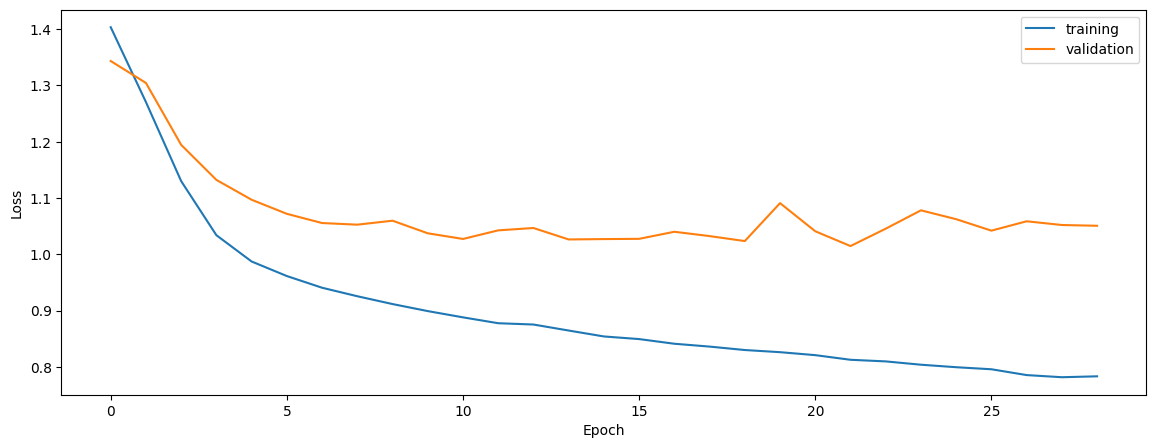

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6840387811634349
0.6358117157761173
0.7003291336353341


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6840387811634349
0.6358117157761173
0.7003291336353341


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6908279721375958
0.6512606503216832
0.7123411978221416


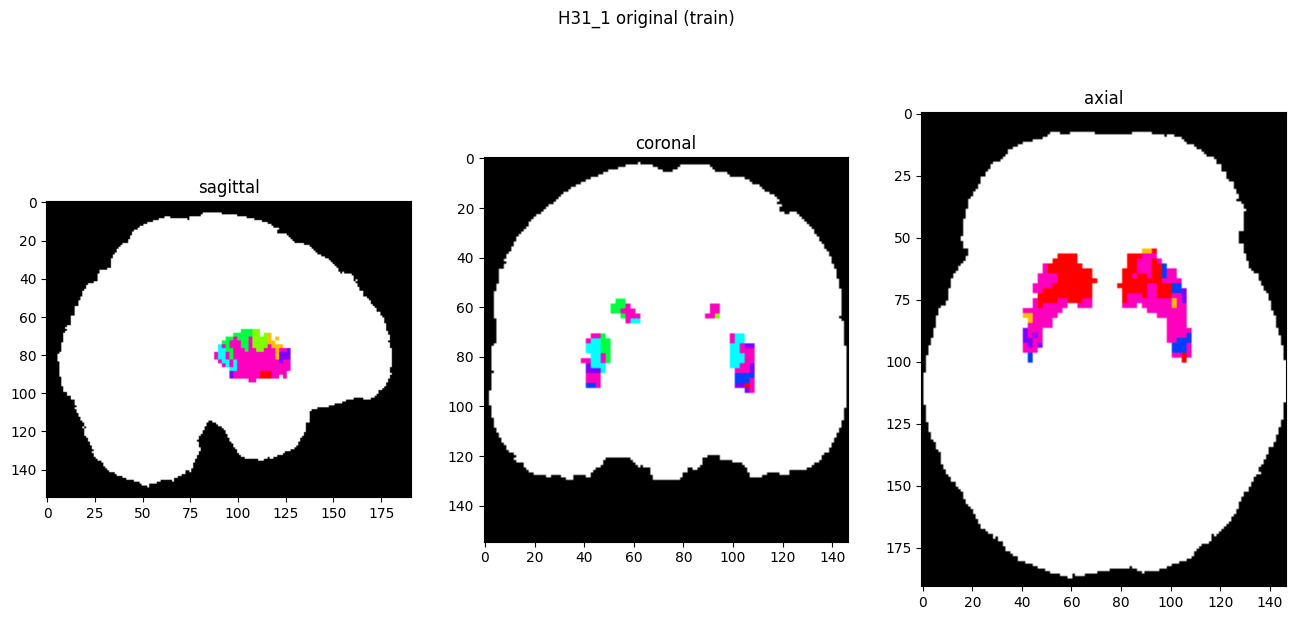

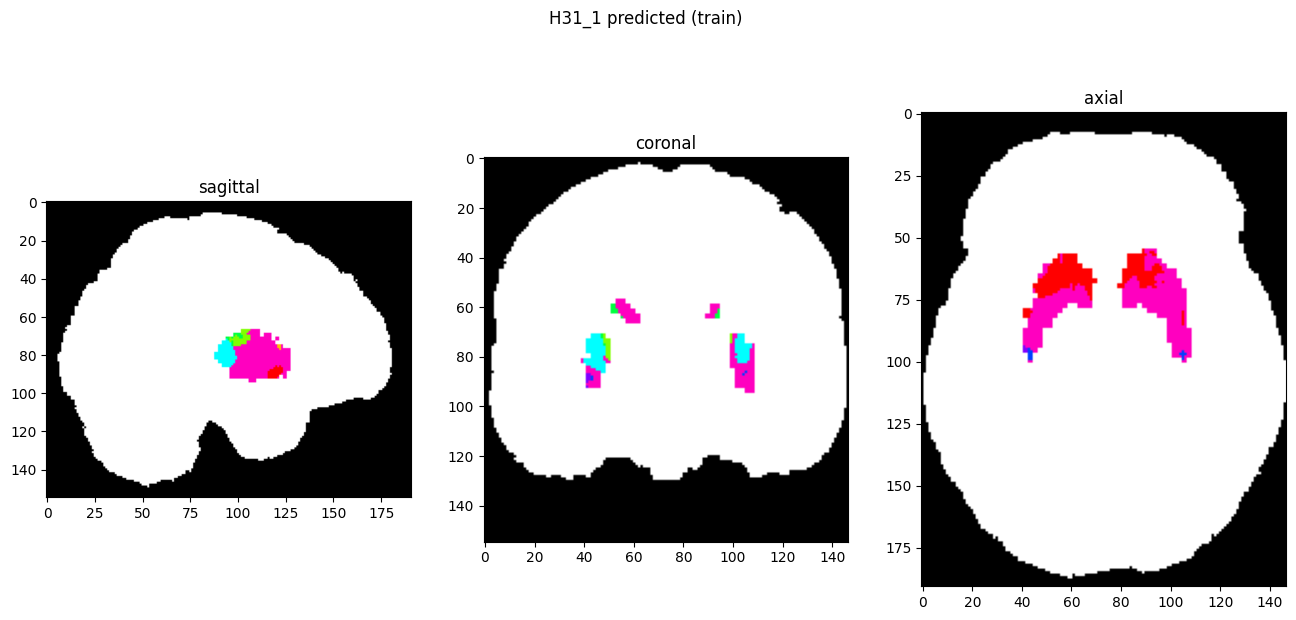

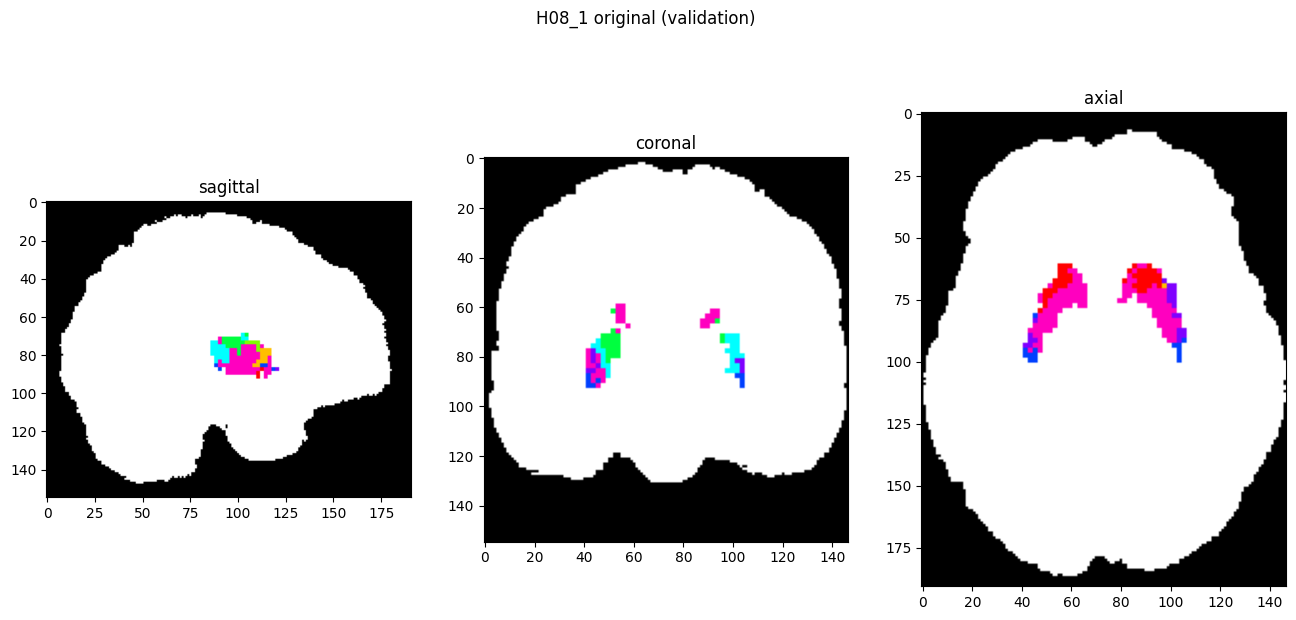

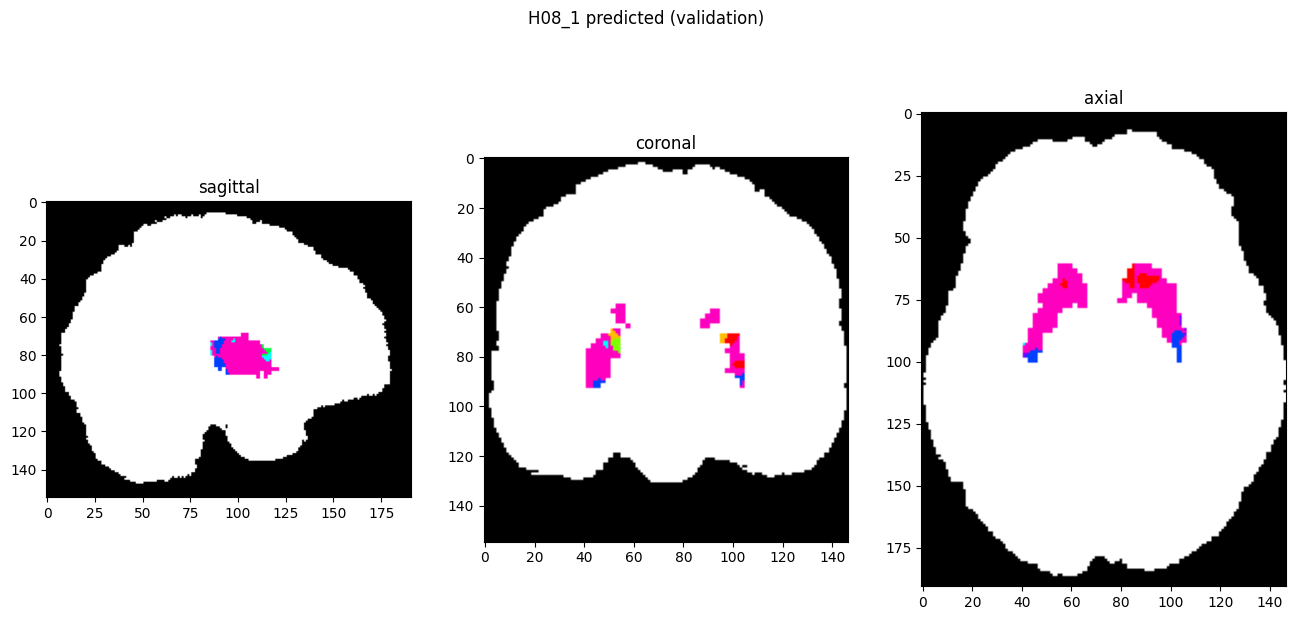

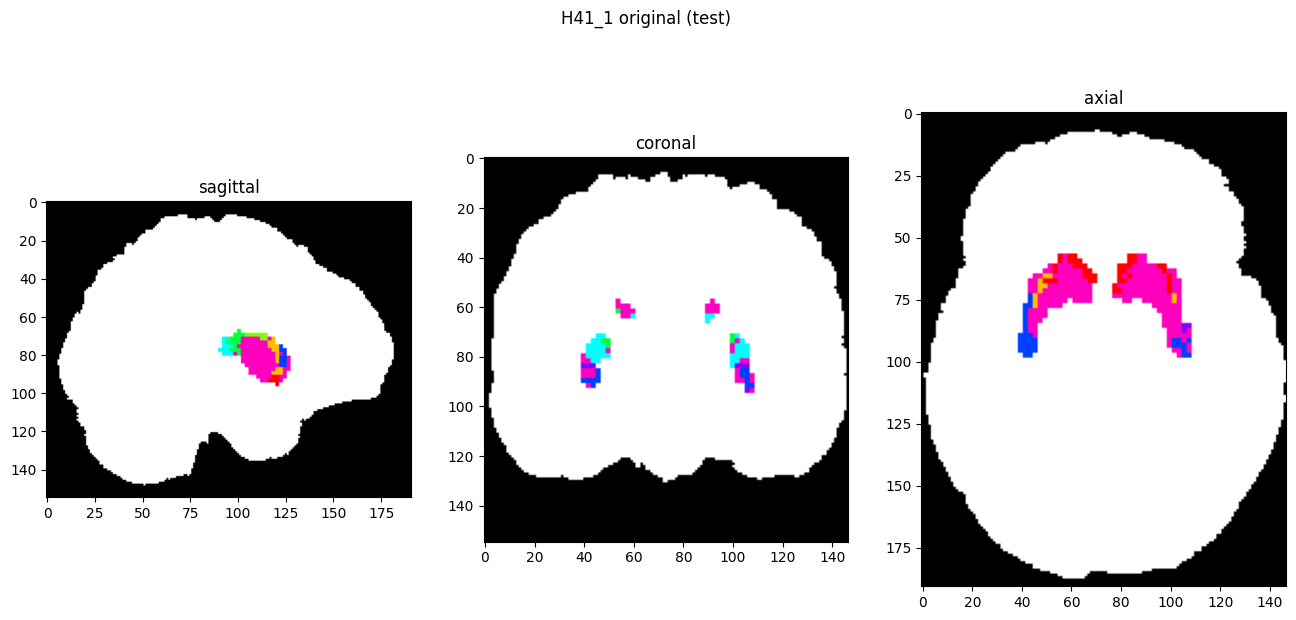

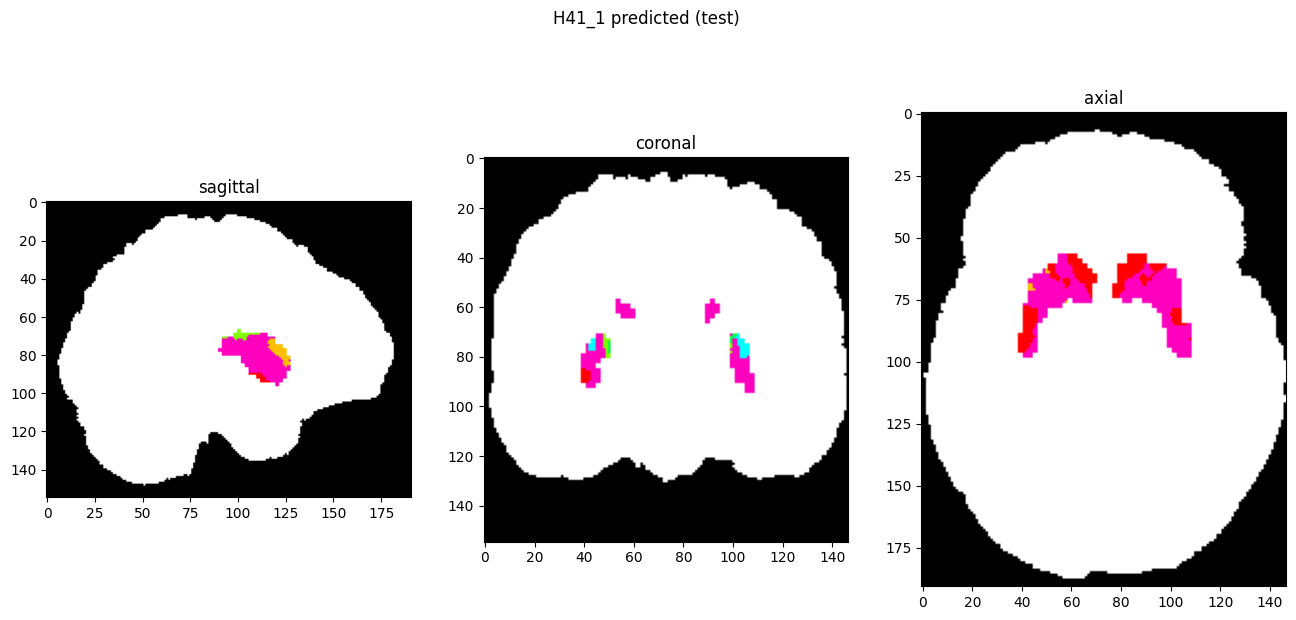

In [10]:
showResults(model, gen, threshold=0)